# [当你点开这首《八月》的歌：9400余条评论的分析与挖掘](https://zhuanlan.zhihu.com/p/41516392) 
## 因缘际会
八月伊始的当口，念想着：新的一个月了，是否有关于八月的歌呢，闲时也蛮想找来听下的。说来也怪，哪个月都不曾有过此念头，这回却“突发奇想”且又念念不忘，于是打开网易云音乐，傻瓜般地搜索“八月”，倒也真有不少同名歌曲，其中第一首就是[八尾旅人的日文歌曲《八月》](https://music.163.com/#/song?id=29450761)，点开听了下，还无暇看歌词描写的是什么，就看到了评论数高达9千余条，而且有8月1号当天许多“同道中人”的留言，看来在这新的一个月的当日，有此心路历程和“行迹”的人，却也不在少数哈。 
<img src='images/August.jpg'>

也正是有感于在无从知晓的地方有那么多人曾有过如此相似的行为，且对这样一首以月份为主题的歌曲到底引发了听友哪些感慨的好奇，我打算爬取此歌曲的全部9400余条评论（截止2018-08-06晚上），并尝试进行分析和挖掘，庆幸的是很久前 Python 交友娱乐会所群（QQ 群：613176398，这不是 ads 系列）里曾有人分享过现成的爬取网易云音乐歌曲评论的爬虫，免去了破解反爬 JS 加密之苦，可以更专注于后续步骤。

若对爬虫感兴趣的可以看下这个话题：[如何爬网易云音乐的评论数？](https://www.zhihu.com/question/36081767/answer/140287795) 。

一个不成熟的小建议就是读者可以边听[八尾旅人《八月》](https://music.163.com/#/song?id=29450761)这歌边阅读本文或运行本 notebook。

## 网易云音乐歌曲评论爬虫 
本次爬取[《八月》七尾旅人 - 网易云音乐](https://music.163.com/#/song?id=29450761)这首歌在2018-08-06之前的全部9400余条评论，并尝试分析和挖掘。读者可以边点开听这歌看本文或运行代码。

In [5]:
import time
import random
from Crypto.Cipher import AES
import base64
import codecs
import requests
import json
import unicodedata as unicode
import pandas as pd

# 八月
# 歌手：七尾旅人
# https://music.163.com/#/song?id=29450761
# 20180801 18:35 共9286条评论
# song = 'R_SO_4_29450761' 

url = 'https://music.163.com/weapi/v1/resource/comments/R_SO_4_29450761?' \
      'csrf_token='
header = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 '
                  '(KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36',
    #'Referer': 'http://music.163.com/song?id=551816010',
    #  five hundred miles
    'Referer': 'http://music.163.com/song?id=29450761',
    'Origin': 'http://music.163.com',
    'Host': 'music.163.com'
}

second_param = '010001'
third_param = '00e0b509f6259df8642dbc35662901477df22677ec152b5ff68ace615bb7b725152b3ab17a876aea8a5aa' \
              '76d2e417629ec4ee341f56135fccf695280104e0312ecbda92557c93870114af6c9d05c4f7f0c3685b7a46bee' \
              '255932575cce10b424d813cfe4875d3e82047b97ddef52741d546b8e289dc6935b3ece0462db0a22b8e7'
forth_param = b'0CoJUm6Qyw8W8jud'
# params 需要第一个和第四个参数 encSecKey需要一个随机的16位字符串和第二个和第三个参数
strw = 'S' * 16

def aesEncrypt(text, key):
    # 偏移量
    iv = b'0102030405060708'
    pad = 16 - len(text) % 16
    # print(type(text))
    tt = pad * chr(pad)
    text = text + tt.encode('utf-8')
    encrpyptor = AES.new(key, AES.MODE_CBC, iv)
    cipher_text = encrpyptor.encrypt(text)
    cipher_text = base64.b64encode(cipher_text)
    return cipher_text

def rsaEncrypt(pubkey, text, mouduls):
    text = text[::-1]
    rs = int(codecs.encode(text.encode('utf-8'), 'hex_codec'), 16) ** int(pubkey, 16) % int(mouduls, 16)
    rs = format(rs, 'x').zfill(256)
    #print(rs)
    return rs

def get_params(text):
    if text == 1:
        first_param = b'{"rid":"", "offset":"0", "total":"true", "limit":"20", "csrf_token":""}'
        params = aesEncrypt(first_param, forth_param)
    else:
        offset = str((text-1)*20)
        first_param = b'{"rid":"", "offset":"%b", "total":"false", "limit":"20", "csrf_token":""}' % offset.encode('utf-8')
        params = aesEncrypt(first_param, forth_param)
    # print('params的随机值是: ')
    # print(params)
    params = aesEncrypt(params, strw.encode('utf-8'))
    # print('第二次加密后的随机值是：')
    # print(params)
    return params

def get_rsa(text):
    encseckey = rsaEncrypt(second_param, text, third_param)
    return encseckey

def get_json(url, pm, esk):
    form_data = {
        'params': pm,
        'encSecKey': esk
    }
    json_text = requests.post(url, headers=header, data=form_data).text
    return json_text

### comments 一网打尽
评论共475页，每页20条评论，全在 comments 列表里面，先不对信息进行提取，方便后面对原本没想提取的参数信息也都可以本地提取，另外也是由于在开始尝试先提取想要的参数后，发现评论内容处有不少写入csv后，换行导致数据混乱，无从解决，故而几个原因致使改为“一网打尽”数据。

In [6]:
params = get_params(1)
encSecKey = get_rsa(strw)
json_text = get_json(url, params, encSecKey)
json_dict = json.loads(json_text)
comments_num = int(json_dict['total'])
if comments_num % 20 == 0:
    page = comments_num / 20
else:
    page = int(comments_num / 20) + 1
print("共有%d条评论!" % comments_num)  # 全部评论总数
print("共有%d页评论!" % page)
music_comments = pd.DataFrame(columns = ['page','json_comments'])
start_page = 0 # 修改起始页数（初始值为 0）和 csv 文件名，方便爬虫中断后，继续爬取 # 断点续爬
try:
    for i in range(start_page, page):  # 逐页抓取
        params = get_params(i + 1)
        encSecKey = get_rsa(strw)
        json_text = get_json(url, params, encSecKey)
        json_dict = json.loads(json_text)
        json_comments = json_dict['comments'] # 
        music_comments = music_comments.append({'page':i+1,'json_comments':json_comments},ignore_index=True)            
        print(i+1, len(json_comments))
        #if page%5==0:
        #    #time.sleep(random.randint(0,1))
except:
    print("Error")
music_comments.to_csv('August_JSon_Comments_1.csv',index=False,encoding='utf-8')

共有9485条评论!
共有475页评论!
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
9 20
10 20
11 20
12 20
13 20
14 20
15 20
16 20
17 20
18 20
19 20
20 20
21 20
22 20
23 20
24 20
25 20
26 20
27 20
28 20
29 20
30 20
31 20
32 20
33 20
34 20
35 20
36 20
37 20
38 20
39 20
40 20
41 20
42 20
43 20
44 20
45 20
46 20
47 20
48 20
49 20
50 20
51 20
52 20
53 20
54 20
55 20
56 20
57 20
58 20
59 20
60 20
61 20
62 20
63 20
64 20
65 20
66 20
67 20
68 20
69 20
70 20
71 20
72 20
73 20
74 20
75 20
76 20
77 20
78 20
79 20
80 20
81 20
82 20
83 20
84 20
85 20
86 20
87 20
88 20
89 20
90 20
91 20
92 20
93 20
94 20
95 20
96 20
97 20
98 20
99 20
100 20
101 20
102 20
103 20
104 20
105 20
106 20
107 20
108 20
109 20
110 20
111 20
112 20
113 20
114 20
115 20
116 20
117 20
118 20
119 20
120 20
121 20
122 20
123 20
124 20
125 20
126 20
127 20
128 20
129 20
130 20
131 20
132 20
133 20
134 20
135 20
136 20
137 20
138 20
139 20
140 20
141 20
142 20
143 20
144 20
145 20
146 20
147 20
148 20
149 20
150 20
151 20
152 20
153 20
154 20
155 20
15

如果一次性爬取下来了，那就单个文件。

In [7]:
import pandas as pd
df = pd.read_csv('August_JSon_Comments_1.csv',encoding='utf-8')
df.head()

page                                      json_comments
0     1  [{'user': {'locationInfo': None, 'remarkName':...
1     2  [{'user': {'locationInfo': None, 'userId': 360...
2     3  [{'user': {'locationInfo': None, 'vipType': 0,...
3     4  [{'user': {'locationInfo': None, 'vipType': 0,...
4     5  [{'user': {'locationInfo': None, 'userId': 573...

若断点续爬，有几个文件，就先整合拼接到一起，或者想爬取新增的评论，也可以相应的拼接起来，但注意去重。

In [ ]:
import pandas as pd
df_json_1 = pd.read_csv('August_JSonComments_1.csv',encoding='utf-8') # page 1-199
df_json_2 = pd.read_csv('August_JSonComments_2.csv',encoding='utf-8') # page 200-471
#df_json_1.head()
#df_json_2.tail()
df_all = pd.concat([df_json_1, df_json_2],ignore_index=True)
df_all.to_csv('August_Json_Comments_471_Pages.csv', encoding='utf-8')
df = pd.read_csv('August_Json_Comments_471_Pages.csv', encoding='utf-8')
df = df[['page','json_comments']]
df.head()

### 留意  json_comments 格式并转换
第一行第一列的数据内容详情，即为一页20条评论所涉及的全部信息，方便后面提取感兴趣的参数数据。注意数据是字符串格式，需要转换成列表，方便后面遍历提取数据。

In [8]:
df.loc[0,'json_comments']

"[{'user': {'locationInfo': None, 'remarkName': None, 'avatarUrl': 'http://p1.music.126.net/KFLFY1Zfu7Gi47CMKZPsPA==/109951163111892043.jpg', 'experts': None, 'authStatus': 0, 'expertTags': None, 'userId': 346392120, 'nickname': '仙谛瑞拉', 'userType': 0, 'vipType': 0}, 'beReplied': [{'user': {'locationInfo': None, 'remarkName': None, 'avatarUrl': 'http://p1.music.126.net/BMnRymlSZE1vLgtuYhvfiA==/18743374719101276.jpg', 'experts': None, 'authStatus': 0, 'expertTags': None, 'userId': 281501321, 'nickname': '流浪的馒头-', 'userType': 0, 'vipType': 0}, 'content': '想死死看，有没一起的？', 'status': 0, 'expressionUrl': None}], 'pendantData': None, 'expressionUrl': None, 'time': 1533550956926, 'likedCount': 0, 'liked': False, 'commentId': 1206471392, 'content': '有 然后我会以千百万种方式将你救回来.', 'isRemoveHotComment': False}, {'user': {'locationInfo': None, 'remarkName': None, 'avatarUrl': 'http://p1.music.126.net/JaIbBNDjOysFQqUPwPQLQw==/109951163169621936.jpg', 'experts': None, 'authStatus': 0, 'expertTags': None, 'userI

字符串转换成列表： `eval()`

In [9]:
# eval('[1,2,3]') # [1, 2, 3]
df['json_comments'] = df['json_comments'].apply(lambda x: eval(x))
df.loc[0,'json_comments']

[{'beReplied': [{'content': '想死死看，有没一起的？',
    'expressionUrl': None,
    'status': 0,
    'user': {'authStatus': 0,
     'avatarUrl': 'http://p1.music.126.net/BMnRymlSZE1vLgtuYhvfiA==/18743374719101276.jpg',
     'expertTags': None,
     'experts': None,
     'locationInfo': None,
     'nickname': '流浪的馒头-',
     'remarkName': None,
     'userId': 281501321,
     'userType': 0,
     'vipType': 0}}],
  'commentId': 1206471392,
  'content': '有 然后我会以千百万种方式将你救回来.',
  'expressionUrl': None,
  'isRemoveHotComment': False,
  'liked': False,
  'likedCount': 0,
  'pendantData': None,
  'time': 1533550956926,
  'user': {'authStatus': 0,
   'avatarUrl': 'http://p1.music.126.net/KFLFY1Zfu7Gi47CMKZPsPA==/109951163111892043.jpg',
   'expertTags': None,
   'experts': None,
   'locationInfo': None,
   'nickname': '仙谛瑞拉',
   'remarkName': None,
   'userId': 346392120,
   'userType': 0,
   'vipType': 0}},
 {'beReplied': [],
  'commentId': 1206481007,
  'content': '我以为是个成熟的阿姨在唱歌，歌手居然是个大胡子叔叔？？？',
  'expre

**将字符串格式的 json_comments 列数据转换成列表格式**，并查看下数据

In [10]:
comments = df['json_comments'].values.tolist()
print(len(comments) ,comments[0][0]['user']['nickname'] ,comments[0][0]['content'])

475 仙谛瑞拉 有 然后我会以千百万种方式将你救回来.


**将列表嵌套列表的数据格式转换成一个列表的格式**

In [11]:
sum([[1,2],[2,3],[1]],[])

[1, 2, 2, 3, 1]

In [12]:
comments = sum(comments, [])

转换成列表，此时列表中元素即为全部9416条评论的数据

In [13]:
print(len(comments),comments[0])

9490 {'user': {'locationInfo': None, 'remarkName': None, 'avatarUrl': 'http://p1.music.126.net/KFLFY1Zfu7Gi47CMKZPsPA==/109951163111892043.jpg', 'experts': None, 'authStatus': 0, 'expertTags': None, 'userId': 346392120, 'nickname': '仙谛瑞拉', 'userType': 0, 'vipType': 0}, 'beReplied': [{'user': {'locationInfo': None, 'remarkName': None, 'avatarUrl': 'http://p1.music.126.net/BMnRymlSZE1vLgtuYhvfiA==/18743374719101276.jpg', 'experts': None, 'authStatus': 0, 'expertTags': None, 'userId': 281501321, 'nickname': '流浪的馒头-', 'userType': 0, 'vipType': 0}, 'content': '想死死看，有没一起的？', 'status': 0, 'expressionUrl': None}], 'pendantData': None, 'expressionUrl': None, 'time': 1533550956926, 'likedCount': 0, 'liked': False, 'commentId': 1206471392, 'content': '有 然后我会以千百万种方式将你救回来.', 'isRemoveHotComment': False}


### 提取数据
本次将所有参数都进行了提取，且由于评论时间 commentTime 为时间戳格式，一并以年月日时间等格式的 stamp 转换后保存。本步骤遍历9400+条数据，耗些时间，但不必在爬虫时提取，本地操作较为方便。 

[Python 获取13位时间戳](https://yq.aliyun.com/wenzhang/show_58758)  
用Python 模拟抓取网站上的数据，发现js生成的时间都是13位的，那么该怎么获取对应的13位时间戳

In [1]:
import time
commentTime = 1533116259515 # 13 位 # 一般是 10 位
print(int(time.time()))
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(commentTime/1000)))

1533657968
2018-08-01 17:37:39


In [29]:
%%time
# Wall time: 6min 11s
# comments: [{user: {locationInfo: null, authStatus: 0, remarkName: null,…}, beReplied: [], pendantData: null,…},…]
music_comments = pd.DataFrame(columns = ['No','page','userID','nickname','comment',
                                         'commentTime','stamp','likedCount','location','userType',
                                         'vipType','expertTags','experts','avatarUrl','authStatus',
                                         'remarkName','beReplied','pendantData','expressionUrl','liked',
                                         'commentId','isRemoveHotComment'])
page=1
for num,item in enumerate(comments):
    comment = item['content'].replace('\r\n', ' ').replace('\n',' ') #.replace('↵', ' ').replace('\r\n', ' ').replace('\n',' ')  # 评论内容
    nickname = item['user']['nickname']  # 昵称
    userID = item['user']['userId']  # 评论者id
    avatarUrl = item['user']['avatarUrl']  # 头像
    userType = item['user']['userType']  # 
    
    vipType = item['user']['vipType']  # VIP
    expertTags = item['user']['expertTags']
    experts = item['user']['experts']
    location = item['user']['locationInfo']
    authStatus = item['user']['authStatus']
    
    remarkName = item['user']['remarkName']
    likedCount = item['likedCount']  # 点赞总数
    commentTime = item['time']  # 时间
    beReplied = item['beReplied']
    pendantData = item['pendantData']
    
    expressionUrl = item['expressionUrl']
    liked = item['liked']
    commentId = item['commentId']
    isRemoveHotComment = item['isRemoveHotComment']        
    stamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(commentTime/1000))
    print(num+1,page,stamp,comment)        
    music_comments = music_comments.append({'No':num+1,'page':page,'userID':userID,'nickname':nickname,'comment':comment,'commentTime':commentTime,'stamp':stamp,'likedCount':likedCount,'location':location,'userType':userType,'vipType':vipType,'expertTags':expertTags,'experts':experts,'avatarUrl':avatarUrl,'authStatus':authStatus,'remarkName':remarkName,'beReplied':beReplied,'pendantData':pendantData,'expressionUrl':expressionUrl,'liked':liked,'commentId':commentId,'isRemoveHotComment':isRemoveHotComment},ignore_index=True)
    if int((num+1)%20) == 0:
        page += 1
    #print(num,'***',i+1,'***',userID,'***',nickname,'***',comment,'***',commentTime,'***',stamp,'***',likedCount,'***',userType,'***',vipType,'***',expertTags,'***',experts,'***',avatarUrl)
music_comments.to_csv('August_JSon_475_Pages_All_Data.csv', encoding='utf-8', line_terminator='\r\n')

1 1 2018-08-06 18:22:36 有 然后我会以千百万种方式将你救回来.
2 1 2018-08-06 18:14:18 我以为是个成熟的阿姨在唱歌，歌手居然是个大胡子叔叔？？？
3 1 2018-08-06 17:34:21 想死死看，有没一起的？
4 1 2018-08-06 17:08:20 整首歌有种压抑的感觉
5 1 2018-08-06 16:48:29 八月的生活网易给我推了八月 暑假过去一半了 时间过得好快 都不会等我一下
6 1 2018-08-06 14:40:04 八月啦
7 1 2018-08-06 13:59:23 2014年8月 ，我们        分开 她                    住在那个八月 2018年8月， 我养了一只猫 它                    名字就叫八月 八月四月份出生，现在八斤 我们四年前分开，她喜欢猫 然后今年八月，我养了只猫 以前总是叫她猫猫， 现在没事喊喊八月。 接着听着这首八月。 ---------------见长
8 1 2018-08-06 11:39:58 我一直以为是个女的唱的   等我点进歌手页   我：……？？
9 1 2018-08-06 11:39:43 哎呀 这天还是我生日[大笑]
10 1 2018-08-06 11:02:02 听过的歌应该像看过的书 不向任何人主动聊起 而是在心境一个如此相似的环境里 一并谈起 这样就算不被理解 好歹书和音乐没有被你的心意辜负 再一次被你深深记忆
11 1 2018-08-06 10:18:17 是哦
12 1 2018-08-06 09:07:43 不想一个人，却又喜欢一个人
13 1 2018-08-06 02:28:26  你好八月，再见夏天
14 1 2018-08-05 23:13:43 去年8.27 分开的日子 台风天～
15 1 2018-08-05 22:24:35 离八月还有两个小时 我被分手了 这次他真的离开了 从我的人生退了
16 1 2018-08-05 22:08:38 每次想要改变点什么的时候总会遇到八月
17 1 2018-08-05 21:48:11 最荒唐的是，人们在情人节说着谎话，却在愚人节说出真话。
18 1 2018-08-05 21:43:31 不年轻处就是别人的了..
19

178 9 2018-08-01 23:12:58 又一年，八月了
179 9 2018-08-01 23:12:06 我跟你讲，就这四年，我就等你四年了，我没有几个四年了，四年后你若还是不会喜欢我，我就放弃了
180 9 2018-08-01 23:08:39 这个八月，一定要对她表白！
181 10 2018-08-01 23:05:49 十号是生日 很累 何必有我
182 10 2018-08-01 22:58:35 八月了，今年的夏天我想谈恋爱。
183 10 2018-08-01 22:38:00 8月的日推，愿一切安好啊
184 10 2018-08-01 22:28:01 八月加油！距离考研只有二十周了 。
185 10 2018-08-01 22:25:35 八月底准备入伍，家人朋友都要离开了，加油，待我荣归故里[拜]
186 10 2018-08-01 22:23:27 八月
187 10 2018-08-01 22:20:41 八月第一天的日推
188 10 2018-08-01 22:20:07 孤独成狗
189 10 2018-08-01 22:19:21 啊，到八月了呢
190 10 2018-08-01 22:16:21 啊哈哈哈哈  我可没有  只是觉得现在的自己没有以前那么稚气     选择  接受成长  也得接受所有不欢而散  只是后悔她遇到的不是最好的我 也不是最好的我们
191 10 2018-08-01 22:15:02 今天是八月一号 
192 10 2018-08-01 22:11:41 今年九月22，处处是坎，丧死
193 10 2018-08-01 22:10:57 Follow your heart 
194 10 2018-08-01 22:09:41 うれしい歌で かき消したら 仆は、もう帰るね ureshii utade kaki keshi tara bokuwa mou kaeru ne 君の前髪が揺れるから　怖くなって しゃがんだ kimino maegamiga yureru kara kowaku natte shaganda オルゴールを巻き返す　キリキリとバネが弾けるまでまわす oru go-ruwo maki kaesu kirikiri to banega hajikeru made mawa

361 19 2018-08-01 08:05:46 八月，一年了，miss u...
362 19 2018-08-01 08:05:34 八月
363 19 2018-08-01 08:05:29 今天是2018年八月的第一天
364 19 2018-08-01 08:02:22 八月，早安。
365 19 2018-08-01 07:59:13 ❤️ August.
366 19 2018-08-01 07:57:29 暑假已经过半了 下学期返校就大三啦 怎么办 没有喜欢的人 没有热衷的事 就这样按部就班地考研工作相亲结婚吗 最近一想到这些就头疼 总之 好好生活吧。
367 19 2018-08-01 07:56:44 八月顺利.
368 19 2018-08-01 07:54:22 八月了 你快回家吧
369 19 2018-08-01 07:54:06 和你的开始总是在八月
370 19 2018-08-01 07:51:06 祝快乐，
371 19 2018-08-01 07:49:20 八月你好 这是我最喜欢的七尾的歌[憨笑]
372 19 2018-08-01 07:48:57 八月
373 19 2018-08-01 07:48:28 八月第一天 🤘️
374 19 2018-08-01 07:48:10 刚来深圳20天，还行，一切顺利，接下来我要朝着自己目标不断前行了，加油！
375 19 2018-08-01 07:44:30 八月日语又叫叶月，意思是树叶开始飘落的月份，也有人说叶月有人们离家远行的含义。或许现在你就像离开树木的落叶一样，也许回归大树根部，也可能被风吹往更远的地方，但不管你身在何处，你都是这个温柔八月的意义所在，祝你游必有方。 加油！
376 19 2018-08-01 07:43:32 八月🎈长安
377 19 2018-08-01 07:43:08 今天是八月第一天
378 19 2018-08-01 07:43:05 八月善待我
379 19 2018-08-01 07:42:31 漫长时光 你会伤心痊愈。转眼一年
380 19 2018-08-01 07:42:19 谁的青春不迷茫 我正在迷茫中
381 20 2018-08-01 07:41:01 就是这个八月。 8号马上十八岁的我。 对未来很迷茫的我。 生活是苦难的 

546 28 2018-08-01 00:34:15 八月了，越来越陌生的未来
547 28 2018-08-01 00:33:30 八月，又一个夏天即将逝去
548 28 2018-08-01 00:33:27 对我温柔一点啊
549 28 2018-08-01 00:32:53 特么的时间也太快了吧 沃靠！
550 28 2018-08-01 00:31:21 8月
551 28 2018-08-01 00:30:21 八月了，肥宅居，我会一直一直喜欢你，陪着你哦⊙∀⊙，你的小橘猫留~@万华镜
552 28 2018-08-01 00:29:36 你好，八月[爱心]        愿[爱心] 君の名を知った 君と笑った[爱心]
553 28 2018-08-01 00:28:21 八月！努力啊！！
554 28 2018-08-01 00:27:55 又是八月了，距离第一次听这首歌刚好一年。只是现在的我丝毫不比一年前的我更好
555 28 2018-08-01 00:27:03 八月快乐
556 28 2018-08-01 00:26:37 八月 我喜欢大海 也喜欢你呀
557 28 2018-08-01 00:26:28 转眼就是八月了，就这么快一年了啊
558 28 2018-08-01 00:26:25 又一年的八月啊。
559 28 2018-08-01 00:25:28 天亮，那个人就结婚了
560 28 2018-08-01 00:25:17 八月，你好～～
561 29 2018-08-01 00:24:49 八月 你好 你也会对我好的吧 最难受的日子我已经扛过去了
562 29 2018-08-01 00:23:59 八月了  想你
563 29 2018-08-01 00:23:42 八月💛
564 29 2018-08-01 00:23:37 谢谢～也祝你万事顺利～
565 29 2018-08-01 00:23:05 八月 要对你好一点
566 29 2018-08-01 00:22:30 八月 想见你
567 29 2018-08-01 00:22:11 加油
568 29 2018-08-01 00:21:58 会的，一切都会好的
569 29 2018-08-01 00:21:44 去年的8月 我们的感情到此结束… 很遗憾[心碎] 2

718 36 2018-07-31 16:15:54 七月的尾巴
719 36 2018-07-31 15:30:07 又是一年八月有什么人什么事会出现
720 36 2018-07-31 15:15:05 八月长安
721 37 2018-07-31 15:01:57 七月的最后一天听八月
722 37 2018-07-31 14:52:27 八月！家里的人都走了。大人去工作，小孩去上学，原本热闹的村庄似乎变成了废弃的荒野。阳光肆意地洒下，风不紧不慢地吹着，我也该走了。天气大好，晒衣服，收拾行李，整理房间，塞上耳机，整日循环这个歌单。我走之后，这个大房子又该蒙一年的尘了。待年末时，希望你会更好。回头看看自己，
723 37 2018-07-31 14:34:26 怎么就八月了 希望这个月可以收获多多[憨笑]
724 37 2018-07-31 13:30:58 八月，
725 37 2018-07-31 13:30:27 2018了
726 37 2018-07-31 13:18:49 我还是要跟你一直在一起 不要再见了
727 37 2018-07-31 13:14:10 今天出专业，被调剂到自己很排斥的专业，难过[哀伤]，听这首歌时想七月要过去了，八月要来了，然后夏天快走了
728 37 2018-07-31 13:07:17 今天我生日 希望过完 八月会更好
729 37 2018-07-31 12:40:27 就想知道考研听个歌有啥可哭唧唧的 
730 37 2018-07-31 12:24:38 好听 歌词喜欢
731 37 2018-07-31 12:09:44 还有十二个小时就到了八月，这个暑假是我初中生涯最后一个有暑假作业的暑假了。明年中考，希望明年八月能笑着期待九月一号开学迈进心仪学校。。。
732 37 2018-07-31 10:59:44 七月末尾听到八月
733 37 2018-07-31 10:54:38 八月你好，高三了，好好生活，好好学习，不玩手机，不谈恋爱，该清醒了，明确自己的目标是清华大学，即将收拾东西上学啦，祝屏幕前的朋友们好好生活，记得开心。
734 37 2018-07-31 10:50:56 加油
735 37 2018-07-31 10:26:45 七月的最后一天了呢。哎？怎么就七个月过去了呢
736 37 2018-

876 44 2018-07-29 09:07:28 加油
877 44 2018-07-29 08:47:29 八月 快要满20岁了
878 44 2018-07-28 21:47:26 八月 马上就要进入大学了 继续做个孤独前行的勇者吧
879 44 2018-07-28 20:49:48 你听到他最后哽咽了吗
880 44 2018-07-28 18:23:48 好喜欢好喜欢这首歌的旋律啊，1:07分之后的间歇性的重复节奏像是消极情绪的逐渐释放～
881 45 2018-07-28 14:47:30 2018.7.28留  8月就是进入而立之年的第一个月，走在人生一个明与暗、辛与酸、奋进与克制并存的阶段，希望不彷徨，希望一切都好。
882 45 2018-07-28 13:14:42 考研，考研，考研。为的是看得远一点，是不想世界改变我。我不想变成自以为是的大人，我想给我的梦画上颜色。
883 45 2018-07-28 12:21:25 马上就要八月啦
884 45 2018-07-28 11:35:49 一开口以为是青峰
885 45 2018-07-28 11:08:34 哈哈哈，真巧
886 45 2018-07-28 09:23:43 7月的尾巴 听到了一首八月，提醒我快要23岁了！如果不是这首歌，我都快忘记我要过生日了。。。。
887 45 2018-07-28 09:18:08 本我们在八月就能结束半年多的异地恋，但因为我的倔强和没用的尊严我们分手了，八月快到了，她有了新欢。
888 45 2018-07-28 08:57:17 八月快到了
889 45 2018-07-28 06:34:32 我也是出生在八月，马上19了
890 45 2018-07-28 02:25:21 刚毕业的这段时间没有工作没有朋友，难熬且漫长，希望八月能有所改变吧[拜]
891 45 2018-07-28 01:22:52 八月的自己，一定会变得更好
892 45 2018-07-28 00:33:21 我出生在八月，十九岁啦，希望自己可以在以后的日子里能开心，我爱你们，所有的我的一切
893 45 2018-07-28 00:12:52 八月就要来了，希望能够一切顺意
894 45 2018-07-27 23:52:22 眨眼快到八月啦，去年八月仿佛在昨日，林荫里奔

1047 53 2018-07-08 22:47:05 抱抱
1048 53 2018-07-08 22:02:56 八月快了
1049 53 2018-07-08 21:24:05 爱你第二个暑假里的你，老婆！
1050 53 2018-07-08 18:32:45 以前空间分享过这首歌  上次就收到了我妹的明信片  上面就写的这个
1051 53 2018-07-08 16:19:22 爸，我想你
1052 53 2018-07-08 16:13:54 我二十四啦，还是神经质[汗]
1053 53 2018-07-08 14:08:14 没关系的 你的内心永远是你的 不会有任何人窥探  [爱心]
1054 53 2018-07-08 13:11:34 @豫流冰河
1055 53 2018-07-08 11:55:27 年纪越大越会明白，少年时曾说过的话，不管多么情真意切，最后也终流于天真，但是有什么关系呢，那不代表它们就是谎言。我是年纪越大越会明白，少年时曾说过的话，不管多么情真意切，最后也终流于天真，但是有什么关系呢，那不代表它们就是谎言。我是真心希望，如你所言，在我之后，你再没有不能失去的
1056 53 2018-07-08 11:32:17  我的生日在八月、我最爱的电影是《八月》、我最爱的歌是《八月》、我的名字也叫八月
感恩八月感恩七月尾018-07-08 10:50:29 在八月之前我可以见到五月天
1058 53 2018-07-08 09:28:35 现在是七月初..
1059 53 2018-07-08 08:07:38 加油你是最棒的[强]
1060 53 2018-07-08 01:53:13 啊，七月份来听这首八月[憨笑]
1061 54 2018-07-07 23:43:38 阿 下个月就可以分享这首啦
1062 54 2018-07-07 22:31:25 如果说我初中时代在浪费，那么高一就是脑瘫。昨天看了好多以前的随笔，你确定继续之前的努力够未来用？
1063 54 2018-07-07 19:14:26 7月了 日子过得飞快 我要二十二岁了
1064 54 2018-07-07 17:53:31 八月我们和好吧
1065 54 2018-07-07 09:25:11 @过犹不-及  想要见你
1066 54 2018-07-07 

1208 61 2018-06-13 09:49:06 正常人就是舒服的天气美美的心情 希望不开心的人也能乐观舒适一些
1209 61 2018-06-13 07:25:56 八月之杯中安坐着真正的诗人 所视来去不定的云朵 也许我一辈子也无法将你看清。”
1210 61 2018-06-12 21:31:03 我要毕业了。
1211 61 2018-06-12 21:13:11 八月你要是能记起来就好了
1212 61 2018-06-12 19:57:26 开口第一句还以为是五月天
1213 61 2018-06-12 16:05:12 八月就是八月，八月我守口如瓶， 八月里我是瓶中的水，你是青天的云。
1214 61 2018-06-12 03:53:33 我觉得相遇不分年龄，任何时候的相遇都来之不易，无论如何请好好珍惜在一起那段时光。总是好过素昧平生。
1215 61 2018-06-11 12:45:03 留名求一个赞
1216 61 2018-06-11 11:42:15 到今年八月我已经一年没见过你了
1217 61 2018-06-11 08:13:49 看来我们年龄差不多
1218 61 2018-06-11 00:03:30 同25岁，共勉[大笑]
1219 61 2018-06-10 22:31:26 从来给自己力量的都是悲伤的歌……
1220 61 2018-06-10 21:38:23 你离梦想越来越远了啊，渐渐地变得越来越沉默，八月要到了，是否可以重新背起行囊，重新追逐最初的梦想，放弃一切的样子也很美好，不是吗？
1221 62 2018-06-10 16:39:58 七月的风 八月的你 无力的喜欢 遥远的距离
1222 62 2018-06-10 15:17:01 声音太少年了吧[爱心]
1223 62 2018-06-09 15:30:11 总感觉像听过的一首歌
1224 62 2018-06-09 10:44:58 昨天高考完了，下个八月就要来了，又会有什么故事发生呢！
1225 62 2018-06-08 20:26:14 怎么知道这首歌的呢。那年我没考上她的高中，一直不敢告诉她我喜欢她。就那么平淡地跟没事儿人一样过了一个暑假，转眼八月要结束了，开学前的晚上我突然想起以后没办法再每天看着她，没办法再坐在同一间教室。她的生日就在八月，

1366 69 2018-05-12 21:18:50 没考呢。换目标院校了
1367 69 2018-05-12 19:57:33 二零一三年八月， 第一次见她已是五年前了
1368 69 2018-05-12 17:11:48 最喜欢听的歌，不薄不厚，不空不腻。
1369 69 2018-05-12 15:27:00 八月你是发情的酒鬼，而我是你怀中的龙舌兰。
1370 69 2018-05-12 14:18:42 我想你们了，不知道你们是否也想我
1371 69 2018-05-12 08:16:41 当兵就要失联？我哥也当兵，也没看见他不能用手机啊？
1372 69 2018-05-12 00:30:43 忙到爆炸的五月[生气]宿舍最早起床，最晚睡觉的每天，各种事情堆满，我真的快崩溃了！五月快过去吧！（到底是谁说上了大学就轻松了？？？）这首歌莫名的治愈，我的八月快点来吧[幽灵]
1373 69 2018-05-11 17:41:52 dududududududu~~~~~~最后几句初恋的感觉
1374 69 2018-05-11 12:06:26 不敢想八月 但是八月我们可以相见
1375 69 2018-05-11 09:57:14 今年8月，我整整满25岁了，还没有能嫁给想嫁的那个人，还在外工作，还一无所有。有的可能就是这颗还不愿服输的心！生日那天，我再来，希望能有25个赞
1376 69 2018-05-11 08:47:23 2018.5.11日推最爱[色][色][色]
1377 69 2018-05-11 07:25:33 漫无止境的八月
1378 69 2018-05-10 22:44:32 八月，希望那时的自己正在期待高中生活
1379 69 2018-05-10 21:56:22 很喜欢收集小小的快乐 特别丧的时候 做自己的小天使  只是 很难过的时候 真的 真的 很想要一个拥抱  不过 没关系啦 这里也有好多好多桂花树 秋天最让我感到安心的味道 这里也有
1380 69 2018-05-10 21:24:24 八月我已经在实习啦   希望遇到的患者能多给我一个机会.
1381 70 2018-05-10 10:02:06 生活太艰难了啊，必须要在称心如意的工作和称心如意的人中间选一个
1382 70 2018-05-10 10:00:29 

1521 77 2018-04-19 08:42:20 去年八月，七个人，今年八月，六个人
1522 77 2018-04-19 08:24:37 2018年的4月，觉得已经没希望了，准备从2019年重新做人
1523 77 2018-04-19 01:45:34 🐸🐟🐥🐦🐱🐒
1524 77 2018-04-19 00:08:12 我喜欢7，因为给过我温暖的那个人
1525 77 2018-04-19 00:06:16 好像苏打绿青峰的声音啊
1526 77 2018-04-18 20:50:03 小姐姐这么可爱，一定是好看的皮囊里装着有趣灵魂了吧。
1527 77 2018-04-18 20:31:13 太少年感的声音了吧......
1528 77 2018-04-18 16:27:50 出国也过了两年了，知道了感情是经不起时间的折腾的。兄弟，别等了。
1529 77 2018-04-18 15:21:29 哈哈哈哈哈[大哭]
1530 77 2018-04-18 15:20:15 害羞～[憨笑]
1531 77 2018-04-18 15:18:30 我想和你在四月的树下
1532 77 2018-04-18 15:12:46 和你一起歌唱，在八月的雨中。
1533 77 2018-04-18 15:09:32 你来弹我来唱，哈哈
1534 77 2018-04-18 12:43:07 看着歌手封面我是现象不出这个声线  果然日本人不能看外表想象声音[大哭]  不过他们声音真的好听 
1535 77 2018-04-18 02:41:31 比较想要这首歌的曲谱[惶恐]
1536 77 2018-04-17 22:48:15 好听
1537 77 2018-04-17 22:06:43 欸！八月我生日嘢[憨笑]
1538 77 2018-04-17 19:42:28 可能上辈子的缘分太深重也太仓促，所以这辈子走了这么久来到身边，就是为了要好好地告别。
1539 77 2018-04-17 15:46:01 若いからといって出会ったのはいいことではない。
1540 77 2018-04-17 15:45:43 2日押し记念试験コースでは、最初の忍は崩壊して泣いた后、きっとますます良くなるだろうか。そうでなければ、今苦しんでいる来年の8月9月には必ず好きな学校に行

1670 84 2018-03-31 11:45:48 在一起八年了，可还是特别珍惜，希望我们要好好的走下去……
1671 84 2018-03-31 10:25:07 我一定会考上面筋的！！！
1672 84 2018-03-30 23:30:33 渐行渐远
1673 84 2018-03-30 19:17:55 谁能救救没心没肺的我啊！以为抛弃了全世界，其实是被全世界抛弃了吧！
1674 84 2018-03-30 19:06:54 考上了吗 
1675 84 2018-03-30 18:55:23 加油...
1676 84 2018-03-30 18:38:21 加油
1677 84 2018-03-30 17:43:57 人生转折点，がんばれ！！！
1678 84 2018-03-30 16:40:23 我肯定会考上北大的，一定会的。时间不会骗人的。
1679 84 2018-03-30 14:44:39 我肯定会考上南开的，一定会的。时间不会骗人的。
1680 84 2018-03-30 13:50:01 3.30
1681 85 2018-03-30 13:42:12 谢谢你啊[可爱]
1682 85 2018-03-30 13:34:35 小男孩是我第一个爱的人 也是我的最后一个              你说要永远永远和我在一起的 骗人
1683 85 2018-03-30 13:27:48 提前祝你生日快乐喽~
1684 85 2018-03-30 13:27:22 今年的八月份将是我最轻松也是最有压力的一个月，还有四个月，我还有时间。
1685 85 2018-03-30 11:29:34 我开心不起来了
1686 85 2018-03-30 10:32:19 8.8我生日啊现在就开始期待啦
1687 85 2018-03-29 22:14:56 我说过的 你是最后一个。
1688 85 2018-03-29 22:14:10 兄dei加油
1689 85 2018-03-29 21:07:27 偷偷告诉你，我们结婚了哦
1690 85 2018-03-29 19:42:27 嘛...情敌呀~
1691 85 2018-03-29 19:15:24 太温暖了啦
1692 85 2018-03-29 10:10:46 谢谢
1693 85 201

1819 91 2018-03-14 19:49:17 小林明子。。sorry
1820 91 2018-03-14 19:48:13 结尾音乐有点像小林幸子的fall in love？。。
1821 92 2018-03-14 16:18:59 我真混蛋啊 恨爸妈
1822 92 2018-03-14 16:04:36 加油
1823 92 2018-03-14 13:56:45 加油
1824 92 2018-03-14 00:04:20 明明是三月，却一直想着八月燥热的天气，冰凉的西瓜，窗外的蝉鸣。突如其来的狂风暴雨也好，冗长乏味的炎炎烈日也好。白昼变长，让人觉得一切都才刚刚开始，还来得及遇见你。
1825 92 2018-03-14 00:04:12 八月……是你的谎言。
1826 92 2018-03-13 23:53:37 我和她也是在8月在一起，但是16天后她就出国了，我会等到下一个三月她回来的！
1827 92 2018-03-13 23:04:30 和少年时代旋律有些像
1828 92 2018-03-13 22:12:50 加油
1829 92 2018-03-13 22:12:38 留爪
1830 92 2018-03-13 20:10:12 成绩出来那天我都没有哭的，一直忍到今天，忍到现在，直到刚刚看到热评的时候，眼泪刷的就留下来了。元旦时坐在厦大校园里某个不知名的湖边，阳光暖暖地照着，看着来来往往的厦大学子，心里就在想着，怎么他们可以，而我就不可以呢？今年决定卷土重来，愿明年八月我能赶上19届那班车
1831 92 2018-03-13 01:55:35 我们这一生都走在回家的路上
1832 92 2018-03-13 01:11:45 八月还远，可我是一直都特别想你的。
1833 92 2018-03-13 00:24:32 从九月就开始等八月了
1834 92 2018-03-12 23:59:17 混蛋，一定要加油
1835 92 2018-03-12 23:43:01 初中最后几个月，加油![可爱]
1836 92 2018-03-12 23:39:25 是喜欢的日推
1837 92 2018-03-12 23:30:50 害怕听这样的歌，怕眼泪一瞬间涌出，往事过影。最后发现只有自己可以安慰自己，却哭的不知所措。
1838 92 2

1987 100 2018-02-20 23:14:00 [大笑]
1988 100 2018-02-20 23:13:45 不相遇最合适
1989 100 2018-02-20 23:10:37 心情不好就想听听这歌
1990 100 2018-02-20 14:00:19 我希望时间停止
1991 100 2018-02-20 11:30:24 我也是17年九月入伍    不过是武警     距离退伍还有 十八个月540天
1992 100 2018-02-20 08:31:40 这么多日推我怎么就偏偏听了这首呢？仿佛是有魔力
1993 100 2018-02-20 08:29:30 八月的最后一天，黄昏。拿着一把木吉他，坐在海边的房子前，身边发出嘎吱嘎吱，一点都不流畅的声音的八音盒，想着你，想的不能自已，忍不住拿出吉他来弹唱…………うれしい歌で……
1994 100 2018-02-20 00:28:08 🙁
1995 100 2018-02-20 00:20:15 8.18我的生日，也是我和她的生日，今年她高考！祝她金榜题名！
1996 100 2018-02-19 02:08:35 孤独的我，欢乐的你[憨笑]
1997 100 2018-02-19 00:08:18 真喜欢这种黏黏腻腻又致郁的歌儿
1998 100 2018-02-18 23:46:24 我玖月生 
1999 100 2018-02-18 22:08:01 所以孤独的你走了吗？
2000 100 2018-02-18 21:53:53 ☹️
2001 101 2018-02-18 20:08:38 大年初三 大家新年好 告诉大家一个消息 你们还有12天就开学了 哈哈哈哈！
2002 101 2018-02-18 18:20:37 东野圭吾在《盛夏的方程式》写道：你的任务，就是珍惜，而且还要比之前更加珍惜。 好好珍惜身边的那个人，一如珍惜你自己一样，无论你们会不会面对离别。 我们很多人可能不知道的是，大部分人和你已经见完了此生的最后一面了。
2003 101 2018-02-18 17:00:44 哇，遇到了臆
2004 101 2018-02-18 14:45:59 真是让人心疼的声音阿
2005 101 2018-02-17 15:40:40 以后每个八月都一起过吧
2006 101 2

2154 108 2018-01-23 01:14:02 是不是有哪个视频用这个作bgm了？求链接！感谢！
2155 108 2018-01-22 23:49:55 日常 她住在八月
2156 108 2018-01-22 23:27:04 我刚开始以为是女生唱的
2157 108 2018-01-22 22:24:33 我又来了  安静的歌总是让人沉浸
2158 108 2018-01-22 20:21:36 私人fm完美地被我调教成我喜欢的样子了
2159 108 2018-01-22 18:07:49 这个40岁的大叔有少年音？！
2160 108 2018-01-22 15:45:41 你个小坏蛋~，不让人省心的小妖精~
2161 109 2018-01-22 14:50:08 害怕离开就此消失吧，被风吹也好，自身行动也好，都是要离开吧，这种暗搓搓的思恋的情绪有点细腻柔软又脆弱啊_(:_」∠)_又好像动漫场景撒233333，我瞎蒙的[大哭][大哭][大哭]
2162 109 2018-01-22 05:29:31 想不到你真的留在了一七年的八月
2163 109 2018-01-22 02:34:56 哇 最近几天日推真的很棒[憨笑]
2164 109 2018-01-21 23:14:41 这首歌像是我的灵魂之曲，每次听都很安慰
2165 109 2018-01-21 23:10:14 就让我们都留在八月
2166 109 2018-01-21 22:30:04 八月。其实我一直都在，可是你却已经牵了别人的手。从此以后，飘雪的八月。
2167 109 2018-01-21 17:37:49 人是不是越长大就越温柔啊？
2168 109 2018-01-21 14:02:10 八月还差一天，忘不了。
2169 109 2018-01-21 08:19:47 我啊，听到最后du，电梯里面就我一个人，嘴角上扬，却忍不住红了眼眶
2170 109 2018-01-20 21:47:11 我啊，就要走了呢
2171 109 2018-01-20 21:24:55 1月20
2172 109 2018-01-20 21:22:36 从温格那里来[大哭][大哭][大哭]
2173 109 2018-01-20 17:01:22 八月没故事，就是感觉太热[哀伤]
2174

2315 116 2017-12-31 16:04:30 我想见你 但我又怂不敢找你
2316 116 2017-12-31 15:03:06 这首歌总是想到飞雪
2317 116 2017-12-31 10:35:00 希望明天八月会比今年八月………
2318 116 2017-12-31 09:51:58  ☀️ 今天天气很好
2319 116 2017-12-31 09:29:40 八月，出生的日子啊
2320 116 2017-12-30 22:04:41 评论都很伤感呢
2321 117 2017-12-30 21:53:08 “一首九月发行的歌叫八月 我可以和你从一月听到十二月”   ttf     希望明年这个时候我还在你身边。
2322 117 2017-12-30 16:05:36 八月  我开始和她渐行渐远
2323 117 2017-12-30 11:13:25 我要大学毕业了。 和第二任男友分手了。 我清楚看见昨夜的自己对现在挥手说sayonara... Everyday struggle.Everyday be happy.
2324 117 2017-12-30 02:16:10 八月我来到这个世上
2325 117 2017-12-29 23:33:16 收拾衣服，点了支烟，一片烟灰晃悠的落到正在叠起的衣服上，播放列表下一曲播放到这首歌，记忆一下子拉回夏天，那个以为会熬不过去的夏天，突然觉得生在7月8月9月的人一定都是温柔温暖的人吧。
2326 117 2017-12-29 22:04:48 她住在九月
2327 117 2017-12-29 18:52:00 八月,我遇见了喜欢的她。
2328 117 2017-12-29 17:29:30 豆豆宝离开我的第五天，宝宝，妈妈还要不要养狗狗呢，喜欢狗狗但是不喜欢分离啊
2329 117 2017-12-29 16:41:39 马上2018了，今天去参加妹妹的家长会，可我还没有戒掉烟
2330 117 2017-12-29 11:15:15 嗯嗯
2331 117 2017-12-29 08:24:37 伴奏好听
2332 117 2017-12-28 23:10:06 真球几把惨
2333 117 2017-12-28 23:08:36 其实还是比较积极的啦
2334 117 2017-

2480 124 2017-12-06 08:34:56 我想知道你现在怎么样了[星星]
2481 125 2017-12-06 02:30:43 我要离开喜欢的城市。回老家了。我也不知道今后会怎样。
2482 125 2017-12-05 22:05:37 八月，嗯，是个好月份呢，16年前这个月我出生了，真是个值得庆祝的月份呢[流感]
2483 125 2017-12-05 19:55:57 相遇的八月 在一起的八月 真好！
2484 125 2017-12-05 18:53:16 八月吗
2485 125 2017-12-05 14:16:25 没关系
2486 125 2017-12-05 00:41:36 没有故事 但依然被感动[流泪] 想要见你 已经到了无可救药的地步
2487 125 2017-12-04 23:28:22 我最喜欢的自己在2015年的八月
2488 125 2017-12-04 23:06:53 好耳熟的感觉[爱心]
2489 125 2017-12-04 22:58:54 八月过去了 等到她了吗？
2490 125 2017-12-04 22:02:12 我最喜欢九月，但是现在我想说最喜欢八月和九月！！
2491 125 2017-12-04 21:29:43 八月，我喜欢的季节
2492 125 2017-12-04 20:22:42 八月是你的生日
2493 125 2017-12-04 16:41:42 我们在八月的最后三天认识的 今天刚好是我们认识的99天 但是可能要分开了[心碎]
2494 125 2017-12-04 16:15:13 我还是很怀念2015年的八月，因一次旅行和你相遇。那年我们大二，在日本我们度过了惬意的一周。淋过东京的细雨，在名古屋遇到台风，在云雾缭绕的富士山下冻得瑟瑟发抖，在深夜的居酒屋喝梅酒，在京都游金阁寺。回国，我回武汉，你回长沙。许多话无法开口，时光已至。今年我交了男友，模样和你很像。
2495 125 2017-12-04 11:13:54 还有狮子座。😄😄
2496 125 2017-12-04 01:02:49 开头像silent day
2497 125 2017-12-03 21:30:35 有一段旋律似曾相似，很动听，好像在john lennon 的in my life里听到过
249

2646 133 2017-11-17 08:11:06 感谢你的付出
2647 133 2017-11-16 23:45:15 是我吗？
2648 133 2017-11-16 23:11:03 一样诶
2649 133 2017-11-16 22:03:35 这是人柱力吗  七尾旅人
2650 133 2017-11-16 21:43:49 可惜四月是个谎言
2651 133 2017-11-16 20:08:21 喵。
2652 133 2017-11-16 19:38:18 先生住在八月，先生是六月的终结者。
2653 133 2017-11-16 19:35:32 别有风味
2654 133 2017-11-16 19:03:42 八月。
2655 133 2017-11-16 17:15:30 为什么哼着哼着有哭腔了呢
2656 133 2017-11-16 13:34:43 打卡
2657 133 2017-11-16 12:47:17 单曲循环....我也不知道在难过什么。
2658 133 2017-11-16 11:06:36 似不在意，却又感觉很在意
2659 133 2017-11-16 09:59:39 爱的人都成了前任 喜欢的人都成了朋友 干着自己喜欢的工作 其实很幸福啊 🎉🎉🎉
2660 133 2017-11-16 08:12:44 今天11月16号，雨，我坐在公交上听着歌，想起这些年我说的谎，我真是个坏女孩
2661 134 2017-11-15 23:12:30 你说八月会来 可八月骗了我
2662 134 2017-11-15 22:43:26 很久以前收藏了一个歌单 收录了一大堆超好听的男声 这就是其中一首  真怀念啊……
2663 134 2017-11-15 20:46:21 我们乃是无双勇士，踏起征程再次出发
2664 134 2017-11-15 20:29:42 喜欢4分12秒开始那一段哼唱～
2665 134 2017-11-15 16:51:21 整个音单听到这首，突然安静下来了
2666 134 2017-11-15 14:27:29 这首好像每当快忘掉调子的时候就会钻到耳朵里
2667 134 2017-11-15 10:30:14 今年八月  应该是我第一次找他聊天吧
2668 134 2017-11-15

2809 141 2017-10-26 15:40:31 你没有错呀，不要畏惧前路艰难，会有一个你喜欢的也喜欢你的女孩子出现的，加油。[爱心]
2810 141 2017-10-26 14:49:30 明明是一首平静的曲子，可是为什么那么想哭。。。。
2811 141 2017-10-26 12:29:16 迷失的人迷失了，相逢的人还会再相逢。所以拜托你，一定要让我再见你一面啊。
2812 141 2017-10-25 23:40:17 写了一个多小时的公众号，结果全没了，已经快十二点了，又要重头开始了，颈椎感觉已经僵了，但是又能怎样啊，无力改变只有接受啊，熬夜吧。
2813 141 2017-10-25 22:00:07 这个八月   你离开了
2814 141 2017-10-25 21:14:04 一月你还没有出现  二月你睡在隔壁  三月下起了大雨  四月里遍地蔷薇  五月我们对面坐着 犹如梦中 就这样六月到了  六月里青草盛开 处处芬芳  七月，悲喜交加 麦浪翻滚连同草地 直到天涯  八月就是八月  八月我守口如瓶 八月里我是瓶中的水 你是青天的云
2815 141 2017-10-25 21:11:10 所有美好的炙热的悲伤的  都结束在一个夏天
2816 141 2017-10-25 20:59:22 最喜欢的是八月，可以听蝉叫，可以过生日，可以回家，可以见到想念一整年的人，八月每一天都有无限期待[可爱]
2817 141 2017-10-25 20:23:01 热评倒数第一和第二是两天内换了个喜欢的人吗？
2818 141 2017-10-25 13:13:53 活在当下，心在过往。匆匆而别，相逢太早。
2819 141 2017-10-25 13:01:11 大家真的该好好学学中文啊
2820 141 2017-10-25 09:51:14 没有遇到真正喜欢过的人  对好多事都不感兴趣 发现好多都是假的 想安安静静当一个富人 去一个嫖娼合法的国家 然后死去
2821 142 2017-10-25 07:39:22 人和人的出场顺序是很重要的，陪你宁酊大醉的人是不会送你回家的
2822 142 2017-10-25 00:29:22 加油
2823 142 2017-10-25 00:22:27 有些心意 不可等某个日子
2824 142 2017-

2971 149 2017-10-08 11:31:10 重新下载下来的网易云音乐，只为了这首歌。
2972 149 2017-10-08 10:35:47 @新井aki 
2973 149 2017-10-08 10:04:24 我喜欢最后的轻哼[爱心]
2974 149 2017-10-08 03:46:56 真的是单曲循环
2975 149 2017-10-07 23:31:33 还是真心的安慰你一下，再违心的教你怎么和你的小哥哥聊天。
2976 149 2017-10-07 20:37:53 哎…
2977 149 2017-10-07 19:43:35 想起了一年前的八月的某一天，我们分手了。
2978 149 2017-10-07 19:32:42 一个人可以听哭[哀伤]
2979 149 2017-10-07 16:28:20 每次难过就想听这首歌……
2980 149 2017-10-07 15:21:18 八月，平平淡淡，转眼已经十月了
2981 150 2017-10-07 08:57:14 来部队的386天，386天我们没有再见，妳还好吗？
2982 150 2017-10-07 08:37:07 何止八月啊
2983 150 2017-10-07 01:38:31 看似很平凡的度过了大学 并没有做多么惊天动地的事情 现在大四 明年八月 我会在哪里
2984 150 2017-10-07 00:20:11 加油加油加油 因为我超级怂 所以你一定要加油哟 加油加油加油
2985 150 2017-10-06 16:41:41 [呲牙]考研复习已经过了300天了  还剩下78天 为了考上喜欢女生在的城市的学校的研究生，我拼命复习，然后向她表白，虽然可能失败，但是我还是想和她在一个城市，直到她不可能在属于我的那一天，我再离开那个城市。因为我喜欢了她从高一到大四，再多个几年又何妨。
2986 150 2017-10-06 13:22:19 祝考研顺利！！！
2987 150 2017-10-06 13:10:41 啊啊啊啊要好好学习了
2988 150 2017-10-06 13:04:35 还以为用功到这么晚，给我自己一阵愧疚[幽灵]
2989 150 2017-10-06 12:42:39 假期昼夜颠倒了哈哈
2990 150 2017-10-06

3141 158 2017-09-23 17:02:10 属于暑假的歌，不过对那么多人刷八月的回忆理解不能
3142 158 2017-09-23 15:21:58 拜托拜托！今天的计算机二级一定要抽到我会的题！！简单的题！！！拜托拜托！！！
3143 158 2017-09-23 13:23:39 路哥他不低头~
3144 158 2017-09-23 13:20:52 听着歌，想着错过的人，悔恨的想哭。
3145 158 2017-09-23 12:19:13 233333，路哥也很帅啊
3146 158 2017-09-23 11:52:09 我只注意到凛酱~~
3147 158 2017-09-23 11:40:45 从六月听到九月。在八月中遇见了她。
3148 158 2017-09-23 09:12:01 所以你去了想去的学校了吗，祝福你啊，来自操碎心的网友。。2333自己也同样在遭受着这样的痛苦啊！！还有90天，嗯，加油
3149 158 2017-09-23 08:17:27 所以今天你去了想去的地方了吗
3150 158 2017-09-22 23:29:19 人生几十年，遇到你的那一刻，我才觉得自己活过。。。
3151 158 2017-09-22 22:46:26 略微雌雄难辨。[大哭]
3152 158 2017-09-22 22:23:29 啊啊啊啊军训第八天 啊啊啊啊啊啊啊
3153 158 2017-09-22 17:49:43 听完继续做阅读！！！！
3154 158 2017-09-22 11:06:54 人生苦旅，走走停停[爱心]
3155 158 2017-09-22 10:20:34 成功了吗？[大笑]
3156 158 2017-09-22 09:17:54 慢慢会好的，加油
3157 158 2017-09-22 00:12:04 九月
3158 158 2017-09-21 22:12:56 青峰？
3159 158 2017-09-21 22:03:27 还要一年就要高考啦！希望考到自己喜欢的学校！！！诶嘿嘿
3160 158 2017-09-21 22:01:01 在九月里听八月。这样可不太好啊，不能总是活在过去啦。未来很美好，请对未来也充满期待吧。加油啊！
3161 159 2017-09-21 21:06:53 

3304 166 2017-09-11 23:33:04 我的八月。
3305 166 2017-09-11 20:12:22 每次坐车，做很久时间的车是我都单曲循环这首歌
3306 166 2017-09-11 18:16:09 一年了，如今还好吗！
3307 166 2017-09-11 17:23:56 九月 独自一人在图书馆刷着雅思题
3308 166 2017-09-11 17:23:36 八月 我去了hk
3309 166 2017-09-11 17:23:16 八月 他离开了我
3310 166 2017-09-11 16:32:04 今天公历生日 然后网易推荐的第一首歌是 生日快乐   第二首就是这首[爱心][爱心][爱心]
3311 166 2017-09-11 12:55:10 我在八月的那天见到了你 我心动但是要赶课 没有说
3312 166 2017-09-11 08:52:57 很久没听到这么虐心的日文歌曲了
3313 166 2017-09-11 08:13:06 在九月听到《八月》，这穿透心灵的歌词和旋律。
3314 166 2017-09-11 07:02:27 一夜没睡，早上听到这首突然觉得很美好
3315 166 2017-09-11 00:23:28 做到了嘛
3316 166 2017-09-11 00:05:02 八月，去年八月我们分手八月，今年八月我们再次分手最终，还是没能走到一块儿。
3317 166 2017-09-10 23:52:48 八月终结，对不起我没法停止不喜欢你。
3318 166 2017-09-10 23:10:24 九月
3319 166 2017-09-10 22:53:59 那么喜欢你，能不能给我多一点安全感多一点坚定，我才能鼓足勇气重新走向你。
3320 166 2017-09-10 22:43:53 有故事的人才听的出歌里的故事💔
3321 167 2017-09-10 22:30:59 九月了
3322 167 2017-09-10 21:27:17 去到喜欢的学校了没
3323 167 2017-09-10 21:25:22 2017.9.10的考研[狗]看到了这条评论.
3324 167 2017-09-10 21:23:45 很安静
3325 167 2017-09-10 17:59:

3461 174 2017-09-02 22:01:22 纪念我浪费的八月
3462 174 2017-09-02 21:03:12 哈哈哈哈竟然在九月第一天，和喜欢的人在一起了
3463 174 2017-09-02 20:56:25 八月就这样过去了，九月就这样来了。和之前四年不同的是，今年的九月是在家。不再有独自离开的落寞，却又有另一种紧迫感。开始工作，尝试着除了学生之外的职业，害怕自己做的不够、做的不好。又到了开学的日子，可是我再也不用去上学了。
3464 174 2017-09-02 20:29:42 九月的第二天。[爱心]
3465 174 2017-09-02 20:26:10 已经很久没有如此迷恋一首歌了
3466 174 2017-09-02 20:10:08 那时的你如今也变成了我  那么我就期待明年的今天踏进心心念念的学校吧  要继续加油噢
3467 174 2017-09-02 18:56:59 八月才刚过啊 一场不能忘怀的演唱会 一个没人记得没有许愿的生日 一个藏在心里不能再想起的人
3468 174 2017-09-02 18:52:56 九月啦
3469 174 2017-09-02 18:52:43 同
3470 174 2017-09-02 18:52:11 九月的第二天
3471 174 2017-09-02 18:51:55 呐想必我们是同年 祝你生日快乐 不知早了还是晚了
3472 174 2017-09-02 18:50:03 如果能有一首九月就好了 因为我和喜欢的人都在九月生日 其实我是农历八月的 所以谢谢你的八月
3473 174 2017-09-02 18:48:57 那么去到了吗   现在是2017年的九月了
3474 174 2017-09-02 17:18:36 喜欢了你八年 说好的还是别遇见了 命运偏偏作对
3475 174 2017-09-02 16:07:33 现在又到九月了哦!
3476 174 2017-09-02 13:03:17 一年过去了，你怎么样了？
3477 174 2017-09-02 12:50:47 9.2
3478 174 2017-09-02 11:43:58 9月1日开学，上课仅一天，就要休第一个星期天，语文老师布置作业，周一早上要交日记，不出意外的话，日记里总是那么几件小事儿反复

3627 182 2017-08-31 12:55:56 我放弃不了他，你呢
3628 182 2017-08-31 12:46:46 今年八月最后一天，跟往年是一样的吧，是幼儿园小朋友小学生初中生高中生大学生开学报道的日子。才想起来，我们毕业两个月了啊。那些日子，回想起来，我们好像没有温柔以待呢。现在用一个温暖的笑容当作告别好像仍没有那么简单。
3629 182 2017-08-31 12:44:17 八月份的尾巴，你是狮子座。
3630 182 2017-08-31 12:24:07 明年再见啦，八月。
3631 182 2017-08-31 12:16:02 八月的最后一天
3632 182 2017-08-31 11:48:02 八月末 日推第一 谢谢网易云提醒
3633 182 2017-08-31 11:44:10 再见八月，我还是爱着她
3634 182 2017-08-31 11:42:45 八月的尾巴      呐要开学啦      这个暑假我还是没见到你     已经四年没见了啊
3635 182 2017-08-31 11:40:43 今天要去学校了…转眼大二了（ '▿ ' ）下次回来又是明年了 昨晚又做了奇怪的关于你的梦  果然这么久  我还是很喜欢你啊 只是这些我永远不会告诉你了(づ◡ど)
3636 182 2017-08-31 11:36:56 希望你成功了 我在走你的路
3637 182 2017-08-31 11:29:14 八月啊   要过去了   我们九月见吧
3638 182 2017-08-31 11:28:19 打个卡吧，八月最后一天
3639 182 2017-08-31 11:27:59 八月，太多回忆，再见
3640 182 2017-08-31 11:24:33 八月开始，和他掰了。八月最后一天听到八月
3641 183 2017-08-31 11:24:31 判断不会都选对，多选不会全都选，第二天还是高高兴兴的起床上班。顺便拾起易拉罐，对着门外蹑手蹑脚的秋天说：你滚…！
3642 183 2017-08-31 11:18:12 跟八月说声再见。
3643 183 2017-08-31 11:17:47 五月有喜欢的人，六月表白,七月在一起,今天八月最后一天了,马上快两个月了,时间过得好快哇~ 
3644 183 2

3791 190 2017-08-29 11:35:00 还好吧[大哭]挺开心的，心态也乐观了
3792 190 2017-08-29 11:25:17 八月底。日推。嘿，你的九月，你的未来，都要努力啊，毕竟有人希望你活着，希望你好好活着。
3793 190 2017-08-29 11:00:43 八月底 终于看到你不再那么丧了。
3794 190 2017-08-29 10:55:18 一开口还以为是苏打绿
3795 190 2017-08-29 10:45:11 八月要结束了呢，即将开启我的大学生活，激动又有点不舍，高中啊再见啦沙扬娜拉~
3796 190 2017-08-29 10:19:04 现在怎么样了，我今年也考研了🤞🏻🤞🏻也希望自己能做到吧
3797 190 2017-08-29 09:59:27 2017年8月19日推  如果你八月能答应跟我在一起就好了，最后一分钟说出来也行。
3798 190 2017-08-29 09:54:00 赖唧唧的 
3799 190 2017-08-29 09:53:20 2017.8.29
3800 190 2017-08-29 09:13:28 在八月的尾巴遇到了这首歌，静下心来做点事情。
3801 191 2017-08-29 09:05:19 八月的尾巴，听八月，外面还在如火如荼的热着，这边已经是深秋的温度，这里不是避暑胜地，更像是北极
3802 191 2017-08-29 09:02:27 2017.八月
3803 191 2017-08-29 08:53:38 [色]
3804 191 2017-08-29 08:39:48 这，，旋律好熟悉啊，，
3805 191 2017-08-29 08:28:07 摸你猪头🐷
3806 191 2017-08-29 08:22:56 马上九月了  我想  分开就分开了吧我也想告诉你  我在八月的时候去了你的城市   一个我不太熟悉的地方  四处走走停停  看一看想想曾经的我们  果然  还是不在一起的好
3807 191 2017-08-29 08:22:47 还没等我反应过来 7.21就过去了
3808 191 2017-08-29 08:21:35 八月快要过去了[哀伤]
3809 191 2017-08-29 08:18:21 希望你已经成功了
3810 1

3950 198 2017-08-28 16:57:54 八月二十八进来听的这首歌，单身一人，明天是我生日，祝自己生日快乐，然后一头扎入学习，考上梦想的大学，对未来展开幻想！
3951 198 2017-08-28 16:57:42 好像吴青峰阿！
3952 198 2017-08-28 16:43:53 八月就要过去，不管嗫嚅几句，都是不成歌的旋律。窗外枝叶泛着绿，你生气得很有趣，我愿意做只犟驴，而你，我唯一的歌曲。@PPlingchen
3953 198 2017-08-28 16:38:49 想见不能见的难过啊……八月末啊七夕啊生日啦我要快乐啊……祝你幸福啊……
3954 198 2017-08-28 16:34:48 想要见你已经到了无可救药的程度了
3955 198 2017-08-28 16:21:41 八月要结束了要离家去学校了
3956 198 2017-08-28 16:18:54 加油  现在所吃的苦会造就以后的路
3957 198 2017-08-28 16:17:19 八月就是八月   八月  我守口如瓶   八月里 我是瓶中的水  你是青天的云
3958 198 2017-08-28 16:14:58 @听歌的二狗子 
3959 198 2017-08-28 15:49:02 八月要过去了呢
3960 198 2017-08-28 15:46:18 八月的尾巴听到了这首歌，你还好么？我挺好的，勿念……
3961 199 2017-08-28 15:42:30 八月，十七年以来最美的八月，因为有你，八月，也是最令人不舍的八月，因为要暂时远去。不过没关系，我会把八月装进口袋里，悄悄带走，然后在袋子上面写，和最喜欢的你度过的最美好的日子。
3962 199 2017-08-28 15:41:28 八月要过去 啊 我真正的高四就要到来
3963 199 2017-08-28 14:45:34 我的八月，夏天的八月，全运会的八月，有你们的八月，无悔的八月。来自一个天大小伞伞的唠叨。
3964 199 2017-08-28 13:08:23 8.28 2017年七夕
3965 199 2017-08-28 13:02:10 八月要结束了 我和你也是。
3966 199 2017-08-28 12:41:27 八月将逝，留不住的岁月，带不走的回忆，都随风

4099 205 2017-08-22 20:00:44 还不是对的人吧，希望你能幸福
4100 205 2017-08-22 18:57:27 又一个八月快结束了，一个人在家，一碗汤几只煎饺一个鸡蛋，想起来冰箱里还有一杯酸奶
4101 206 2017-08-22 18:42:46 2017年8月要完了。
4102 206 2017-08-22 16:46:26 ❤希望这个月能顺利结束吧
4103 206 2017-08-22 16:44:04 想要见你 已经到了无可救药的程度…可还是没有合适的理由去见你…又要开学了，又要走了，。，
4104 206 2017-08-22 16:16:09 八月，高三来了
4105 206 2017-08-22 16:08:50 八月快要结束了！时间真快！我们都觉得这样的生活好像一场梦！不知道过完八月，我们是否还能在下个八月相聚！
4106 206 2017-08-22 15:34:15 八三夭 💚💚💚
4107 206 2017-08-22 14:45:39 嗯 如果我在该结婚的时候遇到他 会不会就牵手一生了呢 [皱眉]
4108 206 2017-08-22 14:44:48 但是你是个男生。。。。
4109 206 2017-08-22 14:38:24 其实 最惨的是 就快开学了 🙃
4110 206 2017-08-22 13:53:36 她死在了八月
4111 206 2017-08-22 13:03:36 八月二十二日
4112 206 2017-08-22 12:55:23 八月 我也要走了 去做什么？ 参军入伍  期待吗？ 有点害怕吃苦 你可以吗？ 我可以
4113 206 2017-08-22 11:32:23 给人很温暖的感觉 这是我为什么爱听很多日语歌的理由[可爱]
4114 206 2017-08-22 10:17:02 好伤心呀。明明是可以预测到的，可还是忍不住哭
4115 206 2017-08-22 10:15:32 八月快结束了，八月过的一点都不好
4116 206 2017-08-22 09:45:18 八月的第一天我去爬了山，不小心翻到空间。你看现在已经快八月底了。九月就快到了，感觉一年年的暑假什么都没有做，夏天又快要结束啦
4117 206 2017-08-22 09:39:38 八月 Au

4257 213 2017-08-16 13:55:04 八月了，快开学了。
4258 213 2017-08-16 10:12:08 八月~
4259 213 2017-08-16 09:43:29 八月对你好不好，你心里没点b数吗？
4260 213 2017-08-16 09:16:09 八月对你很不好，一二三四五六七月对你好不好你心里没点逼数么？
4261 214 2017-08-16 09:11:55 八月啦！还有一个星期就要离开家去遥远的大东北 希望家人在这里平平安安 身体健康 
4262 214 2017-08-16 09:05:19 八月已过中旬，我好像有了一个可以喜欢的人，我告诉自己，醒醒吧，他只当你是朋友罢了。
4263 214 2017-08-16 08:53:55 大家好我是九尾鸣人[奸笑]
4264 214 2017-08-16 08:39:59 17岁啦!(ﾟ⊿ﾟ)ﾂ
4265 214 2017-08-16 08:19:23 从上海到天津，八月，我在追寻一个梦。不管这个梦最终能否实现，它，是我，在毕业这年，最后一次抓住青春的尾巴了吧。
4266 214 2017-08-16 07:38:25 八月了 日推送我八月九月十月迷城希望生活妥善对待每个人我发现网易上那么多人找男友男生这么少吗 那好吧我希望能找个女朋友
4267 214 2017-08-16 07:08:24 我应聘一下
4268 214 2017-08-16 04:25:09 八月了 這一年好像喜歡過好多人 還跟一個分開了好幾年的前任和好了 當初是他出軌了 和好了心裡還是不好受 還有個男生一起了半個月吧 他已經把我刪了 不知道還會不會找我 其實挺希望他會來找我 我真的挺喜歡他 八月挺糟糕的 希望九月能好點
4269 214 2017-08-16 01:24:23 我们应该快要分手了吧，虽然早就做好了心理准备，却依然在睡前听到这首歌的时候泪流不止，明明是为了催眠的……
4270 214 2017-08-16 00:24:07 今天八月了，找到男朋友没，我都快放弃了，男朋友，不存在的。
4271 214 2017-08-15 23:54:37 本来还想说希望八月对我好点的，但是想到一二三四五六七月怎么对我的，想想还是算了。
4272 214 2017-08-15 23:43:38 好

4406 221 2017-08-10 11:39:41 八月是我的月份 无论怎样 都一定要顺利下去呀。
4407 221 2017-08-10 11:21:11 八月 阴天高中的最后一个夏天也要过去。希望一切顺利，喜乐安康。
4408 221 2017-08-10 11:16:18 祝你生日快乐，如果不快乐，那就祝你平安。其实一二三四五六七八九十十一十二月都不会对你好，对你好的只有我啊～[哀伤]
4409 221 2017-08-10 10:18:12 八月！你能使风把他吹到我面前吗？八月！我只有你了。八月！如果可以的话，跟我一起求求他，别结婚了好不好！
4410 221 2017-08-10 08:33:30 又是一年八月
4411 221 2017-08-10 08:27:38 八月了，还有不久就要踏上由于离本科线差6分而不得不变成专科的学校和一颗一定要专升本的心
4412 221 2017-08-10 07:46:53 八月  自己忙 家人忙 朋友忙 所有人都很忙  忙到忘了如今是酷暑  忙到忘了这月是我的生日   幼时不太懂   为何大人们连自己的生日这么重要的事情都记不住   现在我明白了   不是自己记不住   而是失去了心心念念能记住自己所有的人   
4413 221 2017-08-10 07:00:31 八月了，我还是一条单身狗啊
4414 221 2017-08-10 05:14:43 八月十日 日推 要加油啊
4415 221 2017-08-10 03:30:26 很久以前收藏的了，偶然点开，发现，好巧，正是八月呢
4416 221 2017-08-10 01:07:11 再没有一个八月像那年的一样，年复一年，相似却不同。
4417 221 2017-08-10 00:24:42 八月希望英语能上及格线（一只高三狗的愿望）
4418 221 2017-08-10 00:23:42 马上就要补课了，有点惆怅
4419 221 2017-08-10 00:11:12 八月，我也快20了
4420 221 2017-08-10 00:09:38 八月，是个充满期待和惊喜的月份。
4421 222 2017-08-09 23:59:10 我们都留在了八月
4422 222 2017-08-09 23:10:44 八月
4423 222 2017-

4561 229 2017-08-06 13:32:59 人生难免遗憾，祝新婚快乐。
4562 229 2017-08-06 13:16:38 日推的我来啦！！
4563 229 2017-08-06 13:12:22 八月了  还要继续加油哦
4564 229 2017-08-06 12:52:41 8.6
4565 229 2017-08-06 12:52:05 那时候的我还不够勇气说喜欢他 谁知从此一别 我就要结婚了。
4566 229 2017-08-06 12:28:11 所以别轻易开始也别轻易结束
4567 229 2017-08-06 11:46:05 离过一次婚后才相遇更不是一件好事
4568 229 2017-08-06 11:36:23 八月 高四愿明年自豪的说大学是我最喜欢的大学
4569 229 2017-08-06 10:58:10 八月你忙吧我会对自己好的😊
4570 229 2017-08-06 10:57:03 每个八月都要狂刷这首歌
4571 229 2017-08-06 10:51:47 从今年年初到现在八月，一直在旅途一直在路上，希望生活美好，就是没工作，哈哈哈哈哈哈
4572 229 2017-08-06 10:35:43 嗯会的[憨笑]
4573 229 2017-08-06 10:06:15 去年八月我遇到了你，我未曾想过我会喜欢你，你陪我度过了一个春夏秋冬，最终我不负你所望考上了梦想的学校，可是，可是我却再也见不到你了，我从未喊过你一声老师，或许你知道，或许你不知道，但也只能如此了，就让我们随着八月再见吧
4574 229 2017-08-06 08:27:24 可是他不愿意等我
4575 229 2017-08-06 06:13:26 八月对我好点吧！[狗]
4576 229 2017-08-06 05:33:46 八月。是个分离的月份，好多辛酸只有自己知道。
4577 229 2017-08-06 05:14:32 没啥。
4578 229 2017-08-06 02:27:41 八月 希望能离你更近一点 哪怕每一步都走的很艰难 没关系的。
4579 229 2017-08-06 01:04:58 现在是“明年的八月了”不知道你的目标实现了没，假如没有实现也要好好加油啊！
4580 229 2017-08-06 01

4716 236 2017-08-03 15:52:37 8月3号，心疼
4717 236 2017-08-03 15:32:05 会好的
4718 236 2017-08-03 14:50:14 当然！
4719 236 2017-08-03 14:46:56 [大哭]  妖会不会没有皱纹
4720 236 2017-08-03 14:33:20 再也找不到那个关于鸟叫声的评论了
4721 237 2017-08-03 14:16:48 八月你好 
4722 237 2017-08-03 13:23:13 现在就是八月……另外这个大叔的声音真是像年轻的男孩子啊
4723 237 2017-08-03 13:07:37 八月的第三天啦
4724 237 2017-08-03 12:43:09 ありがとう
4725 237 2017-08-03 12:25:02 八月
4726 237 2017-08-03 12:11:55 加油呢 三年的八月我也跟你有着现在同样的心情 高中一定要努力 不要做让自己后悔的事情
4727 237 2017-08-03 12:04:01 做点什么
4728 237 2017-08-03 12:02:52 还有6天是你的生日[爱心]
4729 237 2017-08-03 12:01:52 和月恋歌调子很像 月恋歌也好听
4730 237 2017-08-03 11:39:38 太好听了
4731 237 2017-08-03 11:37:04 8月我们分开了，因为我想出国，一边背单词一边哭。想过我们结婚时候的样子，想过以后我们家的装饰，一切要从头开始了
4732 237 2017-08-03 11:33:24 八月了，高考已经过去两个月了，蝉鸣的夏天快要结束了，我遇见了一个喜欢的人，他喜欢这首歌，我喜欢他，呐，夏天真是让人想要恋爱的季节啊，嘿那个男孩下一个八月一起过啊
4733 237 2017-08-03 11:22:00 八月了，我是不是该放下了
4734 237 2017-08-03 10:45:08 八月了，说来也巧，我曾经死缠烂打过的女生生日都是八月的，都是狮子座。而且，我也是。
4735 237 2017-08-03 10:44:05 在我眼里网吧 和酒吧没啥不一样 都不咋好
4736 237 2017-08-03 10:43

4884 245 2017-08-01 18:26:51 高四生活来临，以为舍长也在，结果也是白高兴一场，一个人吃饭，回家，学习，复习，这种孤独充斥着身体，唔，高四加油，我会更强。
4885 245 2017-08-01 18:10:49 又一个新的八月  日子过的飞快   九月即将步入大学生活  有点迷茫
4886 245 2017-08-01 17:57:07 八月的开端不是很好我还是一团糟……
4887 245 2017-08-01 17:53:05 八月了，你呢
4888 245 2017-08-01 17:41:30 这么努力能考上研吗
4889 245 2017-08-01 17:36:49 八月啦，你是不是故意的
4890 245 2017-08-01 17:34:28 感谢日推！八月了！
4891 245 2017-08-01 17:28:59 嗨 一年了
4892 245 2017-08-01 17:28:16 八月是你的尾巴
4893 245 2017-08-01 17:25:59 八月第一天，日推
4894 245 2017-08-01 17:18:01 今天是八月第一天哦
4895 245 2017-08-01 17:14:32 八月第一天   给我推送了这首八月
4896 245 2017-08-01 17:05:01 2017.8.1  八月的第一首新歌[憨笑]
4897 245 2017-08-01 16:44:03 八月的歌
4898 245 2017-08-01 16:37:02 这么温柔的一首歌为什么老子听起来这么凄凉？
4899 245 2017-08-01 16:34:30 哈哈哈，今天2017年8月1日，日推正好有这首歌呢，开心[可爱]八月，能找个合适的人吗[憨笑]
4900 245 2017-08-01 16:32:45 加油٩(˃̶͈̀௰˂̶͈́)و祝顺利
4901 246 2017-08-01 16:30:04 八月 第一首
4902 246 2017-08-01 16:26:18 今天的日推
4903 246 2017-08-01 16:18:32 你们评论都是认真的吗？[呆]
4904 246 2017-08-01 16:15:44 终于把你忘记…哈
4905 246 2017-08-01 16:14:50 八月了

5060 253 2017-08-01 08:42:36 再一次到来的八月，要努力奋斗啊，让自己变得越来越好！
5061 254 2017-08-01 08:41:35 谢谢，祝你好运[可爱]
5062 254 2017-08-01 08:41:15 8.1
5063 254 2017-08-01 08:40:17 打卡 许愿氤氲之息
5064 254 2017-08-01 08:37:25 八月了，加油了。ZYL，你也是。
5065 254 2017-08-01 08:34:52 八月一日给我推荐的这首歌诶
5066 254 2017-08-01 08:34:40 八月了，希望自己身边的人当然包括自己，都好一点
5067 254 2017-08-01 08:32:07 生日快乐~
5068 254 2017-08-01 08:31:37 八月一日日推。少女啊，希望八月你不会哭了。
5069 254 2017-08-01 08:29:45 八月的第一天，生活如此幸福美好
5070 254 2017-08-01 08:28:50 八月对我太好了
5071 254 2017-08-01 08:28:11 八月的第一天
5072 254 2017-08-01 08:27:28 生日快乐啊！也是很庆幸父母当年没有给我起名叫八一或者建军[大哭][大哭][大哭]
5073 254 2017-08-01 08:25:51 八月了，迫不及待翻出了这首歌。
5074 254 2017-08-01 08:25:42 早
5075 254 2017-08-01 08:24:29 生日快乐！
5076 254 2017-08-01 08:17:24 现在的我躺在拖板鞋青旅混住4人间里听着这首歌。本来和初恋约好8月结婚的呢。
5077 254 2017-08-01 08:17:16 八月 希望越来越好
5078 254 2017-08-01 08:16:13 一睁眼，八月就来了，又想好好生活
5079 254 2017-08-01 08:11:15 八月 希望能过得好一些
5080 254 2017-08-01 08:01:36 八月一日，点开了那个加了好久的QQ
5081 255 2017-08-01 08:01:28 你出生在八月 我九月
5082 255 2017-08-01 07:5

5249 263 2017-08-01 00:08:51 么么！
5250 263 2017-08-01 00:08:37 八月长安
5251 263 2017-08-01 00:08:30 老婆 我是🌵
5252 263 2017-08-01 00:08:17 晚安
5253 263 2017-08-01 00:07:46 特意在八月来八月刷存在
5254 263 2017-08-01 00:07:31 所以今年九月十二号的你在梦想的路上吗？
5255 263 2017-08-01 00:07:27 八月好运
5256 263 2017-08-01 00:07:19 八月了[星星][跳舞]
5257 263 2017-08-01 00:07:18 八月了啊。又一年了。去年八月第一次听了这首歌。今年的八月一定会是个和去年，跟过往都有所不同的八月吧，我这样相信着。然后过了八月我就21了啊。
5258 263 2017-08-01 00:07:18 八月了
5259 263 2017-08-01 00:07:02 2017.8.01 八月，你好。[爱心]
5260 263 2017-08-01 00:06:43 你喝啤的吧。毕竟工作才是正事，恋爱只是暂时的，假期都在嘴上。
5261 264 2017-08-01 00:06:21 八月来了
5262 264 2017-08-01 00:06:19 八月你好
5263 264 2017-08-01 00:05:35 现在在用网易云的男孩子肯定都很帅，女孩子肯定都很可爱吧[大笑]
5264 264 2017-08-01 00:05:02 八月也依旧喜欢你
5265 264 2017-08-01 00:04:30 真希望这个八月能够每天都看到你的笑脸D
5266 264 2017-08-01 00:04:30 又一年打卡。八月好运。
5267 264 2017-08-01 00:03:00 我在你面前做过太多以前从没做过的事，娇嗔撒娇，又因为你的不解风情患得患失对你生气，懊恼在你面前表现不好，生气别人能发现我那么多优点，你怎么可以不喜欢我，你凭什么游刃有余地克制感情，看着在你面前蹦跶。想想又舍不得责怪你，可再舍不得也得要爱自己，自己要照顾好自己啦，八月，我放过你啦
5268 264 2017-08-01 00:02:43 八月

5405 271 2017-07-30 21:16:35 今天7.30日推这首
5406 271 2017-07-30 20:24:34 哈字意内
5407 271 2017-07-30 19:03:51 我大学刚毕业签了银行 刚实习了三天 要学要记得还有很多 我加油你也加油吧[鬼脸]
5408 271 2017-07-30 18:55:18 暑假过完我就大四了啊很迷茫很迷茫不知道自己可以干什么身边的同学都去实习了没用的我并没有找到实习八月了在准备银行的秋招希望……可以不让妈妈再担心让她可以骄傲一次吧
5409 271 2017-07-30 18:27:09 整个七月都在听这首八月
5410 271 2017-07-30 18:01:28 今天日推好多满意的歌 ，马上八月啦继续好好努力工作.未来会是好的.嗯
5411 271 2017-07-30 17:01:44 致混蛋的我好好努力啊！明年得去自己想去的城市👆上大学！  混蛋听到没！别想她了
5412 271 2017-07-30 16:52:19 如果你看到一首歌，歌名和歌手都是中文的，那它一定是一首日语歌
5413 271 2017-07-30 16:12:53 虽然已经高中毕业三年了但是你所说的还是依依在目那么美好啊~
5414 271 2017-07-30 15:43:27 七月见底，日推八月。又一月结束了，又是新的一月了
5415 271 2017-07-30 15:32:27 八月，与你相遇的八月。
5416 271 2017-07-30 14:00:18 我只希望八月前半月快点过去[拜]
5417 271 2017-07-30 13:39:33 七月听八月
5418 271 2017-07-30 13:25:36 八月 期待变化的我。
5419 271 2017-07-30 12:16:45 与你相遇的八月要到了
5420 271 2017-07-30 12:08:01 八月不会对你好的，我也不会。
5421 272 2017-07-30 11:09:04 又一个八月了，一年了我有变化吗是不是变得越来越像自己讨厌的人了呢
5422 272 2017-07-30 11:08:27 七月倒数第二天
5423 272 2017-07-30 10:56:21 还有一天就八月了啊[憨笑]
5424 272 20

5567 279 2017-07-24 10:25:48 马上就8月了呢，啊任务一直没有进展，不知道如何解决。开始想，这个暑假我是不是不应该留校的，回去学日语多好。但是，既然接手了，再困难还是得做下去啊。至少是夏天嘛，充满希望的美好的夏天。
5568 279 2017-07-24 09:35:08 一年过去了，现在呢又快到八月了[口罩]
5569 279 2017-07-24 08:51:54 [蛋糕]
5570 279 2017-07-24 08:34:56 现在呢哥
5571 279 2017-07-24 06:58:08 八月 the summer is gone
5572 279 2017-07-24 06:38:49 是否已经实现梦想了呢
5573 279 2017-07-24 01:58:09 莫名的相似啊
5574 279 2017-07-24 00:22:36 与你认识在两年前的七月末，我用光了一生的运气也没换来和你在一起。四个月前的我，现在的我，还是不能自己。
5575 279 2017-07-23 23:58:12 哈哈，那提前祝你生日快乐，网易云网友
5576 279 2017-07-23 23:34:49 生日快乐
5577 279 2017-07-23 22:49:01 其实也没几个人知道我的生日在8月
5578 279 2017-07-23 22:45:21 八月了，征兵体检要开始了，怕过去之后两年不能与她联系，她会没那么依赖，没那么喜欢我了，又怕过不去，不能去部队尽情挥洒汗水，奉献青春
5579 279 2017-07-23 22:22:52 都找不到拥抱的表情…🤕
5580 279 2017-07-23 22:17:49 八月，又要过一个没有你陪的生日了，祝我生日快乐吧
5581 280 2017-07-23 22:07:11 八月了，温度越来越高了
5582 280 2017-07-23 21:27:35 八月是你温柔的眼睛 清晨闪烁暖到我心窝        八月是你的微笑嘴角 怦然心动触动我心弦          八月是你红了的眼眶  心疼你的我将你拥抱 八月快到了，你在哪？
5583 280 2017-07-23 19:11:48 八月快来了，做最后的道别了，我是小绿绿：）
5584 280 2017-07-23 18:42:5

5734 287 2017-07-14 07:53:52 重要的人去了没有七月的地方
5735 287 2017-07-14 07:43:17 现在是七月 今天是我十九岁生日 八月是出录取结果的日子 等待
5736 287 2017-07-14 01:56:59 就为了你写喜欢野甜甜点赞[强]
5737 287 2017-07-13 23:09:56 想起了静静的坐在你旁边的安静。[憨笑]好开心啊。 又在做梦了。
5738 287 2017-07-13 21:55:46 学日语吧，就算罗马音我也要学会这首歌。
5739 287 2017-07-13 20:44:24 日推看到名字点进来，发现好多红色的大拇指，什么时候听过的？…不记得了
5740 287 2017-07-13 18:12:47 很像我带着哭腔在撒娇
5741 288 2017-07-13 16:56:29 只是一开口，就吸引了我
5742 288 2017-07-13 16:02:14 在七月听八月
5743 288 2017-07-13 14:28:04 七月的风，八月的雨，无力的喜欢和遥远的你。
5744 288 2017-07-13 13:16:32 ありがとうございます
5745 288 2017-07-13 13:03:24 出生在八月五号
5746 288 2017-07-13 10:41:23 留。
5747 288 2017-07-13 09:14:08 他最近听的歌都很悲伤，我不知道该怎么帮他...
5748 288 2017-07-13 07:33:11 想要见你已经到了无可救药的地步
5749 288 2017-07-13 07:18:52 加油 
5750 288 2017-07-13 07:07:15 所以去了哪里
5751 288 2017-07-13 07:06:43 一年过去了，男朋友呢
5752 288 2017-07-12 23:32:49 时间怎么过得这么快呢 一下子就长成一个大人了   再见 我的青春
5753 288 2017-07-12 23:04:19 过着每天重复一遍，大半年都过去了，自己还是一事无成无所事事，日复一日，年复一年。
5754 288 2017-07-12 22:30:04 我期待的八月啊
5755 288 2017-07-12 19:22

5901 296 2017-06-28 15:20:30 我也想要一个男票😭
5902 296 2017-06-28 15:00:45 嗨呀！九月12我生日呢哈哈哈
5903 296 2017-06-28 12:29:35 泥猴泥猴，来自二区普宿的问好～
5904 296 2017-06-28 12:28:51 校友啊老哥
5905 296 2017-06-28 11:22:54 哈哈
5906 296 2017-06-28 11:12:59 不用喜欢了  她是我对象
5907 296 2017-06-28 07:38:44 八月 我守口如瓶八月 我就要離開了那你和不和我走
5908 296 2017-06-28 03:10:39 今年有两个六月  很高兴  因为这样就能送你两份祝福了  但我不希望有两个八月   我只想尽快在九月看见你
5909 296 2017-06-28 00:19:14 九月
5910 296 2017-06-27 21:01:03 六月末
5911 296 2017-06-27 19:09:53 没有沉默|ω・）
5912 296 2017-06-27 18:56:22 好听[可爱][憨笑]
5913 296 2017-06-27 18:19:53 过完八月份，我想我一切都会向好的方向发展吧
5914 296 2017-06-27 17:36:45 八月真的会好吗 真的会好吗 真的会好吗 每天都在祈祷明天会比今天好过 往往更难过的在后面
5915 296 2017-06-27 16:10:32 八月，我爱你
5916 296 2017-06-27 14:51:24 六月就要过完啦 不知道八月的时候我在哪儿 能不能实现那个愿望
5917 296 2017-06-27 13:28:10 不会让你沉默的
5918 296 2017-06-27 12:53:49 到了八月，我们就在一起吧
5919 296 2017-06-27 08:40:08 八月，能和你在一起嘛
5920 296 2017-06-27 00:32:54 又要循环好一阵子的歌[爱心]
5921 297 2017-06-26 23:26:50 哈哈哈，不用谢啦。( ﾟ∀ ﾟ)
5922 297 2017-06-26 23:25:47 谢谢～
5923 297 2017-06-26 

6073 304 2017-06-12 13:06:12 说不定8月1她回来 我就可以见到她了 实在不行 我就去日本找她好了 
6074 304 2017-06-12 12:53:37 都二十一了
6075 304 2017-06-12 12:53:17 20170612董苏慧
6076 304 2017-06-12 11:35:28 2017年8月1日，是我的24岁生日。果然本命年运气会不太好哦，可是即使如此，也要加油哦。
6077 304 2017-06-12 11:03:11 祝一切顺利[强]
6078 304 2017-06-12 10:35:02 八月啊，2014年八月是我们第一次见面的日子，我清楚的记得那天是八月十一日，你的生日。而2016年八月四日是我去找你的日子，也是我.....
6079 304 2017-06-12 02:15:59 有的人，遇见一次，相爱几季，便再也见不到了
6080 304 2017-06-12 00:57:37 这声线，心如刀绞啊[呆]
6081 305 2017-06-11 14:27:07 前奏让我想起很久以前听的一首英文歌，可现在怎么也找不到了。多想牢牢记住自己听过的每一首歌的名字啊[哀伤]
6082 305 2017-06-11 10:28:53 这个小伙很有想法
6083 305 2017-06-11 09:41:08 握住你的手 和你一起私奔
6084 305 2017-06-10 21:28:40 七月的八尾旅人和九尾喇嘛是十尾瞳兽一部分[奸笑]
6085 305 2017-06-10 21:24:41 谢谢啦
6086 305 2017-06-10 20:21:42 加油大兄弟顶你
6087 305 2017-06-10 15:14:16 认时光冉冉，你还是当时的你。那么的恬静那么的美～
6088 305 2017-06-10 02:38:25 [哀伤]去年八月你来找我玩剑灵。今年还没到八月你就不理我了@最近你好吗丶还要去找说明书呢 
6089 305 2017-06-09 23:57:09 是因为我经常听苏打绿才给我推荐的吗？
6090 305 2017-06-09 22:52:22 同感！
6091 305 2017-06-09 16:46:44 我想知道，是不是有首同曲的中文歌？？叫啥呀？？好熟的调 ，

6239 312 2017-05-16 12:56:32 八月  八月  八月……
6240 312 2017-05-16 01:54:56 喜欢这嗓音！尤其是颤抖的时候
6241 313 2017-05-15 20:30:11 我会的。谢谢。
6242 313 2017-05-15 20:27:19 加油[强][强]
6243 313 2017-05-15 19:27:41 希望自己能活到八月。加油。
6244 313 2017-05-15 15:39:24 今后的八月，你已经不需要我了。
6245 313 2017-05-15 14:57:24 加油哦🤗
6246 313 2017-05-15 14:56:34 好温柔的声音
6247 313 2017-05-15 13:19:20 八月 喜欢上你 这个八月 终于要结束暗恋你这一年痛苦快乐着的日子啦。我向你说过“今夜月色真好”你向我分享过看过的好风景 无限接近 永不相交 一直都没有说出那四个字 害怕说出 也没有勇气 以后也不会告诉你的 不会告诉你  在我眼里 山川是你 云朵是你 阳光是你 难过是你 开心是你。
6248 313 2017-05-15 10:18:00 太厉害了，刚知道这张专辑发行时，七尾旅人才19岁
6249 313 2017-05-15 10:00:44 什么谱都没有，网上找遍了
6250 313 2017-05-14 22:06:22 朋友 你的新征程到来了吗[可爱]
6251 313 2017-05-14 17:24:03 “我已经哪里都回不去了”
6252 313 2017-05-14 12:17:54 加油(ง •_•)ง[憨笑]
6253 313 2017-05-13 20:32:27 只希望是个美好的结局，不希望是一场空
6254 313 2017-05-13 17:05:23 哎呀，去年八月我在搬砖，今年不过就是换了个地方搬砖[哀伤]
6255 313 2017-05-13 16:48:53 男人大多如此，爱上的姑娘再要强，也不过是个姑娘，总还是希望免她受惊受苦，总觉得她最独一无二。
6256 313 2017-05-13 16:46:31 所以 我现在可以开始期待八月了是吗？期待这个八月是不同
6257 313 2017-05-12 21:31:50 今天社团换届，我很伤心，在社

6396 320 2017-04-18 20:57:16 好伤心啊 八月过后就再也见不到你了[口罩]
6397 320 2017-04-18 19:57:02 想起《请回答1988》
6398 320 2017-04-18 13:52:37 你很危险
6399 320 2017-04-18 13:25:45 八月想见到你[流泪]
6400 320 2017-04-18 13:24:37 我是四月，现在正在听八月[可爱][可爱]，希望在八月里遇见爱情。。
6401 321 2017-04-18 12:45:50 为什么在4月推荐给我?
6402 321 2017-04-18 12:44:37 我男朋友说看上你了[流泪]
6403 321 2017-04-18 07:56:30 想见你到无药可救的地步
6404 321 2017-04-17 23:51:12 哈哈，会的会的，因为我们都是gay
6405 321 2017-04-17 21:51:07 嗯，何同学的推荐~
6406 321 2017-04-17 21:47:31 去年10月听到今年4月还在听
6407 321 2017-04-17 20:22:19 今天日推简直爆炸！
6408 321 2017-04-17 19:12:53 今天的日推不得了
6409 321 2017-04-17 16:37:56 四月中旬听到了八月
6410 321 2017-04-17 14:47:02 不能
6411 321 2017-04-17 14:05:21 5月厦门。🌻
6412 321 2017-04-17 10:38:30 满心以为自己的日推出现了中文歌(๑˙ー˙๑)
6413 321 2017-04-16 23:51:38 我喜欢你，怎么甘心只是和你暧昧呢
6414 321 2017-04-16 23:07:31 去年八月 我还可以用表情包和你斗图  今年八月时  表情包在图库里都有灰尘了吧，，，明明很伤感，写着就笑出来了[大哭]
6415 321 2017-04-16 20:48:53 日推(๑°3°๑)
6416 321 2017-04-16 19:34:04 脑补了1万字言情
6417 321 2017-04-16 19:33:32 我们两人的影子，永远停在了八月的末期，永不随进
6418 321 2017-0

6567 329 2017-03-22 05:35:44 直到八月你我才认识，缘分真的很奇妙，高中三年，同一学校，同一年级，同一同学，可是我们却在毕业后才真正认识彼此，可能我们在这三年里有过许多的擦肩而过，但是谁会知道后面会有这么多意想不到呢？该幸运，该感恩，我试过，不后悔，所以再见！
6568 329 2017-03-21 23:43:38 希望能找到实习，赚个学费[大哭]
6569 329 2017-03-21 23:11:42 一定会的，加油。
6570 329 2017-03-21 19:18:09 大了几个月的小姐姐哟
6571 329 2017-03-21 16:40:08 声音有点像nino
6572 329 2017-03-21 16:14:05 95年闰月8月27日生人。
6573 329 2017-03-21 13:19:52 店里常常放，现在听着很有感觉
6574 329 2017-03-21 12:53:20 八月份的时候我已经从校园走向社会 不能再用学生的思维去为人处世了 尽管工作和专业都不是我所喜爱 但为了生活和梦想？好吧 暂且称之为梦想 也得工作在岗位上 不忘初心 方得始终。
6575 329 2017-03-21 11:57:06 17年的八月会在我喜欢的大学
6576 329 2017-03-21 00:27:12 啦啦啦，我快坚持不住了
6577 329 2017-03-20 16:34:32 追，不然你会过不好，睡不着，就像我没买到下架的衣服一样[大哭]
6578 329 2017-03-20 13:44:43 听着温柔的《八月》，仿佛世界也是这么安静。扫了眼描写炙热爱恋的歌词，仿佛世界也是那么热情。可是三月的现在，下着雨的此刻，湿漉漉的空气和在办公桌前犯困的我，好冷啊~
6579 329 2017-03-20 09:09:54 傻猪也是8月出生的[憨笑]
6580 329 2017-03-20 00:08:41 好想说这是什么鬼歌[发怒]突然就发现不想换歌了[呆]
6581 330 2017-03-19 23:30:04 八月，想说些什么。。。。。。。。。。。。省略吧。
6582 330 2017-03-19 22:44:56 那年八月和他在一起了.現在好想他啊.聽到這首歌哭到不行.不知道該不該追回來.
6583 330 20

6721 337 2017-02-24 11:11:22 听颓颓的歌 整个人都luck down了
6722 337 2017-02-24 10:47:54 得了一种听歌就会心酸的病[哀伤]
6723 337 2017-02-24 00:02:23 熬过了初试，还有复试，但是，我相信自己能够在今年夏天收到一纸通知书！加油！希望自己和所有为了考研努力的小伙伴们都能得偿所愿！
6724 337 2017-02-23 21:52:07 武汉的夏天是真的热
6725 337 2017-02-23 20:59:28 好喜欢这首歌，如果不是网易推荐，估计这辈子都听不到了。 もうどうしようもない位に会いたいよ
6726 337 2017-02-23 19:24:58 武汉，一年只有冬夏两个季节……
6727 337 2017-02-23 19:06:46 八月爱人。
6728 337 2017-02-23 18:29:53 我还以为网易终于给我推中文歌了[大哭]
6729 337 2017-02-23 14:30:04 我上学的地方也是[禁止]
6730 337 2017-02-23 14:15:00 不过在我上学的地方真的热炸了[汗]
6731 337 2017-02-23 14:14:18 喔[星星]
6732 337 2017-02-23 14:12:04 在我的故乡真的不热啊
6733 337 2017-02-23 14:03:24 不热？你确定。。。
6734 337 2017-02-23 13:12:06 七尾旅人是男是女？
6735 337 2017-02-23 12:10:20 漫无止尽的八月😯
6736 337 2017-02-23 12:06:32 认识你也八个月啦
6737 337 2017-02-23 08:25:04 もがいてる是正在挣扎，歌词翻译有误
6738 337 2017-02-23 00:01:59 会的
6739 337 2017-02-22 23:11:44 一年四季最爱八月，不热不冷，微风习习
6740 337 2017-02-22 21:47:41 Thanks[吐舌]
6741 338 2017-02-22 20:50:31 晚来的生日快乐＼(^▽^)／！
6742 338 2017-02-22 19:03:28 太老了再相遇，想找回

6896 345 2017-01-28 19:00:44 [流泪][流泪]
6897 345 2017-01-28 19:00:36 真受不了这种哭腔
6898 345 2017-01-28 10:44:02 留着八月生日听🎐
6899 345 2017-01-28 02:41:36 有点难过
6900 345 2017-01-27 11:59:23 霓虹苏打绿
6901 346 2017-01-27 00:38:11 可以的！
6902 346 2017-01-26 23:53:57 来过…
6903 346 2017-01-26 19:51:42 老哥，稳。
6904 346 2017-01-26 09:40:18 有没有人觉得第一句开头特像吴青峰
6905 346 2017-01-25 01:54:17 撩不到啊
6906 346 2017-01-25 00:48:07 今天路过一户人家的卫生间.那户人家的卫生间好像煤气泄漏了.看到一个女的裸着身体双手撑着窗.后面还有个男的扶着她在往外推.时不时还给那女的做人工呼吸.情况十分危急.我捡起路边的砖板就砸过去.把窗户砸开让空气进去.然后深藏功与名的走了.那男的为了感谢我连裤子都不穿在背后追我
6907 346 2017-01-24 22:36:20 八月我与他在人群之中走散
6908 346 2017-01-24 21:53:08 八月出生的他
6909 346 2017-01-24 15:36:53 8月出生的我
6910 346 2017-01-24 14:46:50 加油！很快就可以查初试成绩了你一定行的
6911 346 2017-01-24 10:01:22 这个调子好熟悉的赶脚……
6912 346 2017-01-24 06:31:59 歌手的名字好好玩
6913 346 2017-01-24 03:28:52 八月是我出生的季節，八月是個淒美的季節，八月是個憂傷的季節，如果有下輩子我希望還能在八月得到重生！
6914 346 2017-01-23 23:22:44 哈哈哈
6915 346 2017-01-23 22:59:06 歌手是个大叔吗[呆]
6916 346 2017-01-23 22:41:10 网易云要被男同占领了么，真可怕
6917 346 2017-01-23 22:31:07 八

7073 354 2016-12-28 11:14:18 只有我想到了无尽的八月吗
7074 354 2016-12-28 10:44:51 君と歌った  八月の雨中で   
7075 354 2016-12-28 02:17:24 只有八月才拥有你
7076 354 2016-12-27 19:09:55 好听_(:3」∠❀)_
7077 354 2016-12-27 16:21:47 我没有八月的故事，但是却在孤寂的夜晚喜欢上了这首歌，我也很期待下个八月会有故事发生^_^笑着对自己说，nice！
7078 354 2016-12-27 09:41:13 喜欢这个大叔
7079 354 2016-12-27 09:38:35 很多很多年以后，才发现和一个人相遇有多不容易，和一个自己喜欢的人相遇更加不容易，虽然至今也没能再喜欢上另一个人，也无法再见到你，但还是祝福你，一切安好。
7080 354 2016-12-27 08:40:41 做了无法言说的梦
7081 355 2016-12-27 06:54:08 七月份的尾巴，你是狮子座.八月份的前奏，你是狮子座。
7082 355 2016-12-26 23:33:10 永无止境的八月
7083 355 2016-12-26 22:54:57 越来越喜欢他们的音乐了
7084 355 2016-12-26 18:43:42 吔，其实我打错了一个字，你发现了吗
7085 355 2016-12-26 16:52:41 音色很特别，很好听[钟情]
7086 355 2016-12-26 15:45:24 你不low你上热评呀 ~
7087 355 2016-12-26 14:32:22 我就觉得第一热评好low  
7088 355 2016-12-26 13:32:35 好想听中文版的
7089 355 2016-12-26 12:53:37 不努力的话。几月对你都不会好的。
7090 355 2016-12-26 09:35:06 想要抓住些什么，却发现什么都抓不住
7091 355 2016-12-26 00:22:21 天很凉，歌很暖，像极了这个十二月。
7092 355 2016-12-25 23:38:35 啊同担泥嚎！(=´∀｀)人(´∀｀=)
7093 355 2016-12-25 23:23:26 十二

7239 362 2016-12-01 23:02:54 网易有好多考研党啊，愿努力的人都有回报
7240 362 2016-12-01 17:02:36 向你这么好的男孩子，一定可以找到个男朋友的！
7241 363 2016-12-01 16:32:32 这首歌好暖
7242 363 2016-12-01 14:57:42 💦
7243 363 2016-12-01 14:26:11 九八年到一二年，叔经历了什么。
7244 363 2016-12-01 11:10:50 @咩小丹爱八戒 [流泪]柯达GOLD200的味道
7245 363 2016-12-01 07:35:25 12月听八月 
7246 363 2016-12-01 00:31:46 好适合流泪的歌啊
7247 363 2016-11-30 23:25:37 多温柔的歌啊
7248 363 2016-11-30 22:01:48 我们相识在八月[可爱]
7249 363 2016-11-30 10:43:03 总有儿歌即视感
7250 363 2016-11-30 08:10:54 大佬们，跪求吉他谱
7251 363 2016-11-29 21:12:12 我是喜欢青峰的～但是不像啊 青峰没有哑哑的 而是更饱满呀
7252 363 2016-11-29 18:23:29 没人觉得这声音像苏打绿吗？
7253 363 2016-11-29 08:04:23 十一月
7254 363 2016-11-29 08:03:48 无尽的八月
7255 363 2016-11-28 23:38:02 点进主页了，封面好评yo
7256 363 2016-11-28 23:30:57 八月开始准备考研，现在还有一个月不到，加油
7257 363 2016-11-28 20:19:22 [跳舞]
7258 363 2016-11-28 20:18:52 “我们没有什么不同”
7259 363 2016-11-28 20:16:41 可是你是男的
7260 363 2016-11-28 13:12:39 听得满脑子八月十五。。
7261 364 2016-11-28 12:54:02  八月喜欢上的你 十二月依旧喜欢
7262 364 2016-11-28 10:30:54 嗯呢！谢谢[爱心]
7263 364

7409 371 2016-11-12 12:57:54 1112听到了八月
7410 371 2016-11-11 17:03:40 1111听到了八月
7411 371 2016-11-11 14:18:22 她从八月的风中走向我
7412 371 2016-11-11 07:18:09 太年轻就相遇并不是一件好事。
7413 371 2016-11-10 20:59:20 十一月十日 这次期中考终究考砸了 还有两百多天高考 sad
7414 371 2016-11-09 21:04:48 同样的在路上
7415 371 2016-11-09 14:28:53 谢谢翻译❤
7416 371 2016-11-09 14:20:33 求个指弹谱
7417 371 2016-11-09 09:41:35 嗯嗯！都加油！♪(´ε｀ )
7418 371 2016-11-09 00:28:56 大家晚安了
7419 371 2016-11-08 23:55:45 看歌名和歌手还以为是一首民谣[爱心]
7420 371 2016-11-08 22:59:48 郑州的？我也要考，加油！
7421 372 2016-11-08 18:23:09 突然想起 我在某個八月遇見的那個她
7422 372 2016-11-08 09:22:09 八月是你的谎言
7423 372 2016-11-07 21:07:37 听到这样的作品 有点想对那个姑娘说 就跟他在一起吧
7424 372 2016-11-07 19:37:25 幼稚的可爱
7425 372 2016-11-07 13:55:03 期待明年八月
7426 372 2016-11-07 13:48:56 繁忙的十一月
7427 372 2016-11-06 19:12:14 小小奢望下，明年八月我能重新追你一次～
7428 372 2016-11-06 17:49:03 我和暗恋的女孩子在一起了，在2016年的6月，我要娶那个并不胖的小胖子当媳妇，一辈子只爱我的初恋。[大笑]
7429 372 2016-11-06 17:24:06 在十一月怀念已经模糊的八月。
7430 372 2016-11-06 13:49:07 日推，听着好感动
7431 372 2016-11-06 10:57:15 我还以为只有我这么爱哭，原来大

7572 379 2016-10-19 15:34:24 2008 
7573 379 2016-10-19 12:48:18 时间慢一点吧
7574 379 2016-10-19 10:16:11 养了很久的小鱼今天死了 我实在不忍心土葬 于是决定火葬 结果发现这玩意越烤越香 于是我买了瓶啤酒
7575 379 2016-10-19 08:18:13 你先分清什么是逻辑编程什么是晶体管显示再吹比行不。
7576 379 2016-10-19 08:15:26 通过图灵理论显示，我真是笑的前列腺液都出来了，你能谷歌一下再扯专业名词吗。
7577 379 2016-10-19 00:53:40 2k
7578 379 2016-10-19 00:46:00 うん　そうだよ。どんどん寒くになった。もうすぐ冬だ～
7579 379 2016-10-19 00:35:15 就现在 听哭了
7580 379 2016-10-18 22:40:47 天呐，大叔你还我的少年[流泪]
7581 380 2016-10-18 22:20:23 到现在还单身的人无非自己条件好，对人要求高
7582 380 2016-10-18 21:33:51 一定要好一定要好 高三一定要撑住 拜托了自己拜托了拜托了拜托了
7583 380 2016-10-18 18:55:09 留名
7584 380 2016-10-18 17:17:40 中文歌是不能有这种歌的
7585 380 2016-10-18 16:51:01 我突然恍惚了不知道是男声还是女声
7586 380 2016-10-18 15:55:37 人的一辈子结束时，在上帝面前会被问两个问题，如果两个问题你的答案都是是，那么你就可以上天堂。第一个问题是：你快乐吗？第二个问题是：你让别人快乐了吗？ 
7587 380 2016-10-18 14:33:01 听过
7588 380 2016-10-18 14:11:11 这首歌要是中文估计我就哭出来了吧
7589 380 2016-10-18 09:16:58 兄弟加油
7590 380 2016-10-18 00:33:02 @蔡蓝子 
7591 380 2016-10-17 23:10:24 求谱！！
7592 380 2016-10-17 22:47:51 その8月はもう一年が経って

7735 387 2016-10-06 18:43:53 十一月失忆了吗？
7736 387 2016-10-06 15:12:12 十月了，我要考日语了
7737 387 2016-10-06 14:28:11 我是八月的人儿
7738 387 2016-10-06 12:11:06 螺旋上升
7739 387 2016-10-06 10:34:16 张惠妹还有一首，三月，听了会很忧桑……
7740 387 2016-10-06 10:18:59 十月，内心孤独的人容易听的有泪
7741 388 2016-10-06 10:11:10 啊啊啊啊，不听了，越听越难过
7742 388 2016-10-05 23:51:12 是呀 [皱眉]
7743 388 2016-10-05 22:50:33 赋格的螺旋上升 没有缘由的思念 陪着回不去的青春一起飞向银河深处
7744 388 2016-10-05 20:09:25 十月了
7745 388 2016-10-05 19:51:35 早啊（笑
7746 388 2016-10-05 17:57:17 已阅，留爪👐
7747 388 2016-10-05 15:02:29 虽然我也考研。虽然我也很累。但是从来不哭。
7748 388 2016-10-05 12:09:27 不知道为什么，想哭。
7749 388 2016-10-05 11:58:21 想你了[亲]
7750 388 2016-10-05 09:13:05 @悸舟 早 十月
7751 388 2016-10-05 08:55:59 ♪(^∇^*)
7752 388 2016-10-05 08:28:05 啊啊啊 又一首单曲循环！！爱死日推了
7753 388 2016-10-05 01:02:13 这个有谁翻唱过吗
7754 388 2016-10-04 22:43:38 日推第二，聽著有點想哭卻又覺得好溫暖。
7755 388 2016-10-04 21:04:07 [星星][星星][星星]
7756 388 2016-10-04 19:45:05 较真了   兄弟
7757 388 2016-10-04 17:01:03 以为苏打绿。。
7758 388 2016-10-04 15:23:40 🐨
7759 388 2016-10-04 15:21:

7912 396 2016-09-21 00:58:25 九月。夏天已经要结束了啊。
7913 396 2016-09-20 22:09:19 七尾旅人唱着八月的歌，谁在唱九月的歌。
7914 396 2016-09-20 21:45:57 听的真放松真舒服
7915 396 2016-09-20 20:46:13 说不定我的异地连半年都撑不过
7916 396 2016-09-20 20:40:09 九月了我却在听八月
7917 396 2016-09-20 20:37:43 八，，，，唉
7918 396 2016-09-20 20:19:19 明知无望 仍不愿离去 徘徊在八月之中 歌唱至永远🍁
7919 396 2016-09-20 19:54:48 说的好
7920 396 2016-09-20 14:16:01 以前最喜欢八月有三十一天，现在只能呵呵了，那个时候还真是天真呢[撇嘴]
7921 397 2016-09-20 14:01:19 希望你快乐♡
7922 397 2016-09-20 11:48:20 不喜欢八月。
7923 397 2016-09-20 09:52:17 八月你背叛了我 九月我却接受了你 明明说之前就是最后一次了啊 你知道我心软 不放过我
7924 397 2016-09-20 01:43:02 八月见过你
7925 397 2016-09-19 22:56:37 回不去的八月 再也不会有这样的八月了 因为没有你
7926 397 2016-09-19 22:55:39 能遇见你已经是很不可思议了 谢谢你 那些你还陪着身边的时光
7927 397 2016-09-19 22:07:34 声音特别喜欢
7928 397 2016-09-19 20:03:14 九月了，是否还是单身一人？
7929 397 2016-09-19 19:49:37 最后一个暑假已经过去
7930 397 2016-09-19 17:31:08 生日的这天听到了八月，没关系我过的生日是阴历八月
7931 397 2016-09-19 12:31:39 八月最后一天日推下载了这首歌♡                 转眼已经要九月下旬啦高考还有261天♡      明年八月我会回来的
7932 397 2016-09-19 12:29:56 好听 最近的日推

8087 405 2016-09-07 21:58:51 七月的尾巴 是八月 七月的旅人 流浪在八月
8088 405 2016-09-07 19:48:15 好嫩的声音
8089 405 2016-09-07 18:36:29 蟹蟹。
8090 405 2016-09-07 18:14:11 😒现在九月了，给我推荐这个。恨啊。
8091 405 2016-09-07 17:26:36 love live 妮可&真姬
8092 405 2016-09-07 14:56:46 这声线好像青峰[呆]
8093 405 2016-09-07 14:54:39 八月过去啦~
8094 405 2016-09-07 14:16:10 [爱心]
8095 405 2016-09-07 13:20:09 求头像出处
8096 405 2016-09-07 12:58:35 七尾唱了一首八月，九月日推了这首歌[爱心]
8097 405 2016-09-07 11:44:09 好骚的评论区
8098 405 2016-09-07 10:27:27 我可以佯称，仍然八月。
8099 405 2016-09-07 08:53:18 八月已经过去了。
8100 405 2016-09-07 03:11:01 =。=
8101 406 2016-09-07 00:43:22 八月过去了开学了
8102 406 2016-09-06 22:08:35 评论区矫情我只服网易云
8103 406 2016-09-06 21:31:45 八月过去了，而我再也不能回到学校，说一声好久不见了。
8104 406 2016-09-06 21:14:33 哪首歌来着 
8105 406 2016-09-06 19:32:40 很好听。
8106 406 2016-09-06 18:20:29 哎？不是青峰嘛？
8107 406 2016-09-06 18:08:35 暑假就这么过去了
8108 406 2016-09-06 16:21:33 八月已经过去了 嗯
8109 406 2016-09-06 15:51:02 在九月听到了已经结束的八月
8110 406 2016-09-06 13:47:11 看专辑时间
8111 406 2016-09-06 12:50:48 +1
8112 406 2016-0

8261 414 2016-08-30 18:33:18 对噢！我不小心犯糊了，本来想评八月结束九月即将到来的，现在居然还写错了九月，谢谢你啦！我肯定好好改正，嗯
8262 414 2016-08-30 18:29:06 so,,,再见应该早点说啊，现在已经是秋天了，夏天已经走啦
8263 414 2016-08-30 18:19:16 男朋友什么的会有的。（不小心看了下你的个人资料😌）
8264 414 2016-08-30 18:19:02 so?
8265 414 2016-08-30 18:18:02 立秋早就过了。。。
8266 414 2016-08-30 18:17:50 是九月了。
8267 414 2016-08-30 18:17:33 很好听  。很好听    。
8268 414 2016-08-30 18:16:14 如果要讲故事                                                                 你会发现
8269 414 2016-08-30 18:12:45 没有你的八月又要来了
8270 414 2016-08-30 18:12:01 日系民谣
8271 414 2016-08-30 18:07:26 要和今年的夏天说再见了。
8272 414 2016-08-30 17:32:38 0.0
8273 414 2016-08-30 17:04:17 八月末了 回到学校了 大二了 爸妈外公外婆又老了 我不喜欢你了
8274 414 2016-08-30 16:44:24 羡慕你们还能继续读书的人[皱眉]
8275 414 2016-08-30 13:53:25 呀 30号了……马上要开学了 要大二了呢！但是五天早课【手动再见
8276 414 2016-08-30 13:46:06 这几天发生了 好多事  我是真的好喜欢他啊...不说了 喉咙又刺痛起来了...8月  再见  希望我们的友谊不会断暑假 sayonara
8277 414 2016-08-30 12:59:59 快结束啦 再见=͟͟͞͞( °∀° )16年的八月。
8278 414 2016-08-30 12:43:00 九月就要大四了 时间好快 慢一点吧
8279 414 2016-08-30 11:51:05 

8420 421 2016-08-24 18:28:21 应景
8421 422 2016-08-24 17:50:06 24号了 [哀伤][哀伤]学生党的痛
8422 422 2016-08-24 15:39:23 听过
8423 422 2016-08-24 15:09:16 八月快要過完了~
8424 422 2016-08-24 14:45:56 2度目の夏休み
8425 422 2016-08-24 14:27:38 好快啊…8月就这么悄无声息的结束了…
8426 422 2016-08-24 13:34:43 再见八月，你好九月
8427 422 2016-08-24 13:15:39 八月认识了很多人呢😄
8428 422 2016-08-24 11:16:30 八月又要过去了
8429 422 2016-08-24 11:06:21 八月要走完了
8430 422 2016-08-24 10:57:34 八月就要过了，马上就要开学了，作业还没补完 一个大大のsmile
8431 422 2016-08-24 10:39:21 八月快过去了呐，在八月，我第一封表白信送出去了；有了第一个也是最后一个知己；有了个懂我的台湾姐姐～八月再见……
8432 422 2016-08-24 10:15:01 八月再见
8433 422 2016-08-24 09:50:58 马上大二啦๛ก(ｰ̀ωｰ́ก) 干巴爹
8434 422 2016-08-24 04:47:03 八月要过去了，不过我不想在这里留下不开心的事
8435 422 2016-08-24 02:53:41 八月末是她的生日，只是现在的我已经很难再笑着对她说生日快乐。她喜欢的人不是我，眼睛里注视着的，也不是我。
8436 422 2016-08-24 02:04:59 八月，没有见面；明年八月，还是不会见吧。
8437 422 2016-08-24 00:33:13 本来想说 有没有八月底这样的歌  结果 有这首八月  过得好不好日子照样走  八月一过 就九月啦
8438 422 2016-08-23 23:33:54 马上开学 八月结束了
8439 422 2016-08-23 22:55:08 谢谢[色][色][色]已经完成大半了，剩下的有点难度，不过肯定会实现的！
8440 422 2016-0

8582 430 2016-08-17 21:08:50 开学多好啊⊙▽⊙
8583 430 2016-08-17 21:04:29 大胡子的违和声线。
8584 430 2016-08-17 21:04:01 八月已经倒霉了半个月  希望九月能快点过去 能快点见到他
8585 430 2016-08-17 20:50:30 八月听到这首歌
8586 430 2016-08-17 19:02:31 八月快走，这样我就离九月更近了。
8587 430 2016-08-17 18:43:39 8月你好，8月，再见
8588 430 2016-08-17 18:19:00 八月是不是要温柔的离去了。
8589 430 2016-08-17 17:03:30 八月不要走！九月“开学”这个魂淡就来了[流泪]
8590 430 2016-08-17 16:30:45 很高兴能认识你 wmm
8591 430 2016-08-17 15:57:26 我所经历的第二十个八月
8592 430 2016-08-17 15:55:15 今年的八月心境有所不一样[憨笑]，但是也有点[哀伤]
8593 430 2016-08-17 15:46:59 助攻999+[强][强][强]
8594 430 2016-08-17 15:03:23 去年的8月辞职、分手，今年的8月一切都已习惯
8595 430 2016-08-17 13:37:55 中文名字，日文歌。[撇嘴]
8596 430 2016-08-17 12:37:52 咦：
8597 430 2016-08-17 11:25:08 八月@Peppermooner 
8598 430 2016-08-17 11:06:57 歌手页的大叔真的是这个声线的人么……卧槽反差萌？
8599 430 2016-08-17 11:05:38 有幸在八月听到八月
8600 430 2016-08-17 10:35:06 我也
8601 431 2016-08-17 09:33:08 心疼你hhh
8602 431 2016-08-17 09:06:16 一开口我以为吴青峰..
8603 431 2016-08-17 08:05:21 每日推荐里又发现了一个宝藏[大笑]
8604 431 2016-08-17 07:49:15 八月和歌手一起居然看成七

8759 438 2016-08-09 23:03:47 这首歌我能听百遍千遍
8760 438 2016-08-09 22:51:16 ☺
8761 439 2016-08-09 22:36:53 想了很久要给你写信  最后发现只是想见到 你     想见到你  想见你  
8762 439 2016-08-09 18:10:05 继上次的台风之后，今天没带伞又淋成狗，这评论有毒，八月的雨眷顾我啊[口罩]
8763 439 2016-08-09 17:48:27 八月了，希望自己越来越好
8764 439 2016-08-09 17:08:50 蟹蟹！o(*////▽////*)q
8765 439 2016-08-09 17:08:39 颓了半年_(:3」∠)_
8766 439 2016-08-09 17:05:07 生日快乐(｡･ω･｡)ﾉ♡
8767 439 2016-08-09 15:48:13 17岁
8768 439 2016-08-09 13:36:13 [哀伤]
8769 439 2016-08-09 10:35:38 我天 这声音。。。
8770 439 2016-08-09 07:29:27 8月啊
8771 439 2016-08-09 06:09:23 [亲亲][亲亲][亲亲]
8772 439 2016-08-09 01:16:39 八月了 要哭了[流泪]
8773 439 2016-08-08 23:33:37 我想我女朋友了，我只想知道你现在冷不冷，饿不饿，开不开心，多大了，住哪里，叫什么。
8774 439 2016-08-08 23:24:49 过生日了 虚岁二十一
8775 439 2016-08-08 23:03:54 这是唱湘南的七尾[钟情]
8776 439 2016-08-08 16:49:03 这首是少年音啊
8777 439 2016-08-08 16:03:44 生日在八月 其其的mixtape也在八月 我还是总能寻找到一些未知联系的 是不靠谱的也好 人生本来就是用来变得开心的 开心只有那一瞬 不安和枯燥的重复更漫长 我一直都在借喜欢的人的光啊
8778 439 2016-08-08 15:26:32 听着八月，想到的却是五年前的八月，这首歌有种把人拉入回忆的魔力
8779 439 2016-08-08 15:0

8920 446 2016-08-04 19:09:50 还有两个月即将奔向21的阿姨
8921 447 2016-08-04 15:59:43 开口红心[憨笑]
8922 447 2016-08-04 15:25:16 我多羡慕那些会画画的人能把你的模样留下。
8923 447 2016-08-04 13:51:54 希望八月好
8924 447 2016-08-04 13:48:33 我也是[口罩]
8925 447 2016-08-04 12:41:48 去年的八月我无比失望 今年的八月 希望能不再那么忧伤
8926 447 2016-08-04 12:37:25 👏
8927 447 2016-08-04 12:26:02 八月 
8928 447 2016-08-04 11:39:35 [大哭]明明歌手是个大叔模样的人偏偏嗓音暖到不行
8929 447 2016-08-04 11:30:06 已经是八月了啊，时间过得真快
8930 447 2016-08-04 11:24:06 我也是96，不过是处女座，你呢[亲亲]
8931 447 2016-08-04 11:22:47 祝大家暑假快乐:-p祝大家开学顺利┏ (゜ω゜)=☞走你!假期做一些有意义的事吧[幽灵]
8932 447 2016-08-04 11:21:03 [呲牙][呲牙][呲牙]对啊
8933 447 2016-08-04 11:20:40 你96年的？⊙ω⊙
8934 447 2016-08-04 11:05:02 希望八月能好一点[痛苦]
8935 447 2016-08-04 10:33:58 日推第一
8936 447 2016-08-04 10:26:59 八月了我还没写完作业
8937 447 2016-08-04 10:26:13 八月。今天最喜欢的一首日推。
8938 447 2016-08-04 10:24:13 8月好
8939 447 2016-08-04 10:18:43 八月了还有一个月了就要又开学了想起了同窗的朋友想起了讲台上的班主任还有……还有他／她的暑假作业还没动笔吧又不会去写了吧呵呵呵呵开学快乐吧
8940 447 2016-08-04 10:17:44 [大笑]
8941 448 2016-08-04 10:15:53 看到歌手第一个反应就是鸣人[呆]
8

9101 456 2016-08-01 21:41:31 @那个三八竟然吃了我的鸡蛋三明治 你说今天多少人被推这首歌呢
9102 456 2016-08-01 21:31:32 有点像青峰🌚
9103 456 2016-08-01 21:15:51 八月就是八月 八月我守口如瓶 八月里我是瓶中的水 你是天上的云
9104 456 2016-08-01 20:45:02 嗓音让人想哭
9105 456 2016-08-01 20:43:18 很沧桑的感觉~~
9106 456 2016-08-01 20:17:54 八月
9107 456 2016-08-01 19:49:29 七尾旅人  好别致
9108 456 2016-08-01 19:46:20 有了喜欢的男孩子 有了要努力的学校 八月 会好的呀
9109 456 2016-08-01 19:45:13 八月。
9110 456 2016-08-01 19:06:37 原来都是今天推荐过来的？？8.1
9111 456 2016-08-01 18:33:45 八月[大哭]
9112 456 2016-08-01 18:15:52 八月的第一日便遭遇雷雨天气，对于我来说没什么比雨天更能让我安心了。下午无事趁着雨未停想去随便逛逛。等公交时一个熟悉的身影侵入了视线。是她。已经记不起上一次见到她是何时了，我尽量的压制自己的情绪。只是淡淡的看着她，直到她下车消失在视线中。我能做的就是不打扰，毕竟她才17岁。 [可爱]
9113 456 2016-08-01 17:11:32 你好，八月。
9114 456 2016-08-01 17:06:22 八月怎么了 为什么一开口听得想哭好好的 
9115 456 2016-08-01 16:46:03 八月 你好呀
9116 456 2016-08-01 16:39:30 2016.8.1
9117 456 2016-08-01 16:10:33 [可爱]八月第一天的日推～
9118 456 2016-08-01 15:10:27 咦 八月第一天日推
9119 456 2016-08-01 14:52:41 这歌儿，真应景啊、、
9120 456 2016-08-01 14:50:03 8月了。[可爱]
9121 457 2016-08-01 14:38:46 日推第一首[大笑

9286 465 2016-07-30 10:16:08 7月30号，日推第一首
9287 465 2016-07-30 10:12:38 即将进入八月了，
9288 465 2016-07-30 10:06:21 好好听
9289 465 2016-07-30 08:04:26 过了这么多天 日推总算是有了一首我打心底喜欢的歌了
9290 465 2016-07-30 08:03:56 好好听
9291 465 2016-07-30 07:56:27 八月即将到来的早上，希望时间过的快一点，那些不好的事情全部过去，我早点离开这个破地方，破单位，和我喜欢的姑娘结婚
9292 465 2016-07-30 07:09:36 希望八月我可以杀出面试，体检，一举找到工作，自力更生
9293 465 2016-07-30 02:11:12 马上八月了 😪😪 不可错过的一首
9294 465 2016-07-30 01:35:03 我要怎么睡觉[呆]
9295 465 2016-07-30 01:05:04 这个时间点推荐给我……
9296 465 2016-07-30 00:24:57 热热热热热热热热热热热烦躁躁躁躁躁躁躁躁躁躁躁躁躁躁躁躁失落落落落落落落落落落落落落
9297 465 2016-07-29 23:56:23 八月倒计时：两天
9298 465 2016-07-29 23:53:21 已经毕业了 可是还在挣扎 希望你好
9299 465 2016-07-29 23:52:55 加一
9300 465 2016-07-29 23:28:32 日推报到 好想躺草地上听这个
9301 466 2016-07-29 23:05:22 八月啊，还是有很多蚊子的。👾
9302 466 2016-07-29 22:16:45 今年七夕自己过[大笑]
9303 466 2016-07-29 21:53:25 🍄诶。
9304 466 2016-07-29 21:41:24 快八月了，希望都过去，我也好一点了
9305 466 2016-07-29 21:33:11 连渴望的兆头都没有
9306 466 2016-07-29 20:32:56 离毕业又近了
9307 466 2016-07-29 20:19:05 八月了，希望有点不一样，坚强的生活下去
9308 466 2

9474 474 2016-03-28 13:08:26 ☆☆★☆
9475 474 2016-02-24 11:54:15 来过
9476 474 2016-02-20 13:01:27 冬夜听暖
9477 474 2016-01-27 05:12:21 自从建了个关于十二个月的歌单 私人FM就中毒了[大哭]
9478 474 2016-01-22 13:35:15 心静
9479 474 2015-12-20 19:18:22 好想回到每一个夏天
9480 474 2015-12-08 16:44:30 [星星]
9481 475 2015-12-08 09:07:38 好喜欢
9482 475 2015-11-27 23:40:11 是人间的八月天，你没怪我的不成熟，我有多感谢自己如此爱你。我的另一半，快出现，我想我可以遇见你了嘢～
9483 475 2015-08-31 18:17:20 八月最后一天，不单曲循环不是人。
9484 475 2015-08-15 16:16:17 八月半
9485 475 2015-07-31 21:09:46 八月 你好
9486 475 2015-04-03 17:11:02 ~
9487 475 2015-03-15 08:47:50 前几天坐在海边听到时，变得很平静，我需要这样的时刻。
9488 475 2014-12-25 09:49:58 @乌拉尔山乌拉尔河 这个声音应该会喜欢，
9489 475 2014-12-25 00:37:42 [强]
9490 475 2014-12-20 00:53:43 [圈]
Wall time: 6min 1s


## 数据分析、挖掘与可视化
以上算是爬取并提取了所需的所有评论数据。 

注：`line_terminator='\r\n'` 算是解决了写入评论后部分数据换行导致的混乱，虽然多了一倍空白行，不过读取时貌似自动筛除了。不过貌似用 excel 打开文件时 maybe 有问题，不确定。尽量用 pandas.read_csv() 读取和操作吧。

### pandas 相关资源
[周杰伦这首200万评论的歌曲，有每个人的青春](https://mp.weixin.qq.com/s?__biz=MzAxNjYwMzMwNw==&mid=2649511869&idx=1&sn=2b5a5ca0610cc0fa1941e5ddf9395a5b&chksm=83eab679b49d3f6f3f836be6e21e410463275969015a584321d11a848f5266a557ca11614d65#rd) 

[pandas-docs](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html#pandas.read_csv)   
[笨办法学分析[03]Pandas的read_csv的参数](https://www.jianshu.com/p/366aa5daaba9)
[十分钟搞定pandas](http://python.jobbole.com/84416/)   
[Pandas基础命令速查表 kesci](https://www.kesci.com/home/project/59e389b54663f7655c48f518) 
[《利用Python进行数据分析·第2版》第9章 绘图和可视化](https://www.jianshu.com/p/7a0eafdd1340)  
[pandas_exercises](https://github.com/guipsamora/pandas_exercises)  

[科赛 x 机器之心 | 从零上手Python关键代码](https://www.kesci.com/home/project/59e4331c4663f7655c499bc3)  
[这十套练习，教你如何使用Pandas做数据分析](https://www.kesci.com/home/project/59e77a636d213335f38daec2)  

[pandas.DataFrame.from_dict](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_dict.html)  
[How to decode a JSON into a pandas dataframe?](https://stackoverflow.com/questions/40833979/how-to-decode-a-json-into-a-pandas-dataframe)  

In [3]:
import pandas as pd
df = pd.read_csv('August_JSon_475_Pages_All_Data.csv',encoding='utf-8')
df.tail(100)

Unnamed: 0    No  page     userID       nickname  \
9390        9390  9391   470   80780040           摸摸小暖   
9391        9391  9392   470   53670692        Akatuto   
9392        9392  9393   470  124165905          帐号已注销   
9393        9393  9394   470   39577705       luvcheer   
9394        9394  9395   470  104134245       zCOCONUT   
9395        9395  9396   470   52086104             鴉俘   
9396        9396  9397   470   53055361          蒸汽味雪糕   
9397        9397  9398   470   33014947     1个网名叫念安的帅晨   
9398        9398  9399   470   89951026           加贝贝贝   
9399        9399  9400   470  134647604           砸柜子秀   
9400        9400  9401   471   88557483          Umayi   
9401        9401  9402   471   73364318         Sikido   
9402        9402  9403   471   76059541          帐号已注销   
9403        9403  9404   471   82532472          帐号已注销   
9404        9404  9405   471  294094653            荧惑酱   
9405        9405  9406   471  294094653            荧惑酱   
9406        9406  9407   471   62831131             豹怒   
9407        9407  9408   471  288212823             石纨   
9408        9408  9409   471   67747255           7spy   
9409        9409  9410   471   46787967          不取名行麼   
9410        9410  9411   471  126084987       2003moon   
9411        9411  9412   471   47941646         emmm林霖   
9412        9412  9413   471    9112977  OranGeStar爱橘星   
9413        9413  9414   471  283290506         1略略略略略   
9414        9414  9415   471   56348367          人間發電所   
9415        9415  9416   471   40576534           野甜羊子   
9416        9416  9417   471   16177513            土大于   
9417        9417  9418   471   81559549           柚子_伧   
9418        9418  9419   471   50250939          mocru   
9419        9419  9420   471  262027008            沐小王   
...          ...   ...   ...        ...            ...   
9460        9460  9461   474   44555387       月光下的卡尔斯坦   
9461        9461  9462   474   30159662         夏天吃西瓜么   
9462        9462  9463   474  121869092          木子_奶茶   
9463        9463  9464   474    3418384             丼眠   
9464        9464  9465   474   65794082            郑六亿   
9465        9465  9466   474  103942767   NANArosemary   
9466        9466  9467   474   73125715          elhim   
9467        9467  9468   474   20442883            秋本-   
9468        9468  9469   474   83947234         Hosono   
9469        9469  9470   474   58434723             入眠   
9470        9470  9471   474   64972335        binkooo   
9471        9471  9472   474   34051998           青苔小姐   
9472        9472  9473   474   44702650          德语热处理   
9473        9473  9474   474   44366640          帐号已注销   
9474        9474  9475   474   30598382   在那么快就过去的十年以后   
9475        9475  9476   474   63444181          帐号已注销   
9476        9476  9477   474   56646503          帐号已注销   
9477        9477  9478   474   27157671        -Morita   
9478        9478  9479   474   43059959           酸奶班长   
9479        9479  9480   474    3294221         墨尔本的情书   
9480        9480  9481   475  105490088          鱼的象牙白   
9481        9481  9482   475   41908395            着大迷   
9482        9482  9483   475   58820277           沈小神经   
9483        9483  9484   475    9352013         WENNEC   
9484        9484  9485   475   39194855         西恩CN恩西   
9485        9485  9486   475   15338047           故里天清   
9486        9486  9487   475    5714730      wayne_hhh   
9487        9487  9488   475    3037295            张士豪   
9488        9488  9489   475    3037295            张士豪   
9489        9489  9490   475   11825095           染井千绘   

                                                comment    commentTime  \
9390                             快到8月了，该怎么办呢，九月份才开学[奸笑]  1469412705158   
9391                                       要开学了[流泪][流泪]  1469409934666   
9392                                              八月要到了  1469406897443   
9393                                                嗯八月  1469406483366   
9394                          受你影响这么爱听日

location 列全为空列表，猜想要么返回的 json 数据对这部分统一这么处理，可能需要到每个账号ID的主页去提取数据，也可能大家都不喜欢填城市，未做考证。

In [4]:
df['location'].value_counts()

Series([], Name: location, dtype: int64)

### 评论数
以评论数随时间递增而递增的方式创建新的一列，方便后续统计分析和可视化。

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
df['commentCount'] = 9490-df['No']
df['commentCount'].head()

0    9489
1    9488
2    9487
3    9486
4    9485
Name: commentCount, dtype: int64

《八月》这首歌曲有着近万条评论（9490条，四舍五入就是一个亿），而每条评论都有时间标记，因此首先来看看评论数的随时间戳的变化情况。

用 pandas 自带的 plot() 函数绘制评论数与时间戳的关系图，可知在较长一段时期内此歌曲评论数都相对较少，且最早的评论出现在2014年12月20日；

而2018年8月6日之前这段评论数增多的时期里，曲线呈现出明显的周期性，即在每年的八月前后都会有较快速的增长，之后近一年则较为平缓，这很好地反映出《八月》这首歌所带来的评论数的月份相关性，当然观察发现其他“八月”同名歌曲则评论寥寥，可见流量与“风光”已经被八尾旅人这首歌所独占。

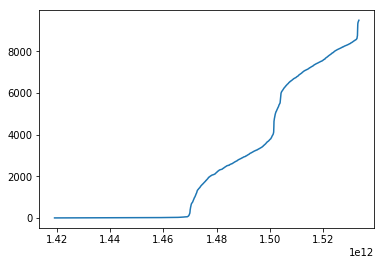

In [6]:
plt.plot(df['commentTime'],df['commentCount']);

提取年月日。此图横坐标不是按照每日连续绘制的，而是按照数据中出现的日期前后排布的，由后面带横坐标的 pyecharts 的曲线图可以验证。

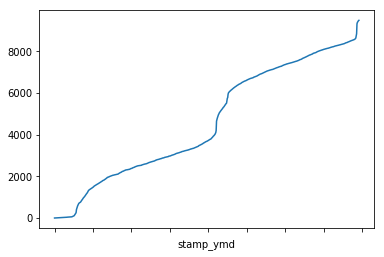

In [7]:
# stamp
def ymd(stamp):
    return stamp.split(' ')[0]
df['stamp_ymd'] = df['stamp'].apply(ymd)
df.groupby('stamp_ymd')['commentCount'].max().plot();

日评论数变化情况，两个极大的峰突破400，三个稍大的峰（有两个有重合，不好分辨，结合后面图表可确认）突破100

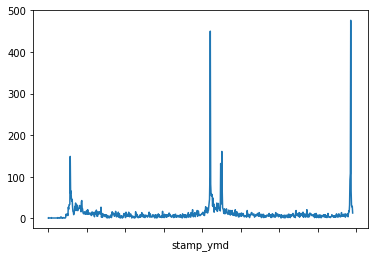

In [8]:
df.groupby('stamp_ymd')['commentCount'].count().plot();

同一图表的另一种数据处理方法。设置 stamp_ymd 为 index 索引

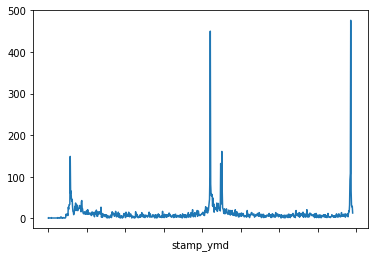

In [9]:
df_stamp = df[['stamp_ymd', 'commentCount']]
df_stamp.set_index("stamp_ymd", inplace=True)
df_stamp.groupby('stamp_ymd')['commentCount'].count().plot();

### pyecharts 之 评论数变化情况
`pip install pyecharts`   
[pyecharts/pyecharts](https://github.com/pyecharts/pyecharts)   
[pyecharts-users-cases/notebook-user-cases.ipynb](https://github.com/pyecharts/pyecharts-users-cases/blob/master/notebook-users-cases/notebook-user-cases.ipynb)  
echarts 自带 dark 主题， pyecharts 也就自带了 dark。 echarts-themes-pypkg 提供了 vintage, macarons, infographic, shine 和 roma 主题。  
安装主题插件：`pip install echarts-themes-pypkg`

[pyecharts 图表配置](http://pyecharts.org/#/zh-cn/charts)  
[数据可视化工具库-pyecharts](https://mp.weixin.qq.com/s/HAkrrTX0K-qxG-6XIlbaaA)  
图表详细
- Bar（柱状图/条形图）/ Bar3D（3D 柱状图）/ Boxplot（箱形图）/ EffectScatter（带有涟漪特效动画的散点图）/ Funnel（漏斗图）
- Gauge（仪表盘）/ Geo（地理坐标系）/ Graph（关系图）/ HeatMap（热力图）/ Kline（K线图）/ Line（折线/面积图）/ Line3D（3D 折线图） 
- Liquid（水球图）/ Map（地图）/ Parallel（平行坐标系）/ Pie（饼图）/ Polar（极坐标系）/ Radar（雷达图）/ Sankey（桑基图） 
- Scatter（散点图）/ Scatter3D（3D 散点图）/ ThemeRiver（主题河流图）/ WordCloud（词云图） 

### 每日评论数变化情况
注意开源后，可能 pyecharts 图表部分都显示不出来，需要 download 后自行运行代码才可查看，后者查看本代码的 html 版

In [10]:
df_stampcount = df_stamp.groupby('stamp_ymd')['commentCount'].count()
from pyecharts import Line
line = Line("每日评论数变化情况")
line.add("日期", df_stampcount.index, df_stampcount.values,line_opacity=1,line_type='dotted')
line

### 评论数增长情况

In [11]:
df_stampmax = df_stamp.groupby('stamp_ymd')['commentCount'].max()
line = Line("评论数增长情况")
line.add("日期", df_stampmax.index, df_stampmax.values,line_opacity=1,line_type='dotted')
line

### 评论数Top20日期

In [12]:
top_day = df_stampcount.sort_values(ascending=False)[:20]
top_day

stamp_ymd
2018-08-01    476
2017-08-01    450
2017-08-31    161
2016-08-01    149
2017-08-28    132
2018-07-31    108
2017-07-31    102
2017-08-29    100
2018-07-30     93
2017-08-02     82
2017-09-01     67
2018-08-02     66
2016-08-03     66
2016-08-02     60
2017-08-03     60
2017-08-05     58
2017-08-06     56
2017-08-04     54
2017-08-08     49
2016-08-04     48
Name: commentCount, dtype: int64

`xaxis_interval`
- x 轴刻度标签的显示间隔，在类目轴中有效。默认会采用标签不重叠的策略间隔显示标签。
- 设置成 0 强制显示所有标签。设置为 1，表示『隔一个标签显示一个标签』，如果值为 2，表示隔两个标签显示一个标签，以此类推

In [13]:
from pyecharts import Bar
bar = Bar("评论数Top20日期")
bar.add("日期", top_day.index, top_day.values,is_label_show=True,xaxis_interval=0,xaxis_rotate=-45)
bar

## 词不达意之 emoji 
在日常的网上聊天或评论区，emoji 表情是许多人所熟悉并频繁使用的一大“神兵利器”。较之文字的歧义性与表达的局限性，emoji 有着直观、魔性、好玩等诸多特性。

同样的在《八月》这首歌底下也有诸多听友留下的 emoji 表情，因而本回也对近万条评论里所有出现的过的 emoji 进行了统计。

### emoji 爬虫
[网易数读：《周杰伦这首200万评论的歌曲，有每个人的青春》](http://news.163.com/18/0118/20/D8F9K6R6000181IU.html)   

In [ ]:
import time
import urllib.request
import random

filename = "images/emoji"
for num in range(1000):
    try:
        url = 'http://s1.music.126.net/style/web2/emt/emoji_{}.png'.format(num)
        path = filename + "/" + "emoji_{}.png".format(num)
        urllib.request.urlretrieve(url, path)
        print(num, url)
        #if i/20:
        #    time.sleep(random.randint(0,1)) # 放缓爬取速度
    except:
        print('Error {}'.format(num))

网易云音乐的评论里支持60种 emoji 表情
<img src='images/emojis_60.png'>  
[正则表达式中匹配字符中括号`[]`](https://blog.csdn.net/zjm750617105/article/details/50720846)  

In [14]:
import re
s = '最适合无聊的夏天无聊的我听[吐舌][色][亲亲]，近一月听到的最佳[赞]（一积分悬赏歌词）[大笑]'
pattern =re.compile(u"\[[\u4e00-\u9fa5]+\]") # [\u4e00-\u9fa5]+ 匹配中文 # \[ \] # 分别匹配左右中括号
result=re.findall(pattern,s)
print(result)

['[吐舌]', '[色]', '[亲亲]', '[赞]', '[大笑]']


In [15]:
def find_emoji(comment):
    pattern =re.compile(u"\[[\u4e00-\u9fa5]+\]")
    result=re.findall(pattern,comment)
    return result
df['emojis_list'] = df['comment'].apply(find_emoji)
df.head(2)

Unnamed: 0  No  page     userID      nickname  \
0           0   1     1  346392120          仙谛瑞拉   
1           1   2     1  445313261  锤基拔杯GGAD福华亚梅   

                        comment    commentTime                stamp  \
0           有 然后我会以千百万种方式将你救回来.  1533550956926  2018-08-06 18:22:36   
1  我以为是个成熟的阿姨在唱歌，歌手居然是个大胡子叔叔？？？  1533550458107  2018-08-06 18:14:18   

   likedCount  location     ...       remarkName  \
0           0       NaN     ...              NaN   
1           0       NaN     ...              NaN   

                                           beReplied pendantData  \
0  [{'user': {'locationInfo': None, 'remarkName':...         NaN   
1                                                 []         NaN   

   expressionUrl  liked   commentId  isRemoveHotComment commentCount  \
0            NaN  False  1206471392               False         9489   
1            NaN  False  1206481007               False         9488   

    stamp_ymd  emojis_list  
0  2018-08-06           []  
1  2018-08-06           []  

[2 rows x 26 columns]

In [16]:
emojis_list = df['emojis_list'].values.tolist()
emojis_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['[大笑]'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['[大哭]'],
 [],
 [],
 [],
 [],
 ['[公鸡]',
  '[幽灵]',
  '[圣诞]',
  '[外星]',
  '[钻石]',
  '[礼物]',
  '[男孩]',
  '[女孩]',
  '[蛋糕]',
  '[圈]',
  '[叉]'],
 ['[大笑]',
  '[可爱]',
  '[憨笑]',
  '[色]',
  '[亲亲]',
  '[惊恐]',
  '[流泪]',
  '[亲]',
  '[呆]',
  '[哀伤]',
  '[呲牙]',
  '[吐舌]',
  '[撇嘴]',
  '[怒]',
  '[奸笑]',
  '[汗]',
  '[痛苦]',
  '[惶恐]',
  '[生病]',
  '[口罩]',
  '[大哭]',
  '[晕]',
  '[发怒]',
  '[开心]',
  '[鬼脸]',
  '[皱眉]',
  '[流感]',
  '[爱心]',
  '[心碎]',
  '[钟情]',
  '[星星]',
  '[生气]',
  '[便便]',
  '[强]',
  '[弱]',
  '[拜]',
  '[牵手]',
  '[跳舞]',
  '[禁止]',
  '[这边]',
  '[爱意]',
  '[示爱]',
  '[嘴唇]',
  '[狗]',
  '[猫]',
  '[猪]',
  '[兔子]',
  '[小鸡]'],
 [],
 [],
 [],
 ['[憨笑]'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['[爱心]'],
 [],
 [],
 [],
 [],
 [],
 []

In [17]:
emojis_drop = [emoji for emoji in emojis_list if len(emoji)!=0]
emojis_drop

[['[大笑]'],
 ['[大哭]'],
 ['[公鸡]',
  '[幽灵]',
  '[圣诞]',
  '[外星]',
  '[钻石]',
  '[礼物]',
  '[男孩]',
  '[女孩]',
  '[蛋糕]',
  '[圈]',
  '[叉]'],
 ['[大笑]',
  '[可爱]',
  '[憨笑]',
  '[色]',
  '[亲亲]',
  '[惊恐]',
  '[流泪]',
  '[亲]',
  '[呆]',
  '[哀伤]',
  '[呲牙]',
  '[吐舌]',
  '[撇嘴]',
  '[怒]',
  '[奸笑]',
  '[汗]',
  '[痛苦]',
  '[惶恐]',
  '[生病]',
  '[口罩]',
  '[大哭]',
  '[晕]',
  '[发怒]',
  '[开心]',
  '[鬼脸]',
  '[皱眉]',
  '[流感]',
  '[爱心]',
  '[心碎]',
  '[钟情]',
  '[星星]',
  '[生气]',
  '[便便]',
  '[强]',
  '[弱]',
  '[拜]',
  '[牵手]',
  '[跳舞]',
  '[禁止]',
  '[这边]',
  '[爱意]',
  '[示爱]',
  '[嘴唇]',
  '[狗]',
  '[猫]',
  '[猪]',
  '[兔子]',
  '[小鸡]'],
 ['[憨笑]'],
 ['[爱心]'],
 ['[可爱]'],
 ['[可爱]'],
 ['[爱心]'],
 ['[大笑]', '[大笑]', '[大笑]'],
 ['[可爱]'],
 ['[星星]'],
 ['[拜]'],
 ['[呲牙]'],
 ['[憨笑]'],
 ['[可爱]'],
 ['[大哭]'],
 ['[星星]'],
 ['[跳舞]'],
 ['[痛苦]', '[痛苦]', '[痛苦]'],
 ['[爱心]'],
 ['[流泪]'],
 ['[星星]'],
 ['[大哭]'],
 ['[皱眉]'],
 ['[憨笑]'],
 ['[拜]'],
 ['[拜]'],
 ['[爱心]'],
 ['[爱心]', '[爱心]'],
 ['[流泪]', '[流泪]', '[流泪]'],
 ['[憨笑]'],
 ['[钟情]'],
 ['[大哭]'],
 ['[月亮]'],
 ['[爱心

In [18]:
emojis_droplist = sum(emojis_drop, [])
print(len(emojis_droplist))
print(emojis_droplist)

1722
['[大笑]', '[大哭]', '[公鸡]', '[幽灵]', '[圣诞]', '[外星]', '[钻石]', '[礼物]', '[男孩]', '[女孩]', '[蛋糕]', '[圈]', '[叉]', '[大笑]', '[可爱]', '[憨笑]', '[色]', '[亲亲]', '[惊恐]', '[流泪]', '[亲]', '[呆]', '[哀伤]', '[呲牙]', '[吐舌]', '[撇嘴]', '[怒]', '[奸笑]', '[汗]', '[痛苦]', '[惶恐]', '[生病]', '[口罩]', '[大哭]', '[晕]', '[发怒]', '[开心]', '[鬼脸]', '[皱眉]', '[流感]', '[爱心]', '[心碎]', '[钟情]', '[星星]', '[生气]', '[便便]', '[强]', '[弱]', '[拜]', '[牵手]', '[跳舞]', '[禁止]', '[这边]', '[爱意]', '[示爱]', '[嘴唇]', '[狗]', '[猫]', '[猪]', '[兔子]', '[小鸡]', '[憨笑]', '[爱心]', '[可爱]', '[可爱]', '[爱心]', '[大笑]', '[大笑]', '[大笑]', '[可爱]', '[星星]', '[拜]', '[呲牙]', '[憨笑]', '[可爱]', '[大哭]', '[星星]', '[跳舞]', '[痛苦]', '[痛苦]', '[痛苦]', '[爱心]', '[流泪]', '[星星]', '[大哭]', '[皱眉]', '[憨笑]', '[拜]', '[拜]', '[爱心]', '[爱心]', '[爱心]', '[流泪]', '[流泪]', '[流泪]', '[憨笑]', '[钟情]', '[大哭]', '[月亮]', '[爱心]', '[憨笑]', '[吐舌]', '[大哭]', '[爱心]', '[呲牙]', '[大笑]', '[心碎]', '[爱心]', '[大笑]', '[爱心]', '[爱心]', '[爱心]', '[心碎]', '[爱心]', '[憨笑]', '[心碎]', '[爱心]', '[爱心]', '[憨笑]', '[爱心]', '[可爱]', '[可爱]', '[可爱]', '[爱心]', '[憨笑]', '[憨笑]', '[哀

In [19]:
emojis_dropset = set(emojis_droplist)
print(len(emojis_dropset))
print(emojis_dropset)

62
{'[亲]', '[生病]', '[撇嘴]', '[汗]', '[哀伤]', '[呲牙]', '[鬼脸]', '[兔子]', '[心碎]', '[拜]', '[怒]', '[男孩]', '[牵手]', '[大笑]', '[八月]', '[弱]', '[惶恐]', '[流感]', '[狗]', '[奸笑]', '[幽灵]', '[假装看不到桌上成堆的作业]', '[礼物]', '[可爱]', '[惊恐]', '[猪]', '[晕]', '[痛苦]', '[口罩]', '[流泪]', '[生气]', '[跳舞]', '[皱眉]', '[公鸡]', '[示爱]', '[强]', '[色]', '[呆]', '[爱心]', '[月亮]', '[女孩]', '[爱意]', '[发怒]', '[开心]', '[嘴唇]', '[亲亲]', '[叉]', '[蛋糕]', '[星星]', '[吐舌]', '[钟情]', '[小鸡]', '[圈]', '[大哭]', '[禁止]', '[这边]', '[钻石]', '[猫]', '[圣诞]', '[便便]', '[憨笑]', '[外星]'}


 `'[假装看不到桌上成堆的作业]'/ '[八月]'` 不是 emoji 表情，而且有人用了中括号，从而被提取出来了。 不过要是真有`'[假装看不到桌上成堆的作业]'`这个 emoji 表情估计也蛮好玩的，就等大佬开脑洞做一个 emoji   
 
另外看到60个 emoji 都被用到了，你会不会觉得很神奇？真相是为了找出每个 emoji 表情与含义的对应关系（当然 emoji 大师可以猜猜，答案将稍后揭晓），我在评论区手动输出了所有 emoji ，也是算是在挖掘这首歌的过程中，留下个印记吧，2333。
 <img src='images/emojis_test.jpg'>   

 
[《利用Python进行数据分析·第2版》第14章 数据分析案例](https://www.jianshu.com/p/72b6c83bb69e)   

### emoji 使用情况

In [20]:
print(len(emojis_droplist))
emojis_droplist.remove('[假装看不到桌上成堆的作业]')
emojis_droplist.remove('[八月]')
print(len(emojis_droplist))
from collections import Counter
counter = Counter()
for emoji in emojis_droplist:
    counter[emoji] += 1
print(len(counter))
print(counter.most_common())
y_emojis = []
x_count = []
for emoji, count in counter.most_common():
    y_emojis.append(emoji)
    x_count.append(count)

1722
1720
60
[('[爱心]', 219), ('[大哭]', 179), ('[可爱]', 161), ('[憨笑]', 122), ('[大笑]', 121), ('[流泪]', 111), ('[哀伤]', 85), ('[呆]', 67), ('[星星]', 52), ('[拜]', 48), ('[呲牙]', 46), ('[亲亲]', 44), ('[心碎]', 35), ('[惊恐]', 32), ('[奸笑]', 30), ('[色]', 29), ('[强]', 27), ('[吐舌]', 26), ('[皱眉]', 24), ('[撇嘴]', 21), ('[痛苦]', 17), ('[口罩]', 17), ('[汗]', 16), ('[钟情]', 16), ('[圈]', 10), ('[惶恐]', 10), ('[开心]', 10), ('[跳舞]', 10), ('[猪]', 10), ('[兔子]', 10), ('[鬼脸]', 9), ('[蛋糕]', 8), ('[流感]', 8), ('[幽灵]', 7), ('[狗]', 7), ('[叉]', 6), ('[亲]', 6), ('[生病]', 6), ('[猫]', 6), ('[晕]', 5), ('[便便]', 5), ('[男孩]', 4), ('[发怒]', 4), ('[小鸡]', 4), ('[公鸡]', 3), ('[女孩]', 3), ('[怒]', 3), ('[牵手]', 3), ('[圣诞]', 2), ('[外星]', 2), ('[生气]', 2), ('[禁止]', 2), ('[这边]', 2), ('[示爱]', 2), ('[钻石]', 1), ('[礼物]', 1), ('[弱]', 1), ('[爱意]', 1), ('[嘴唇]', 1), ('[月亮]', 1)]


### emoji 表情与含义对应关系
<img src='images/emojis_test.jpg'>   
"[公鸡][幽灵][圣诞][外星][钻石][礼物]   
[男孩][女孩][蛋糕][18][圈][叉]   
表情包测试..."

"[大笑][可爱][憨笑][色][亲亲][惊恐][流泪]   
[亲][呆][哀伤][呲牙][吐舌][撇嘴][怒]  
[奸笑][汗][痛苦][惶恐][生病][口罩][大哭]   
[晕][发怒][开心][鬼脸][皱眉][流感]   
[爱心][心碎][钟情][星星][生气][便便][强]   
[弱][拜][牵手][跳舞][禁止][这边][爱意]  
[示爱][嘴唇][狗][猫][猪][兔子][小鸡]"   
  
[年轻人，Emoji是这样控制了你的](https://www.huxiu.com/article/163386.html)    
[Emoji的编码以及常见问题处理](https://segmentfault.com/a/1190000007594620)   
[研究说，经常使用Emoji的人群性生活次数比较多](http://www.bast.net.cn/art/2018/7/31/art_16694_386110.html)   
[「高能科普」从ASCII码再到emoji，关于表情包的发展史你了解多少?](http://www.orz520.com/a/it/2018/0801/15236393.html?from=haosou)   

### seaborn
更改 figure_size 尺寸，但图片大小还是不变，不知何故，另外纵坐标标签展示的不太好。弃之。
[seaborn-examples](http://seaborn.pydata.org/examples/index.html)  

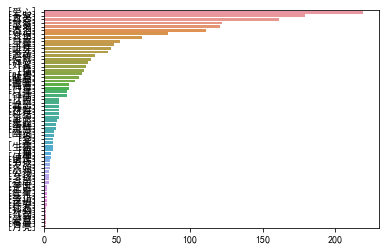

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12)) # 设置 figure_size尺寸 # 更改后还是呈现的图片大小还是不变，不知何故
plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
import seaborn as sns
%matplotlib inline
sns.barplot(x=x_count, y=y_emojis);

### pyecharts 之 emoji 使用情况

In [22]:
from pyecharts import Bar
bar = Bar("emoji 使用情况")
bar.add("emoji", y_emojis, x_count, is_stack=True,is_label_show=True,xaxis_interval=0,xaxis_rotate=-90,xaxis_margin=8)
bar

### Top10 emoji

In [23]:
from pyecharts import Bar
bar = Bar("Top10 emoji")
bar.add("emoji", y_emojis[:10], x_count[:10], is_stack=True)
bar

在 excel 里手动将对应 emoji 添加上去后，更为直观   
<img src='images/Top10_emojis_combine.png'>

## （emoji 分布情况之 sns.stripplot）
曾经看到过 NLTK 里可以绘制词语在文本中分布情况的图表，如下面的例子： 
[Source code for nltk.draw.dispersion](https://www.nltk.org/_modules/nltk/draw/dispersion.html)  
NLTK 3.3 documentation
<img src='images/nltk_dispersion.png'>

**sns.stripplot**
[Lexical dispersion plot is seaborn](https://stackoverflow.com/questions/43771135/lexical-dispersion-plot-is-seaborn)  
<img src='images/sns_stripplot.png'>

[3 分类变量的绘图](https://www.jianshu.com/p/316506208550)  
[seaborn.stripplot](http://seaborn.pydata.org/generated/seaborn.stripplot.html)  
[Seaborn绘图](https://blog.csdn.net/u013082989/article/details/73278458)  

### 仅供参考
尝试下能否绘制出 emoji 的分布情况，但感觉可视化的图不太靠谱，此部分相关代码，仅供参考，暂不删除：  
`[('[爱心]', 217), ('[大哭]', 179), ('[可爱]', 160), ('[憨笑]', 120), ('[大笑]', 119), ('[流泪]', 110), ('[哀伤]', 84), ('[呆]', 66), ('[星星]', 51), ('[拜]', 47)]`

### emoji 布尔值
判断是否为某表情的正确写法
#### '[爱心]' 错误版
**注意：'[可爱]' '[爱心]' '[心碎]' '[开心]'  都被筛选出来了**，所以此处是错误的示范，后面有正确版

In [ ]:
df['emoji_bool_star_2'] = df['emojis_str'].str.contains('\[爱心\]')
df['emoji_bool_star_2'].value_counts()

In [151]:
df[['No','stamp','comment','emojis_str','emoji_bool_star_2']][df['emoji_bool_star_2'] == True]

No                stamp  \
34      35  2018-08-05 11:16:49   
75      76  2018-08-03 22:10:41   
126    127  2018-08-02 16:37:10   
252    253  2018-08-01 12:54:53   
316    317  2018-08-01 09:12:05   
334    335  2018-08-01 08:34:45   
436    437  2018-08-01 04:48:15   
493    494  2018-08-01 01:07:05   
538    539  2018-08-01 00:36:47   
551    552  2018-08-01 00:29:36   
568    569  2018-08-01 00:21:44   
581    582  2018-08-01 00:18:46   
599    600  2018-08-01 00:09:41   
619    620  2018-08-01 00:04:07   
671    672  2018-07-31 23:00:45   
983    984  2018-07-17 01:09:50   
1052  1053  2018-07-08 14:08:14   
1078  1079  2018-07-04 16:39:11   
1221  1222  2018-06-10 15:17:01   
1259  1260  2018-06-02 00:14:20   
1351  1352  2018-05-15 23:15:57   
1388  1389  2018-05-08 21:03:47   
1424  1425  2018-05-03 08:31:20   
1453  1454  2018-04-28 08:05:29   
1454  1455  2018-04-28 08:04:42   
1575  1576  2018-04-12 21:22:07   
1698  1699  2018-03-28 13:14:33   
1761  1762  2018-03-21 14:07:14   
1879  1880  2018-03-08 17:55:10   
1968  1969  2018-02-23 17:49:41   
...    ...                  ...   
8070  8071  2016-09-09 11:44:27   
8093  8094  2016-09-07 14:16:10   
8095  8096  2016-09-07 12:58:35   
8120  8121  2016-09-05 22:02:09   
8168  8169  2016-09-02 10:13:34   
8224  8225  2016-08-31 12:28:11   
8243  8244  2016-08-31 00:03:29   
8280  8281  2016-08-30 10:27:12   
8345  8346  2016-08-27 09:05:06   
8399  8400  2016-08-25 10:23:58   
8461  8462  2016-08-22 23:35:45   
8512  8513  2016-08-20 13:28:23   
8550  8551  2016-08-19 01:36:45   
8704  8705  2016-08-13 09:49:50   
8744  8745  2016-08-11 11:12:36   
8823  8824  2016-08-06 22:06:11   
8849  8850  2016-08-06 10:12:12   
8867  8868  2016-08-05 21:57:39   
8880  8881  2016-08-05 10:31:12   
8884  8885  2016-08-05 09:53:16   
8955  8956  2016-08-03 23:36:32   
8965  8966  2016-08-03 21:23:38   
9031  9032  2016-08-02 21:31:58   
9156  9157  2016-08-01 09:09:01   
9191  9192  2016-08-01 01:06:42   
9216  9217  2016-08-01 00:19:31   
9239  9240  2016-07-31 22:01:49   
9254  9255  2016-07-31 09:45:43   
9277  9278  2016-07-30 16:07:35   
9325  9326  2016-07-29 09:36:52   

                                                comment  \
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
75                                          八月 会变好的[爱心]   
126                          在一起八个月了 一起加油吧 愿我们被温柔眷顾[爱心]   
252                                     小朋友 希望你八月长安[爱心]   
316                                    这个八月会好的，你也一样[爱心]   
334   记得五年前的那个八月，我们还笨拙的不会用微信互通简讯，高考后蝉鸣响彻的夏天，傻傻却坚持着用手...   
436                              八月 感谢以往几个月的努力。感谢遇见[爱心]   
493                                  八月 请善待我身边的每一个人[爱心]   
538                                    七月，再见。八月，你好！[爱心]   
551            你好，八月[爱心]        愿[爱心] 君の名を知った 君と笑った[爱心]   
568   去年的8月 我们的感情到此结束… 很遗憾[心碎] 2018 .8月 请对我好点 我仍然对爱情...   
581   去年的8月 我们的感情到此结束… 很遗憾[心碎] 2018 .8月 请对我好点[爱心] 我仍...   
599                                      8月 请对我好一点 [爱心]   
619   现在凌晨00:02 八月份就来了 喜欢的人应该睡了 虽然不能守护 也不能陪伴 也不能在一起 ...   
671                            8月对我好一点吧[爱心]希望实习的日子顺利一点吧   
983                                           嗯嗯，谢谢[爱心]   
1052                      没关系的 你的内心永远是你的 不会有任何人窥探  [爱心]   
1078  发现越长大越容易感动 被一首歌感动 一本书感动 一个电影感动 刚刚看完《海街日记》， 再听到...   
1221                                        声音太少年了吧[爱心]   
1259                                           谢谢啦啊[爱心]   
1351                                   @江南阴天 所以，刚刚好[爱心]   
1388                                         再见你，八月[爱心]   
1424                                         第301次听[爱心]   
1453                                     我们都爱你呀，要勇敢[爱心]   
1454                                      我们都爱你，要勇敢[爱心]   
1575                                       [爱心][爱心][爱心]   
1698                                               [爱心]   
1761                                               [爱心]   
1879                              不知道火土有没有在听这首歌[爱心][爱心]   
1968                                    喜欢八月,很美的旋律啊[爱心]   
...     

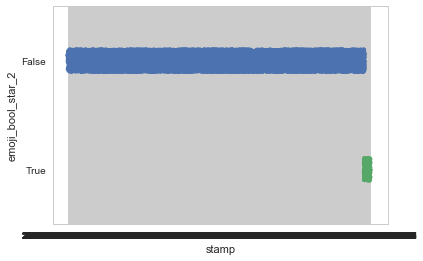

In [20]:
sns.stripplot(x="stamp", y="emoji_bool_star_2", data=df, orient='h',jitter=True); # , marker='X', color='navy', size=5

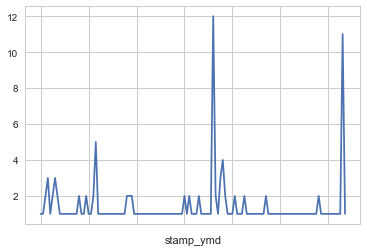

In [48]:
df_emoji_bool = df[df['emoji_bool_star_2'] == True]
df_emoji_bool.groupby('stamp_ymd')['emoji_bool_star_2'].count().plot(); # 'stamp_ymd' 'commentCount' # 均是后面评论部分处理生成的

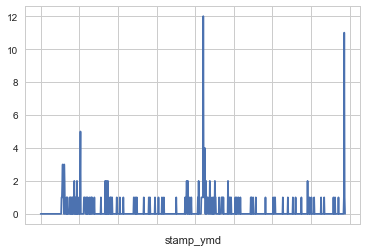

In [52]:
#df_emoji_bool = df[df['emoji_bool_star_2'] == True]
df.groupby('stamp_ymd')['emoji_bool_star_2'].sum().plot(); # 'stamp_ymd' 'commentCount' # 均是后面评论部分处理生成的

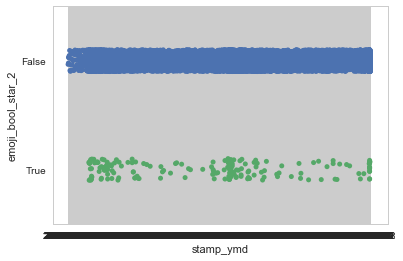

In [53]:
sns.stripplot(x="stamp_ymd", y="emoji_bool_star_2", data=df, orient='h',jitter=True); # , marker='X', color='navy', size=5

## （回复评论）
互相回复评论的内容，有助于增进对单一评论的理解。不过本回没有提取这部分信息。

In [69]:
df['beReplied'].sort_values(ascending=False)[:20]

6419    [{'user': {'locationInfo': None, 'vipType': 11...
765     [{'user': {'locationInfo': None, 'vipType': 11...
6193    [{'user': {'locationInfo': None, 'vipType': 11...
7124    [{'user': {'locationInfo': None, 'vipType': 11...
7134    [{'user': {'locationInfo': None, 'vipType': 11...
6185    [{'user': {'locationInfo': None, 'vipType': 11...
6188    [{'user': {'locationInfo': None, 'vipType': 11...
5041    [{'user': {'locationInfo': None, 'vipType': 11...
3255    [{'user': {'locationInfo': None, 'vipType': 11...
2893    [{'user': {'locationInfo': None, 'vipType': 11...
4688    [{'user': {'locationInfo': None, 'vipType': 11...
8580    [{'user': {'locationInfo': None, 'vipType': 11...
6936    [{'user': {'locationInfo': None, 'vipType': 11...
6930    [{'user': {'locationInfo': None, 'vipType': 11...
6522    [{'user': {'locationInfo': None, 'vipType': 11...
6530    [{'user': {'locationInfo': None, 'vipType': 11...
6526    [{'user': {'locationInfo': None, 'vipType': 11...
6524    [{'use

In [63]:
df.loc[3889,'beReplied']

"[{'user': {'locationInfo': None, 'vipType': 11, 'userType': 0, 'userId': 70489255, 'nickname': 'LaboHamal', 'expertTags': None, 'authStatus': 0, 'remarkName': None, 'avatarUrl': 'http://p1.music.126.net/FF-HKphRFVvcQvrMF9-vuQ==/2909307769008893.jpg', 'experts': None}, 'content': None, 'status': -5, 'expressionUrl': None}]"

In [66]:
df.loc[3889,:]

Unnamed: 0                                                           3889
No                                                                   3890
page                                                                    1
userID                                                          125879957
nickname                                                              宴石寺
comment                                                        😁2017年8月末了
commentTime                                                 1503894430463
stamp                                                 2017-08-28 12:27:10
likedCount                                                              0
location                                                              NaN
userType                                                                0
vipType                                                                 0
expertTags                                                            NaN
experts                               

## Top emoji 相关评论内容的词云
####  统计高频词 
为后面每个 emoji 相关的评论的词云图服务

In [27]:
import warnings
warnings.filterwarnings("ignore")
import jieba
import numpy as np
import codecs
import pandas as pd  
import matplotlib.pyplot as plt
%matplotlib inline

def wordsstat(column_name):
    content = sum(df[['comment']][df[column_name] == True].values.tolist(), [])
    print(len(content))

    segment = []
    for line in content:
        try:
            segs = jieba.lcut(line)
            for seg in segs:
                if len(seg)>1 and seg != '\r\n':
                    segment.append(seg)
        except:
            print(line)
            continue

    # 去停用词
    words_df = pd.DataFrame({"segment": segment})
    stopwords_df = pd.read_csv('Chinese_Stopwords.txt',index_col=False, quoting=3,sep="\t",names=['stopwords'], encoding='utf-8') #quoting=3全不引用
    words_df = words_df[~words_df.segment.isin(stopwords_df.stopwords)]

    # 统计词频
    words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数": np.size})
    words_stat = words_stat.reset_index().sort_values(by=["计数"], ascending=False)
    return words_stat

`[('[爱心]', 217), ('[大哭]', 179), ('[可爱]', 160), ('[憨笑]', 120), ('[大笑]', 119), ('[流泪]', 110)]`    
[pandas.Series.str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html)  
regex 参数默认是 False, 改成 True 后前面的就不是字符串而是正则提取规则
- regex : bool, default True
- If True, assumes the pat is a regular expression.
- If False, treats the pat as a literal string. 

`s1.str.contains('house|parrot', regex=True)`

#### '[可爱]'
正确版写法

In [29]:
df['emoji_bool_cute'] = df['emojis_str'].str.contains('\[可爱\]')
#df['emoji_bool_cute'].value_counts()
df[['No','stamp','comment','emojis_str','emoji_bool_cute']][df['emoji_bool_cute'] == True]

No                stamp  \
34      35  2018-08-05 11:16:49   
110    111  2018-08-02 22:09:19   
113    114  2018-08-02 21:53:35   
137    138  2018-08-02 13:00:55   
213    214  2018-08-01 19:29:45   
644    645  2018-07-31 23:59:59   
667    668  2018-07-31 23:09:52   
905    906  2018-07-27 10:25:08   
957    958  2018-07-20 17:03:01   
1013  1014  2018-07-13 21:37:11   
1019  1020  2018-07-12 19:55:51   
1094  1095  2018-07-02 13:52:10   
1118  1119  2018-06-29 21:07:56   
1199  1200  2018-06-14 09:33:37   
1302  1303  2018-05-24 20:59:56   
1317  1318  2018-05-22 19:20:09   
1331  1332  2018-05-20 01:21:10   
1344  1345  2018-05-18 07:20:43   
1390  1391  2018-05-08 00:07:40   
1488  1489  2018-04-22 21:47:44   
1589  1590  2018-04-09 21:27:12   
1631  1632  2018-04-05 18:51:50   
1680  1681  2018-03-30 13:42:12   
1765  1766  2018-03-20 23:19:14   
1834  1835  2018-03-12 23:43:01   
1845  1846  2018-03-12 13:02:35   
1886  1887  2018-03-06 23:27:22   
1933  1934  2018-03-01 22:50:08   
1949  1950  2018-02-27 04:12:21   
1980  1981  2018-02-21 21:49:00   
...    ...                  ...   
7782  7783  2016-10-01 23:18:02   
8014  8015  2016-09-13 21:25:50   
8128  8129  2016-09-04 21:19:01   
8161  8162  2016-09-02 14:04:56   
8217  8218  2016-08-31 19:38:48   
8226  8227  2016-08-31 11:38:01   
8255  8256  2016-08-30 21:57:53   
8351  8352  2016-08-26 23:53:41   
8490  8491  2016-08-21 21:52:48   
8506  8507  2016-08-20 22:45:33   
8524  8525  2016-08-19 22:14:52   
8655  8656  2016-08-15 09:37:08   
8662  8663  2016-08-15 02:12:25   
8688  8689  2016-08-13 22:27:18   
8721  8722  2016-08-12 22:43:10   
8796  8797  2016-08-07 19:28:50   
8826  8827  2016-08-06 21:18:58   
8866  8867  2016-08-05 22:31:12   
8886  8887  2016-08-05 09:22:50   
9014  9015  2016-08-03 01:16:15   
9028  9029  2016-08-02 22:12:10   
9044  9045  2016-08-02 17:04:31   
9111  9112  2016-08-01 18:15:52   
9116  9117  2016-08-01 16:10:33   
9119  9120  2016-08-01 14:50:03   
9183  9184  2016-08-01 02:42:55   
9354  9355  2016-07-27 22:35:20   
9440  9441  2016-07-09 19:58:13   
9446  9447  2016-07-05 11:43:10   
9455  9456  2016-06-21 14:11:52   

                                                comment  \
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
110                                                [可爱]   
113                                            生日快乐[可爱]   
137                                             [可爱]会好的   
213                                           八月，你好[可爱]   
644                                          八月第一个！[可爱]   
667   明天就是八月了，我也快到18岁了，今年是我人生最精彩的一年，遇到了很多美好的人和事物，希望每...   
905                                  希望你的这段话会在日后激励我[可爱]   
957                                                [可爱]   
1013  有八千多个评论，那就是说有那么多人和我一样喜欢这首歌呢！想到这些心情好像稍微好一点了[可爱]...   
1019                                       哎哟喂这男声要醉[可爱]   
1094                             在八月即将到来之际与你道别，望安好。[可爱]   
1118                                             日推[可爱]   
1199                       每次遇到困难都来这里诉诉苦吧 擦干眼泪继续前行！[可爱]   
1302                                这么好听的歌，一定要留下足迹[可爱]。   
1317                                             嗯呐[可爱]   
1331                                七月底放假，八月就可以见到她了[可爱]   
1344                                         都还20多啦[可爱]   
1390              好久没听日推了，今日一听每首都红心，真好[可爱]希望五月也像这样顺心一点吧   
1488            上次看的时候还没有歌词呢，悬赏了我宝贵的五积分啊，真是太感谢了[可爱][可爱]   
1589                                             嗯嗯[可爱]   
1631                                  发现一首好歌  开心的一天[可爱]   
1680                                           谢谢你啊[可爱]   
1765                                     感谢亲爱的 同样举报[可爱]   
1834                                    初中最后几个月，加油![可爱]   
1845                        去年八月似乎确定喜欢你，今年八月就要等着忘记你[可爱]   
1886                 喜欢日语歌的朋友不妨听听我的歌单，会带给你不一样的惊喜与感动[可爱]   
1933                                             日推[可爱]   
1949                                               [可爱]   
1980                   广大的网友们，谁有这首歌的吉他琴谱。能给个链接吗？蟹蟹哦[可爱]   
...     

In [31]:
from pyecharts import WordCloud
wordcloud = WordCloud(width=800, height=520)
words_stat = wordsstat('emoji_bool_cute')
wordcloud.add("含可爱 emoji 的评论所生成的词云", words_stat['segment'], words_stat['计数'], word_size_range=[20, 100])
wordcloud

148


#### '[憨笑]'

In [32]:
df['emoji_bool_foolsmile'] = df['emojis_str'].str.contains('\[憨笑\]')
#df['emoji_bool_foolsmile'].value_counts()
df[['No','stamp','comment','emojis_str','emoji_bool_foolsmile']][df['emoji_bool_foolsmile'] == True]

No                stamp  \
34      35  2018-08-05 11:16:49   
38      39  2018-08-05 08:24:47   
212    213  2018-08-01 19:38:46   
304    305  2018-08-01 09:22:01   
370    371  2018-08-01 07:49:20   
440    441  2018-08-01 03:13:44   
573    574  2018-08-01 00:20:36   
618    619  2018-08-01 00:04:11   
706    707  2018-07-31 19:40:13   
722    723  2018-07-31 14:34:26   
849    850  2018-07-29 23:55:45   
944    945  2018-07-22 23:43:38   
962    963  2018-07-20 12:45:15   
1059  1060  2018-07-08 01:53:13   
1257  1258  2018-06-02 08:18:22   
1261  1262  2018-06-02 00:05:13   
1529  1530  2018-04-18 15:20:15   
1536  1537  2018-04-17 22:06:43   
1612  1613  2018-04-08 18:25:48   
1645  1646  2018-04-03 23:48:46   
1803  1804  2018-03-16 13:02:28   
1995  1996  2018-02-19 02:08:35   
2162  2163  2018-01-22 02:34:56   
2466  2467  2017-12-07 11:16:37   
2698  2699  2017-11-10 21:10:08   
3005  3006  2017-10-05 06:36:26   
3477  3478  2017-09-02 11:43:58   
3593  3594  2017-08-31 20:14:20   
3652  3653  2017-08-31 09:54:42   
3711  3712  2017-08-30 23:39:30   
...    ...                  ...   
7263  7264  2016-11-28 08:48:45   
7295  7296  2016-11-25 16:32:22   
7302  7303  2016-11-25 07:34:20   
7367  7368  2016-11-18 22:29:46   
7407  7408  2016-11-12 13:53:29   
7449  7450  2016-11-02 11:07:19   
7509  7510  2016-10-25 19:11:07   
7543  7544  2016-10-20 14:49:24   
7601  7602  2016-10-17 13:39:47   
7676  7677  2016-10-11 11:26:56   
7790  7791  2016-10-01 11:18:41   
7955  7956  2016-09-17 10:37:47   
8004  8005  2016-09-14 20:31:44   
8016  8017  2016-09-13 12:59:35   
8121  8122  2016-09-05 21:23:56   
8309  8310  2016-08-28 16:56:54   
8313  8314  2016-08-28 14:51:42   
8476  8477  2016-08-22 11:38:03   
8569  8570  2016-08-18 14:22:40   
8591  8592  2016-08-17 15:55:15   
8690  8691  2016-08-13 20:02:56   
8705  8706  2016-08-13 08:35:16   
8720  8721  2016-08-12 22:59:12   
8757  8758  2016-08-09 23:19:57   
8920  8921  2016-08-04 15:59:43   
8991  8992  2016-08-03 11:11:38   
9087  9088  2016-08-01 22:42:10   
9273  9274  2016-07-30 20:43:00   
9341  9342  2016-07-28 11:50:38   
9360  9361  2016-07-27 19:55:57   

                                                comment  \
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
38                                       但一定不是一件憾事！[憨笑]   
212                                             八月好[憨笑]   
304                                            八月你好[憨笑]   
370                                八月你好 这是我最喜欢的七尾的歌[憨笑]   
440                                        八月了[憨笑] 好运哇！   
573                             又是一年八月了。你喜欢大海 我喜欢你呀[憨笑]   
618   见到如此多的人在等八月 莫名觉得感动呢 一小群心意相通的人 像守岁那样  倒数着3 2 1 ...   
706                 七月的尾巴是四年 八月的前奏是第五年 在七月的尾巴上迎来八月了[憨笑]   
722                              怎么就八月了 希望这个月可以收获多多[憨笑]   
849                               马上就是八月了，希望自己能开心一些[憨笑]   
944                                   还有九天就可以分享这首歌了[憨笑]   
962                               不会唱就可以dududududu啊[憨笑]   
1059                                    啊，七月份来听这首八月[憨笑]   
1257                                         嗯嗯呐 笔芯[憨笑]   
1261                                       谢谢 儿童节快乐[憨笑]   
1529                                            害羞～[憨笑]   
1536                                       欸！八月我生日嘢[憨笑]   
1612                                         现在是四月[憨笑]。   
1645                                         同城加油！！[憨笑]   
1803  八月适合没有特别的日子，我喜欢九月呢，有我从来不过的教师节生日，有我喜欢过的女孩子的生日，对...   
1995                                      孤独的我，欢乐的你[憨笑]   
2162                                   哇 最近几天日推真的很棒[憨笑]   
2466                                             加油[憨笑]   
2698          总有一天，我会穿越人海找到你，告诉你我有多想念你。等着我噢，未来的女朋友。[憨笑]   
3005                            所以你现在开始一段新的征程了吗？加油！[憨笑]   
3477  9月1日开学，上课仅一天，就要休第一个星期天，语文老师布置作业，周一早上要交日记，不出意外的...   
3593                                听了这说个 有种在谈恋爱的感觉[憨笑]   
3652                                [憨笑][憨笑]祝你生日快乐哦~小可爱   
3711                    八月的尾也马上要过去了，那些年的天真灿烂时光也要过去了[憨笑]   
...     

In [33]:
from pyecharts import WordCloud
wordcloud = WordCloud(width=800, height=520)
words_stat = wordsstat('emoji_bool_foolsmile')
wordcloud.add("含憨笑 emoji 的评论所生成的词云", words_stat['segment'], words_stat['计数'], word_size_range=[20, 100])
wordcloud

106


#### '[大笑]'

In [34]:
df['emoji_bool_bigsmile'] = df['emojis_str'].str.contains('\[大笑\]')
#df['emoji_bool_bigsmile'].value_counts()
df[['No','stamp','comment','emojis_str','emoji_bool_bigsmile']][df['emoji_bool_bigsmile'] == True]

No                stamp  \
8        9  2018-08-06 11:39:43   
34      35  2018-08-05 11:16:49   
131    132  2018-08-02 15:01:56   
518    519  2018-08-01 00:47:56   
544    545  2018-08-01 00:34:42   
919    920  2018-07-26 13:35:47   
942    943  2018-07-23 08:30:38   
1028  1029  2018-07-11 13:52:18   
1131  1132  2018-06-26 21:24:00   
1217  1218  2018-06-11 00:03:30   
1345  1346  2018-05-17 19:45:49   
1418  1419  2018-05-03 17:00:49   
1506  1507  2018-04-20 16:42:15   
1630  1631  2018-04-05 19:20:02   
1651  1652  2018-04-03 18:47:53   
1777  1778  2018-03-19 23:53:43   
1934  1935  2018-03-01 20:59:02   
1986  1987  2018-02-20 23:14:00   
2118  2119  2018-01-28 07:20:12   
2130  2131  2018-01-25 23:02:34   
2197  2198  2018-01-18 14:09:06   
2220  2221  2018-01-13 15:24:20   
2335  2336  2017-12-28 13:21:35   
2449  2450  2017-12-09 09:57:54   
2465  2466  2017-12-07 11:18:42   
2612  2613  2017-11-20 10:18:37   
2855  2856  2017-10-21 14:09:17   
3101  3102  2017-09-26 22:13:39   
3154  3155  2017-09-22 10:20:34   
3387  3388  2017-09-06 21:01:01   
...    ...                  ...   
7427  7428  2016-11-06 17:49:03   
7545  7546  2016-10-20 14:30:59   
7599  7600  2016-10-17 17:22:06   
7614  7615  2016-10-16 11:48:47   
7666  7667  2016-10-12 17:04:26   
7841  7842  2016-09-27 10:07:06   
7944  7945  2016-09-18 13:14:08   
7983  7984  2016-09-15 20:48:30   
8053  8054  2016-09-10 20:02:14   
8181  8182  2016-09-01 22:08:00   
8192  8193  2016-09-01 10:34:10   
8283  8284  2016-08-30 00:30:01   
8417  8418  2016-08-24 21:11:42   
8488  8489  2016-08-21 22:35:58   
8517  8518  2016-08-20 09:59:11   
8538  8539  2016-08-19 10:59:18   
8602  8603  2016-08-17 08:05:21   
8858  8859  2016-08-06 01:21:31   
8899  8900  2016-08-05 03:38:50   
8901  8902  2016-08-05 01:47:25   
8939  8940  2016-08-04 10:17:44   
8967  8968  2016-08-03 18:58:18   
8984  8985  2016-08-03 12:36:48   
8986  8987  2016-08-03 12:34:09   
9034  9035  2016-08-02 21:18:33   
9120  9121  2016-08-01 14:38:46   
9184  9185  2016-08-01 02:20:28   
9301  9302  2016-07-29 22:16:45   
9454  9455  2016-06-25 09:56:16   
9467  9468  2016-05-03 10:57:09   

                                                comment  \
8                                        哎呀 这天还是我生日[大笑]   
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
131   网上没有谱啊 莫名感觉是 C G Am Em F C F G啊 如果能听出来的话能告知一下吗...   
518                  加油，前两天实习才完。我也是一轮没有复习完呢，加油啊，可以呢[大笑]   
544                                       八月赐我一个姑娘吧[大笑]   
919                                   七月不会对你好了 等八月吧[大笑]   
942                                            [大笑]年轻真好   
1028                             评论都那么伤感，是下个月要开学了吗？[大笑]   
1131                              22岁遇到喜欢的人应该不会太年轻吧[大笑]   
1217                                        同25岁，共勉[大笑]   
1345                                           我26了[大笑]   
1418                                         我生日是八月[大笑]   
1506  现在四月  八月的时候我一定会有八块腹肌 到那时我再来看我的评论 这首歌就不收藏了 因为还会...   
1630                                               [大笑]   
1651                                      今年八月我也要去了[大笑]   
1777  加油啦，还有45天国际考，55天AP微积分AB[大笑][拜][拜]大家都不要不开心了，高中总...   
1934                 woc开口跪系列 正在收拾开学行李 屁颠屁颠跑来收藏[大笑][大笑]   
1986                                               [大笑]   
2118                                   八月吗[大笑]高中的最后的暑假啊   
2130                             因为对方拒绝摇头而额发晃吧我的理解是[大笑]   
2197                                             虎扑[大笑]   
2220                         每次看到这个 七尾旅人 就想到火影忍者的尾兽[大笑]   
2335                          跟歌手照片不符的声线，伤感少年，完全不大叔[大笑]   
2449  小朋友你还年轻着呢，若干年后你会发现今天让你感觉天大的事情，只不过是你人生路上的小小的风景，...   
2465  你也一样哦，朋友[大笑][大笑][大笑][大笑][大笑][大笑][大笑][大笑][大笑][大...   
2612                                          声音很好听[大笑]   
2855         八月你离开了[大笑]你身边出现过的女孩子太多了哇，我太没安全感了，抓不住你，是我的错   
3101                                               [大笑]   
3154                                          成功了吗？[大笑]   
3387                                         我也十九了 [大笑]   
...     

In [35]:
from pyecharts import WordCloud
wordcloud = WordCloud(width=800, height=520)
words_stat = wordsstat('emoji_bool_bigsmile')
wordcloud.add("含大笑 emoji 的评论所生成的词云", words_stat['segment'], words_stat['计数'], word_size_range=[20, 100])
wordcloud

91


#### '[大哭]'

In [36]:
df['emoji_bool_bigcry'] = df['emojis_str'].str.contains('\[大哭\]')
#df['emoji_bool_bigcry'].value_counts()
df[['No','stamp','comment','emojis_str','emoji_bool_bigcry']][df['emoji_bool_bigcry'] == True]

No                stamp  \
28      29  2018-08-05 13:39:31   
34      35  2018-08-05 11:16:49   
244    245  2018-08-01 13:24:28   
285    286  2018-08-01 10:31:33   
429    430  2018-08-01 06:00:28   
490    491  2018-08-01 01:08:28   
775    776  2018-07-30 16:14:45   
807    808  2018-07-30 08:12:53   
943    944  2018-07-22 23:55:51   
1018  1019  2018-07-12 19:57:16   
1121  1122  2018-06-28 23:25:03   
1164  1165  2018-06-20 23:47:06   
1238  1239  2018-06-04 19:14:11   
1392  1393  2018-05-07 22:02:09   
1475  1476  2018-04-24 19:54:12   
1490  1491  2018-04-22 17:33:00   
1491  1492  2018-04-22 17:21:53   
1497  1498  2018-04-21 16:20:34   
1509  1510  2018-04-20 10:07:19   
1528  1529  2018-04-18 15:21:29   
1533  1534  2018-04-18 12:43:07   
1582  1583  2018-04-10 22:09:27   
1592  1593  2018-04-09 19:42:14   
1594  1595  2018-04-09 18:14:21   
1614  1615  2018-04-08 12:04:27   
1616  1617  2018-04-07 22:24:41   
1712  1713  2018-03-27 00:02:11   
1884  1885  2018-03-07 16:36:52   
1888  1889  2018-03-06 11:25:32   
1898  1899  2018-03-05 14:41:08   
...    ...                  ...   
7114  7115  2016-12-22 11:31:11   
7115  7116  2016-12-22 09:43:57   
7215  7216  2016-12-04 09:20:43   
7237  7238  2016-12-02 10:03:08   
7313  7314  2016-11-23 12:35:49   
7366  7367  2016-11-18 22:50:37   
7527  7528  2016-10-23 16:59:00   
7598  7599  2016-10-17 19:07:20   
7705  7706  2016-10-08 13:09:36   
7709  7710  2016-10-08 12:18:41   
7730  7731  2016-10-06 22:37:00   
7823  7824  2016-09-28 21:57:51   
7957  7958  2016-09-17 00:23:57   
8012  8013  2016-09-13 22:28:07   
8402  8403  2016-08-25 09:40:52   
8458  8459  2016-08-23 06:35:06   
8806  8807  2016-08-07 11:50:41   
8808  8809  2016-08-07 11:35:58   
8927  8928  2016-08-04 11:39:35   
8982  8983  2016-08-03 12:44:27   
9021  9022  2016-08-02 23:57:19   
9084  9085  2016-08-01 23:25:25   
9110  9111  2016-08-01 18:33:45   
9123  9124  2016-08-01 14:32:51   
9241  9242  2016-07-31 21:29:40   
9338  9339  2016-07-28 13:03:10   
9339  9340  2016-07-28 13:01:46   
9344  9345  2016-07-28 09:45:25   
9404  9405  2016-07-24 11:47:46   
9476  9477  2016-01-27 05:12:21   

                                                comment  \
28                                           是啊，太早了[大哭]   
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
244                                     谢谢你，原来就八月了啊[大哭]   
285                          一个月以后你就会发现大学生活和你想象的不一样[大哭]   
429             这首歌我是每日推荐的，听了一次觉得好听，适合八月听，打算分享一下朋友圈[大哭]   
490                                   还没开始实习[大哭]一起加油啊💪🏻   
775                                   这个  咳咳 是在下鲁莽了[大哭]   
807                                  你怕不是忘了七月还有31号吧[大哭]   
943                    好想找个可爱的男孩声音就是这样的，但是一看歌手年龄79年[大哭]   
1018                                     柔和的声音和胡子不符[大哭]   
1121                            歌手介绍有人翻译一下不[大哭][大哭][大哭]   
1164                                       这是日本吴青峰吗[大哭]   
1238                                          所见略同[大哭]💦   
1392  纠结想了好久。终于知道这首歌为什么这么熟悉了，she 飞轮海的酸甜里面的那句：拆开了爱情的保...   
1475                               不是苏打绿唱的吗[大哭][大哭][大哭]   
1490                                  怪不得！总之我爱死这声音了[大哭]   
1491                     作者79年出生的，唱这首歌的时候19岁。谁还没年轻过[大哭]   
1497                         就在今天本人分手了哎，为什么给我推荐这种歌呢[大哭]   
1509                                        真的是位大叔！[大哭]   
1528                                          哈哈哈哈哈[大哭]   
1533  看着歌手封面我是现象不出这个声线  果然日本人不能看外表想象声音[大哭]  不过他们声音真的好听    
1582  朋友你好～还是期望你能遇到喜欢的吧[大哭][大哭]大学没有谈恋爱也没有遗憾的感觉，就是没有遇...   
1592  还小着呢～ 我大学四年毕业了，竟然没有谈一场恋爱[大哭]我自己都没想到。昨天跟我爸聊天，他说...   
1594                                     不是的[大哭]没找着喜欢的人   
1614                               8月7日吗？我是8月7日的，立秋[大哭]   
1616  我十三四岁的时候就爱想象自己是爱情女主角  但是觉得那个时候自己太小了 爱情什么的太不适合了...   
1712                                 网易求你给我推荐几首中文歌吧[大哭]   
1884                                forza milan[大哭][大哭]   
1888                              第一句 呃？青峰？青峰会唱日文歌？[大哭]   
1898                                    歌手让我想起了二尾又旅[大哭]   
...     

In [37]:
from pyecharts import WordCloud
wordcloud = WordCloud(width=800, height=520)
words_stat = wordsstat('emoji_bool_bigcry')
wordcloud.add("含大哭 emoji 的评论所生成的词云", words_stat['segment'], words_stat['计数'], word_size_range=[20, 100])
wordcloud

131


#### '[流泪]'

In [38]:
df['emoji_bool_weeping'] = df['emojis_str'].str.contains('\[流泪\]')
#df['emoji_bool_weeping'].value_counts()
df[['No','stamp','comment','emojis_str','emoji_bool_weeping']][df['emoji_bool_weeping'] == True]

No                stamp  \
34      35  2018-08-05 11:16:49   
254    255  2018-08-01 12:49:50   
354    355  2018-08-01 08:11:26   
850    851  2018-07-29 23:55:06   
1024  1025  2018-07-12 11:09:24   
1110  1111  2018-06-30 21:50:09   
1328  1329  2018-05-20 14:17:05   
1386  1387  2018-05-09 14:47:48   
1389  1390  2018-05-08 00:50:09   
1444  1445  2018-04-29 00:42:39   
1494  1495  2018-04-22 12:32:36   
1515  1516  2018-04-19 22:53:01   
1603  1604  2018-04-09 14:52:14   
1616  1617  2018-04-07 22:24:41   
1948  1949  2018-02-27 07:38:55   
1971  1972  2018-02-22 22:09:49   
2066  2067  2018-02-05 22:59:34   
2067  2068  2018-02-05 20:10:56   
2376  2377  2017-12-20 22:06:02   
2485  2486  2017-12-05 00:41:36   
2518  2519  2017-12-01 23:30:55   
2535  2536  2017-11-29 23:51:29   
3116  3117  2017-09-25 15:10:14   
3253  3254  2017-09-14 22:30:49   
3400  3401  2017-09-05 23:50:41   
3581  3582  2017-08-31 22:03:11   
3608  3609  2017-08-31 17:01:18   
3764  3765  2017-08-29 19:04:07   
3854  3855  2017-08-28 23:40:33   
3982  3983  2017-08-27 18:58:47   
...    ...                  ...   
6895  6896  2017-01-28 19:00:44   
7046  7047  2017-01-01 00:37:59   
7134  7135  2016-12-20 14:04:09   
7142  7143  2016-12-19 22:54:47   
7164  7165  2016-12-14 17:03:00   
7243  7244  2016-12-01 11:10:50   
7280  7281  2016-11-27 10:49:07   
7445  7446  2016-11-02 22:46:58   
7579  7580  2016-10-18 22:40:47   
7672  7673  2016-10-12 08:47:11   
7723  7724  2016-10-07 10:50:45   
7804  7805  2016-09-30 09:34:30   
7834  7835  2016-09-27 22:32:49   
7853  7854  2016-09-26 01:06:37   
8372  8373  2016-08-26 14:39:25   
8395  8396  2016-08-25 13:02:17   
8474  8475  2016-08-22 13:11:00   
8478  8479  2016-08-22 09:12:24   
8490  8491  2016-08-21 21:52:48   
8568  8569  2016-08-18 14:59:25   
8588  8589  2016-08-17 17:03:30   
8625  8626  2016-08-16 01:14:59   
8705  8706  2016-08-13 08:35:16   
8771  8772  2016-08-09 01:16:39   
8879  8880  2016-08-05 11:18:25   
8976  8977  2016-08-03 13:34:33   
9080  9081  2016-08-01 23:57:16   
9349  9350  2016-07-28 07:28:09   
9385  9386  2016-07-25 21:11:09   
9391  9392  2016-07-25 09:25:34   

                                                comment  \
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
254                                    一年又一年，俺又来签到了[流泪]   
354                感冒快好，不要失眠，睡觉不要想太多，赶紧睡着好吗[流泪][流泪][流泪]   
850            七月发生了很多倒霉的事情，希望八月快点到来，快点，再快点[流泪][流泪][流泪]   
1024                                               [流泪]   
1110                               一个不小心把你的评论点到了举报了[流泪]   
1328                                          到不了九月[流泪]   
1386  用着用着，网易云音乐也步入了豆瓣 FM 的后尘，私人频道推荐的歌曲 80% 是日语 ... ...   
1389                                谢谢你成为我生命的光 我好想你[流泪]   
1444                                          呜呜呜我也[流泪]   
1494                我这种没有故事的小孩子都快哭了呀。难得是沧桑又稚嫩的好声音呢。[流泪]   
1515                                     好喜欢叔年轻时的声音[流泪]   
1603                        没有啦  现在已经大一下学期了 还是单身狗一只[流泪]   
1616  我十三四岁的时候就爱想象自己是爱情女主角  但是觉得那个时候自己太小了 爱情什么的太不适合了...   
1948                                 日语歌总有一种撕心裂肺的感觉[流泪]   
1971                         去年的八月我在放暑假，今年的八月我一定在补课[流泪]   
2066                                          好听到想哭[流泪]   
2067  刚才发信息给武老师，跟她说最近说了一些伤你心的话对不起！我是爱你的！结果，泪如雨下[流泪]她...   
2376                        一想到后天o(╥﹏╥)o慌的要死，打开评论更慌[流泪]   
2485                   没有故事 但依然被感动[流泪] 想要见你 已经到了无可救药的地步   
2518                                          跪求吉他谱[流泪]   
2535                                 妈的，那句「会いたいよ」有毒[流泪]   
3116  网易楞是把我从一个喜欢韩国舞曲Bigbang组合的闹腾少女，变成一个爱听日本温软音乐的安静女...   
3253  想起那天晚上在食堂见到了蒋文禹  内心激动得就像平静的海突然掀起了巨浪  然后一路尾随一直到...   
3400                        哇，正处于备考状态的我。混蛋，我们都会混的好的[流泪]   
3581                                 八月最后一天，国足赢了[流泪]泪目啊   
3608    我是大概要出国的那一个……[流泪]长期的压力hhh不得不走的一条路，连开口坦白的勇气都没有……   
3764                               [流泪][流泪][流泪]我也想走出去呀    
3854                             为什么女孩总喜欢瞒我有男朋友这件事？[流泪]   
3982                              8月就要过去了呢。再也不要夏天了。[流泪]   
...     

In [39]:
df[['comment']][df['emoji_bool_weeping'] == True]

comment
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...
254                                    一年又一年，俺又来签到了[流泪]
354                感冒快好，不要失眠，睡觉不要想太多，赶紧睡着好吗[流泪][流泪][流泪]
850            七月发生了很多倒霉的事情，希望八月快点到来，快点，再快点[流泪][流泪][流泪]
1024                                               [流泪]
1110                               一个不小心把你的评论点到了举报了[流泪]
1328                                          到不了九月[流泪]
1386  用着用着，网易云音乐也步入了豆瓣 FM 的后尘，私人频道推荐的歌曲 80% 是日语 ... ...
1389                                谢谢你成为我生命的光 我好想你[流泪]
1444                                          呜呜呜我也[流泪]
1494                我这种没有故事的小孩子都快哭了呀。难得是沧桑又稚嫩的好声音呢。[流泪]
1515                                     好喜欢叔年轻时的声音[流泪]
1603                        没有啦  现在已经大一下学期了 还是单身狗一只[流泪]
1616  我十三四岁的时候就爱想象自己是爱情女主角  但是觉得那个时候自己太小了 爱情什么的太不适合了...
1948                                 日语歌总有一种撕心裂肺的感觉[流泪]
1971                         去年的八月我在放暑假，今年的八月我一定在补课[流泪]
2066                                          好听到想哭[流泪]
2067  刚才发信息给武老师，跟她说最近说了一些伤你心的话对不起！我是爱你的！结果，泪如雨下[流泪]她...
2376                        一想到后天o(╥﹏╥)o慌的要死，打开评论更慌[流泪]
2485                   没有故事 但依然被感动[流泪] 想要见你 已经到了无可救药的地步
2518                                          跪求吉他谱[流泪]
2535                                 妈的，那句「会いたいよ」有毒[流泪]
3116  网易楞是把我从一个喜欢韩国舞曲Bigbang组合的闹腾少女，变成一个爱听日本温软音乐的安静女...
3253  想起那天晚上在食堂见到了蒋文禹  内心激动得就像平静的海突然掀起了巨浪  然后一路尾随一直到...
3400                        哇，正处于备考状态的我。混蛋，我们都会混的好的[流泪]
3581                                 八月最后一天，国足赢了[流泪]泪目啊
3608    我是大概要出国的那一个……[流泪]长期的压力hhh不得不走的一条路，连开口坦白的勇气都没有……
3764                               [流泪][流泪][流泪]我也想走出去呀 
3854                             为什么女孩总喜欢瞒我有男朋友这件事？[流泪]
3982                              8月就要过去了呢。再也不要夏天了。[流泪]
...                                                 ...
6895                                           [流泪][流泪]
7046                            新的一年啦，这一年的八月会是什么样的呢[流泪]
7134  请务必来找我[憨笑][憨笑]，这是我人生的最后一个寒假了，然而我还单身，希望这个冬天不要辣么...
7142                                  12.19日推，[流泪]终于心动了
7164                                      好听到想哭[流泪][流泪]
7243                           @咩小丹爱八戒 [流泪]柯达GOLD200的味道
7280                                           感同身受[流泪]
7445                                       都已经11月了啊[流泪]
7579                                    天呐，大叔你还我的少年[流泪]
7672                       8月的时候感觉我是最幸福的人，现在我是最难过的人[流泪]
7723                                          要回学校了[流泪]
7804                                    明明很虐却忍不住每天听[流泪]
7834               音乐真心无国界，虽然不懂日文，但是我相信每个人都会想到自己的爱情[流泪]
7853                                             没有[流泪]
8372  感谢网易在八月的尾巴推荐给我这首歌。很适合作为我等了12年的假期的总结[流泪]纪念永远的中学时代🙏
8395                                       天呐，不要太好听[流泪]
8474             八月了。教练再不通知我练科三，刚考过的科二我就全忘了[流泪][流泪][流泪]
8478                                           要开学了[流泪]
8490                                        [可爱][色][流泪]
8568                        [流泪][流泪][流泪][流泪]我连说出来的勇气都没有
8588                            八月不要走！九月“开学”这个魂淡就来了[流泪]
8625   美术集训好累。但感觉都还能忍住。一听这歌就哭了。为了梦想。离开了朋友和家人。好累好枯燥。[流泪]
8705                                           [憨笑][流泪]
8771                                        八月了 要哭了[流泪]
8879                                   八月了 还有20天开学了[流泪]
8976                                     [流泪][流泪]希望梦想成真
9080                     八月了，我的暑假，就要在执勤中度过了[流泪][流泪][流泪]
9349                                               [流泪]
9385                                有点哭腔[流泪][流泪][流泪]好好听
9391                                       要开学了[流泪][流泪]

[79 rows x 1 columns]

含 [流泪] 的评论所生成的词云图

In [41]:
from pyecharts import WordCloud
wordcloud = WordCloud(width=800, height=520)
wordsstat = wordsstat('emoji_bool_weeping')
wordcloud.add("含流泪 emoji 的评论所生成的词云", wordsstat['segment'], wordsstat['计数'], word_size_range=[20, 100])
wordcloud

79


In [40]:
words_stat.head(20)

segment   计数
167      大哭  179
92       八月   26
162      声音    9
305      歌手    9
147      喜欢    8
21       一个    8
229      心碎    8
463      首歌    8
317      没有    8
367      真的    7
456      青峰    5
34       七尾    5
183      好像    5
20       一下    5
323      流泪    5
208      希望    4
71       今年    4
265      推荐    4
394      网易    4
58       中文    4

#### 提取含[流泪]的评论中的关键词

In [44]:
import jieba.analyse
content = sum(df[['comment']][df['emoji_bool_weeping'] == True].values.tolist(), [])
extract_tags_ = "  ".join(jieba.analyse.extract_tags(' '.join(content), topK=200, withWeight=False))#, allowPOS=('ns', 'n')))
print(extract_tags_)

流泪  八月  网易  ...  憨笑  开学  首歌  一年  不要  感觉  男朋友  单身  快点  没有  12  天呐  喜欢  爱情  哭腔  心碎  音乐  克里  日语  大叔  听到  就要  推荐  惊恐  大哭  希望  明明  勇气  可爱  七月  感谢  谢谢  九月  一个  评论  适合  示爱  痛苦  时候  认真  无国界  好累  奸笑  柯达  故事  见到  一半  签到  想太多  FM  80%  歌总有  母子连心  吉他谱  Bigbang  蒋文禹  泪目  hhh  cpa  高数  没刷  12.19  小丹爱  GOLD200  11  很虐  我练科  刚考  科二  全忘  魂淡  20  梦想成真  现在  这歌  吐舌  跪求  温软  前女友  最近  必杀技  想到  豆瓣  复读  爱意  无可救药  鲜肉  去年  男生宿舍  离开  放暑假  稀里哗啦  十三四岁  一团糟  感同身受  终于  备考  声音  补课  自己  日文  化生  吉他  泪如雨下  寒假  已经  安好  亲亲  撇嘴  弹唱  国足  撕心裂肺  枯燥  收听  原来  后尘  小鸡  好想你  稚嫩  牵手  下个月  巨浪  冷冷的  恩爱  女主角  集训  鬼脸  钟情  学期  暑假  十九  舞曲  坦白  执勤  沧桑  哀伤  尾随  最后  闹腾  皱眉  心动  孤单  考上  发怒  那句  混蛋  口罩  科目  点到  惶恐  加油  想见  兔子  呜呜  那头  好听  今年  跳舞  静静  食堂  爱心  频道  忍住  教练  太小  后天  但是  生病  歌曲  真心  星星  失眠  二战  倒霉  要死  中文  开心  假期  胡乱  小孩子  出国  务必  还是  尾巴  那年  少女  梦想  感冒  六月  特意  对不起  美术  崩溃  进宫  只会  步入


大概是小年轻们的情情爱爱；或单身狗流窜至此；或开学在即，假期余额不足；或生活中糟糕、艰难困苦的吐露等等，不可胜计，再说我也要流泪了（此处应该有《这个杀手不太冷》那句生活是否总是如此艰难的配图）

In [45]:
import jieba.analyse
extract_tags = "  ".join(jieba.analyse.extract_tags(' '.join(content), topK=200, withWeight=False, allowPOS=('ns', 'n')))
print(extract_tags)

流泪  网易  开学  首歌  感觉  男朋友  单身  爱情  哭腔  音乐  大叔  勇气  评论  时候  无国界  故事  母子连心  楞是  泪目  高数  科二  吐舌  前女友  豆瓣  爱意  鲜肉  男生宿舍  声音  日文  化生  吉他  寒假  亲亲  弹唱  国足  后尘  小鸡  女主角  集训  鬼脸  钟情  学期  舞曲  坦白  沧桑  皱眉  心动  混蛋  口罩  科目  兔子  食堂  爱心  频道  太小  生病  歌曲  胡乱  小孩子  尾巴  少女  梦想  美术  步入  女孩  地步  纪念  流感  味道  作业  中学  内心  八戒  嘴唇  家人  韩国  人生  私人  开口  总结  生气  小心  想象  女子  老师  电话  朋友  学校  人家  有点  状态  时代  信息  压力  日本  结果  事情  大家


In [46]:
textrank = jieba.analyse.textrank(' '.join(content), topK=200, withWeight=True, allowPOS=('ns', 'n'))
print(textrank)

[('流泪', 1.0), ('网易', 0.11144348657870724), ('音乐', 0.0993218153830262), ('朋友', 0.08075255910013028), ('皱眉', 0.07167692007059748), ('流感', 0.07110184664437723), ('频道', 0.06536713830806948), ('私人', 0.06514455810250257), ('爱情', 0.05838552020921141), ('纪念', 0.05772482468964588), ('单身', 0.05688562150448176), ('开口', 0.055120400139185996), ('生病', 0.055104796893630806), ('小鸡', 0.055104796893630806), ('老师', 0.055104796893630806), ('韩国', 0.055104796893630806), ('状态', 0.055104796893630806), ('寒假', 0.055104796893630806), ('坦白', 0.05486675131440056), ('口罩', 0.05470719290527384), ('兔子', 0.05470719290527384), ('信息', 0.05470719290527384), ('舞曲', 0.05470719290527384), ('混蛋', 0.05470719290527384), ('人生', 0.05470719290527384), ('勇气', 0.054584348015100516), ('想象', 0.04822965832813291), ('时候', 0.046409648950259376), ('后尘', 0.04453921122812774), ('歌曲', 0.04453921122812774), ('步入', 0.04278004943804609), ('梦想', 0.04225226897524772), ('家人', 0.041650807672394624), ('鬼脸', 0.03839512238769628), ('爱心', 0.03815071618

## （emoji 分布频度）
还是想看看 emoji 分布情况。虽然还是感觉可视化结果不靠谱，但针对这一问题的多标签编码倒是学到了。  

### 多标签编码：MultiLabelBinarizer
[python机器学习库sklearn的多类、多标签、多输出实例讲解](https://www.2cto.com/kf/201804/736388.html)

In [59]:
# 多标签分类格式。将多分类转换为二分类的格式，类似于one-hot编码
from sklearn.preprocessing import MultiLabelBinarizer
y = [[2, 3, 4], [2], [0, 1, 3], [0, 1, 2, 3, 4], [0, 1, 2]]
print(y)
y_new = MultiLabelBinarizer().fit_transform(y)
print('新的输出格式：\n',y_new)

[[2, 3, 4], [2], [0, 1, 3], [0, 1, 2, 3, 4], [0, 1, 2]]
新的输出格式：
 [[0 0 1 1 1]
 [0 0 1 0 0]
 [1 1 0 1 0]
 [1 1 1 1 1]
 [1 1 1 0 0]]


In [60]:
y = [['a', 'b', 'c'], ['a'], ['a', 'd', 'e'], ['b', 'c', 'e'], ['d', 'e']]
print(y)
y_new = MultiLabelBinarizer().fit_transform(y)
print('新的输出格式：\n',y_new)

[['a', 'b', 'c'], ['a'], ['a', 'd', 'e'], ['b', 'c', 'e'], ['d', 'e']]
新的输出格式：
 [[1 1 1 0 0]
 [1 0 0 0 0]
 [1 0 0 1 1]
 [0 1 1 0 1]
 [0 0 0 1 1]]


In [62]:
from sklearn.preprocessing import MultiLabelBinarizer
print(df['emojis_list'].values.tolist())
multilabel = MultiLabelBinarizer().fit_transform(df['emojis_list'])
print(multilabel.shape) # (9490, 62)
print(multilabel)

[[], [], [], [], [], [], [], [], ['[大笑]'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['[大哭]'], [], [], [], [], ['[公鸡]', '[幽灵]', '[圣诞]', '[外星]', '[钻石]', '[礼物]', '[男孩]', '[女孩]', '[蛋糕]', '[圈]', '[叉]'], ['[大笑]', '[可爱]', '[憨笑]', '[色]', '[亲亲]', '[惊恐]', '[流泪]', '[亲]', '[呆]', '[哀伤]', '[呲牙]', '[吐舌]', '[撇嘴]', '[怒]', '[奸笑]', '[汗]', '[痛苦]', '[惶恐]', '[生病]', '[口罩]', '[大哭]', '[晕]', '[发怒]', '[开心]', '[鬼脸]', '[皱眉]', '[流感]', '[爱心]', '[心碎]', '[钟情]', '[星星]', '[生气]', '[便便]', '[强]', '[弱]', '[拜]', '[牵手]', '[跳舞]', '[禁止]', '[这边]', '[爱意]', '[示爱]', '[嘴唇]', '[狗]', '[猫]', '[猪]', '[兔子]', '[小鸡]'], [], [], [], ['[憨笑]'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['[爱心]'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['[可爱]'], [], [], ['[可爱]'], [], [], [], [], [], [], [], [], [], [], [], [], ['[爱心

In [64]:
df_multi = df[['No','stamp','comment','emojis_list']]
multi_label = pd.DataFrame(multilabel, index=df_multi.index, columns=[str(i) for i in range(62)])
df_multilabel = pd.concat([df_multi, multi_label], axis=1)
df_multilabel.head()

No                stamp                               comment emojis_list  \
0   1  2018-08-06 18:22:36                   有 然后我会以千百万种方式将你救回来.          []   
1   2  2018-08-06 18:14:18          我以为是个成熟的阿姨在唱歌，歌手居然是个大胡子叔叔？？？          []   
2   3  2018-08-06 17:34:21                           想死死看，有没一起的？          []   
3   4  2018-08-06 17:08:20                            整首歌有种压抑的感觉          []   
4   5  2018-08-06 16:48:29  八月的生活网易给我推了八月 暑假过去一半了 时间过得好快 都不会等我一下          []   

   0  1  2  3  4  5 ...  52  53  54  55  56  57  58  59  60  61  
0  0  0  0  0  0  0 ...   0   0   0   0   0   0   0   0   0   0  
1  0  0  0  0  0  0 ...   0   0   0   0   0   0   0   0   0   0  
2  0  0  0  0  0  0 ...   0   0   0   0   0   0   0   0   0   0  
3  0  0  0  0  0  0 ...   0   0   0   0   0   0   0   0   0   0  
4  0  0  0  0  0  0 ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 66 columns]

如何将多标签编码后的列与具体的标签对应上去？还不知道如何实现

In [65]:
df_multilabel[df_multilabel['0'] != 0].head()

No                stamp  \
34      35  2018-08-05 11:16:49   
3647  3648  2017-08-31 10:01:49   
7748  7749  2016-10-05 11:58:21   
9065  9066  2016-08-02 11:09:11   

                                                comment  \
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
3647                                             [亲][亲]   
7748                                             想你了[亲]   
9065                                             [亲][亲]   

                                            emojis_list  0  1  2  3  4  5 ...  \
34    [[大笑], [可爱], [憨笑], [色], [亲亲], [惊恐], [流泪], [亲],...  1  1  1  0  1  0 ...   
3647                                         [[亲], [亲]]  1  0  0  0  0  0 ...   
7748                                              [[亲]]  1  0  0  0  0  0 ...   
9065                                         [[亲], [亲]]  1  0  0  0  0  0 ...   

      52  53  54  55  56  57  58  59  60  61  
34     1   0   1   1   0   1   1   1   0   1  
3647   0   0   0   0   0   0   0   0   0   0  
7748   0   0   0   0   0   0   0   0   0   0  
9065   0   0   0   0   0   0   0   0   0   0  

[4 rows x 66 columns]

找编码后的每列具体是什么表情

In [66]:
df_multilabel[df_multilabel['1'] != 0].head(20)

No                stamp  \
34      35  2018-08-05 11:16:49   
2079  2080  2018-02-03 01:01:37   
2403  2404  2017-12-16 17:05:05   
2416  2417  2017-12-13 23:12:19   
5052  5053  2017-08-01 08:56:24   
5298  5299  2017-07-31 23:36:12   
5386  5387  2017-07-31 01:02:07   
5546  5547  2017-07-25 08:50:51   
5651  5652  2017-07-20 13:54:53   
5692  5693  2017-07-18 15:17:32   
6560  6561  2017-03-23 22:10:41   
6653  6654  2017-03-07 21:33:17   
6744  6745  2017-02-22 16:12:53   
6791  6792  2017-02-14 09:11:38   
7479  7480  2016-10-29 09:05:33   
7961  7962  2016-09-16 18:22:17   
7968  7969  2016-09-16 11:15:27   
8010  8011  2016-09-13 23:22:08   
8411  8412  2016-08-25 00:20:42   
8452  8453  2016-08-23 13:38:01   

                                                comment  \
34    [大笑][可爱][憨笑][色][亲亲][惊恐][流泪] [亲][呆][哀伤][呲牙][吐舌]...   
2079  今天是我给心爱的姑娘表白后的第230天，也是我们在一起的第190天。现在的我虽然不能陪在你身...   
2403                                        不行，等九月吧[亲亲]   
2416                                 听到第一句就知道我会喜欢这歌[亲亲]   
5052                                   [亲亲][亲亲][亲亲][亲亲]   
5298                        七月的尾巴，八月地新生[亲亲][亲亲][亲亲][亲亲]   
5386        我的生日在八月末[亲亲]抓住八月的尾巴 也是伤感的吧？ 这首歌让我听着失恋 也不想恋爱   
5546                                  快到八月了[亲亲][亲亲][亲亲]   
5651  开头前两句点了红心，按了分享，中间一段以为不过如此，高潮部分又成功地将心绪拉了回来，并将分享...   
5692                                        好多乐友来帮你[亲亲]   
6560                                             嗯嗯[亲亲]   
6653  喜欢这一类歌曲的小伙伴可以去看我的第一个歌单『日系/抒情』有些深情的歌，只想唱给你听。多多支...   
6744                                           生日快乐[亲亲]   
6791                      你的《假期》歌单超感猎杀瞩目啊，祝你成功找到男朋友[亲亲]   
7479                                               [亲亲]   
7961                  加油！[亲亲]一定要继续努力呀，才不辜负一直努力着的你自己[爱心]   
7968                                       [亲亲][亲亲][亲亲]   
8010                                            姐姐好[亲亲]   
8411  抓住2016年8月的尾巴。还有多少人八月还在听着这个歌呢看到了就请赞一下。我只想知道还有多少...   
8452                              加油！不试一试怎么知道会不会成功呢[亲亲]   

                                            emojis_list  0  1  2  3  4  5 ...  \
34    [[大笑], [可爱], [憨笑], [色], [亲亲], [惊恐], [流泪], [亲],...  1  1  1  0  1  0 ...   
2079                                 [[亲亲], [亲亲], [亲亲]]  0  1  0  0  0  0 ...   
2403                                             [[亲亲]]  0  1  0  0  0  0 ...   
2416                                             [[亲亲]]  0  1  0  0  0  0 ...   
5052                           [[亲亲], [亲亲], [亲亲], [亲亲]]  0  1  0  0  0  0 ...   
5298                           [[亲亲], [亲亲], [亲亲], [亲亲]]  0  1  0  0  0  0 ...   
5386                                             [[亲亲]]  0  1  0  0  0  0 ...   
5546                                 [[亲亲], [亲亲], [亲亲]]  0  1  0  0  0  0 ...   
5651                                             [[亲亲]]  0  1  0  0  0  0 ...   
5692                                             [[亲亲]]  0  1  0  0  0  0 ...   
6560                                             [[亲亲]]  0  1  0  0  0  0 ...   
6653                                       [[亲亲], [亲亲]]  0  1  0  0  0  0 ...   
6744                                             [[亲亲]]  0  1  0  0  0  0 ...   
6791                                             [[亲亲]]  0  1  0  0  0  0 ...   
7479                                             [[亲亲]]  0  1  0  0  0  0 ...   
7961                                       [[亲亲], [爱心]]  0  1  0  0  0  0 ...   
7968                                 [[亲亲], [亲亲], [亲亲]]  0  1  0  0  0  0 ...   
8010                                             [[亲亲]]  0  1  0  0  0  0 ...   
8411                                             [[亲亲]]  0  1  0  0  0  0 ...   
8452                                             [[亲亲]]  0  1  0  0  0  0 ...   

      52  53  54  55  56  57  58  59  60  61  
34     1   0   1   1   0   1   1   1   0   1  
2079   0   0   0   0   0   0   0   0   0   0  
2403   0   0   0   0   0   0   0   0   0   0  
2416   0   0   0   0   0   0   0   0   0   0  
5052   0   0   0   0   0   0   0   0   0   0  
5298   0   0   0   0   0   0   0   0   0   0  
5

In [ ]:
df_multilabel['have_emoji'] = df_multilabel['emojis_list'].apply(lambda x: len(x)>0)
df_multilabel.head()

In [120]:
df_multilabel[df_multilabel['have_emoji']==1].head(3000)

No                stamp  \
23      24  2018-08-02 22:09:19   
27      28  2018-08-02 21:53:35   
37      38  2018-08-02 19:27:58   
42      43  2018-08-02 16:37:10   
47      48  2018-08-02 15:01:56   
53      54  2018-08-02 13:00:55   
90      91  2018-08-01 23:25:40   
100    101  2018-08-01 22:25:35   
124    125  2018-08-01 20:08:37   
128    129  2018-08-01 19:38:46   
129    130  2018-08-01 19:29:45   
161    162  2018-08-01 13:24:28   
165    166  2018-08-01 13:12:15   
166    167  2018-08-01 13:10:57   
167    168  2018-08-01 13:05:19   
169    170  2018-08-01 12:54:53   
171    172  2018-08-01 12:49:50   
185    186  2018-08-01 11:47:55   
202    203  2018-08-01 10:31:33   
217    218  2018-08-01 09:35:39   
221    222  2018-08-01 09:22:01   
224    225  2018-08-01 09:21:04   
229    230  2018-08-01 09:16:07   
233    234  2018-08-01 09:12:05   
251    252  2018-08-01 08:34:45   
271    272  2018-08-01 08:11:26   
287    288  2018-08-01 07:49:20   
308    309  2018-08-01 07:34:29   
346    347  2018-08-01 06:00:28   
350    351  2018-08-01 05:53:44   
...    ...                  ...   
9265  9266  2016-07-28 13:01:46   
9267  9268  2016-07-28 11:50:38   
9269  9270  2016-07-28 10:16:38   
9270  9271  2016-07-28 09:45:25   
9275  9276  2016-07-28 07:28:09   
9280  9281  2016-07-27 22:35:20   
9286  9287  2016-07-27 19:55:57   
9289  9290  2016-07-27 19:11:08   
9311  9312  2016-07-25 21:11:09   
9315  9316  2016-07-25 13:22:29   
9316  9317  2016-07-25 10:11:45   
9317  9318  2016-07-25 09:25:34   
9330  9331  2016-07-24 11:47:46   
9334  9335  2016-07-23 18:42:58   
9336  9337  2016-07-23 16:39:33   
9340  9341  2016-07-22 23:41:39   
9345  9346  2016-07-22 12:39:53   
9360  9361  2016-07-15 23:19:35   
9365  9366  2016-07-11 18:07:04   
9366  9367  2016-07-09 19:58:13   
9372  9373  2016-07-05 11:43:10   
9377  9378  2016-07-01 08:02:17   
9379  9380  2016-06-28 14:17:29   
9380  9381  2016-06-25 09:56:16   
9381  9382  2016-06-21 14:11:52   
9393  9394  2016-05-03 10:57:09   
9402  9403  2016-01-27 05:12:21   
9405  9406  2015-12-08 16:44:30   
9414  9415  2014-12-25 00:37:42   
9415  9416  2014-12-20 00:53:43   

                                                comment          find_emoji  \
23                                                 [可爱]              [[可爱]]   
27                                             生日快乐[可爱]              [[可爱]]   
37    八月，夏日艳阳，热浪般的空气，我遇见了那个男孩。那时的我看见英语就头疼，终于下定决心去补习。...              [[哀伤]]   
42                           在一起八个月了 一起加油吧 愿我们被温柔眷顾[爱心]              [[爱心]]   
47    网上没有谱啊 莫名感觉是 C G Am Em F C F G啊 如果能听出来的话能告知一下吗...  [[大笑], [大笑], [大笑]]   
53                                              [可爱]会好的              [[可爱]]   
90                                           八月，要快乐[星星]              [[星星]]   
100                      八月底准备入伍，家人朋友都要离开了，加油，待我荣归故里[拜]               [[拜]]   
124                                            和你一样[呲牙]              [[呲牙]]   
128                                             八月好[憨笑]              [[憨笑]]   
129                                           八月，你好[可爱]              [[可爱]]   
161                                     谢谢你，原来就八月了啊[大哭]              [[大哭]]   
165                               希望八月的我比七月的我更努力更幸运[星星]              [[星星]]   
166                                        刚好八月的第一天[跳舞]              [[跳舞]]   
167                   一堆文献没看，心累。怎么办，博士开题咋整。[痛苦][痛苦][痛苦]  [[痛苦], [痛苦], [痛苦]]   
169                                     小朋友 希望你八月长安[爱心]              [[爱心]]   
171                                    一年又一年，俺又来签到了[流泪]              [[流泪]]   
185                                          祝你八月长安[星星]              [[星星]]   
202                          一个月以后你就会发现大学生活和你想象的不一样[大哭]              [[大哭]]   
217                             八月了，时间过得真快啊，自己总是在颓废[皱眉]              [[皱眉]]   
221                                            八月你好[憨笑]              [[憨笑]]   
224                                                 [拜]               [[拜]]   
229                 

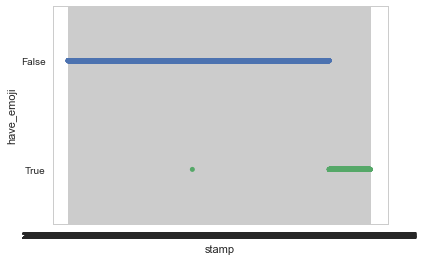

In [118]:
sns.stripplot(x="stamp", y="have_emoji", data=df_multilabel, orient='h'); # , marker='X', color='navy', size=5

No                stamp  \
0        1  2018-08-03 15:12:43   
1        2  2018-08-03 13:07:45   
2        3  2018-08-03 12:40:27   
3        4  2018-08-03 11:49:10   
4        5  2018-08-03 11:35:02   
5        6  2018-08-03 10:33:27   
6        7  2018-08-03 09:10:07   
7        8  2018-08-03 08:37:34   
8        9  2018-08-03 03:05:13   
9       10  2018-08-03 02:11:32   
10      11  2018-08-03 01:18:02   
11      12  2018-08-03 00:59:52   
12      13  2018-08-03 00:31:20   
13      14  2018-08-03 00:13:58   
14      15  2018-08-03 00:13:28   
15      16  2018-08-02 23:57:29   
16      17  2018-08-02 23:27:58   
17      18  2018-08-02 23:15:20   
18      19  2018-08-02 23:08:51   
19      20  2018-08-02 22:37:51   
20      21  2018-08-02 22:26:09   
21      22  2018-08-02 22:19:39   
22      23  2018-08-02 22:15:32   
23      24  2018-08-02 22:09:19   
24      25  2018-08-02 21:59:48   
25      26  2018-08-02 21:57:00   
26      27  2018-08-02 21:53:46   
27      28  2018-08-02 21:53:35   
28      29  2018-08-02 20:53:45   
29      30  2018-08-02 20:37:14   
...    ...                  ...   
9386  9387  2016-06-16 08:45:46   
9387  9388  2016-06-13 09:46:47   
9388  9389  2016-06-09 01:06:40   
9389  9390  2016-06-09 00:56:31   
9390  9391  2016-05-18 07:11:25   
9391  9392  2016-05-14 07:04:39   
9392  9393  2016-05-04 10:23:14   
9393  9394  2016-05-03 10:57:09   
9394  9395  2016-04-22 18:49:00   
9395  9396  2016-04-14 23:37:19   
9396  9397  2016-04-12 01:40:02   
9397  9398  2016-04-08 13:59:31   
9398  9399  2016-04-05 21:39:43   
9399  9400  2016-03-28 13:08:26   
9400  9401  2016-02-24 11:54:15   
9401  9402  2016-02-20 13:01:27   
9402  9403  2016-01-27 05:12:21   
9403  9404  2016-01-22 13:35:15   
9404  9405  2015-12-20 19:18:22   
9405  9406  2015-12-08 16:44:30   
9406  9407  2015-12-08 09:07:38   
9407  9408  2015-11-27 23:40:11   
9408  9409  2015-08-31 18:17:20   
9409  9410  2015-08-15 16:16:17   
9410  9411  2015-07-31 21:09:46   
9411  9412  2015-04-03 17:11:02   
9412  9413  2015-03-15 08:47:50   
9413  9414  2014-12-25 09:49:58   
9414  9415  2014-12-25 00:37:42   
9415  9416  2014-12-20 00:53:43   

                                                comment find_emoji  0  1  2  \
0                                                  八月你好         []  0  0  0   
1                                                  好巧好巧         []  0  0  0   
2     八月了，陌生人，一定要好好的，别累坏了自己的身体，不然，最爱你的爸爸妈妈他们会默默的为你流泪...         []  0  0  0   
3                                        又是一年的八月。听了7年的歌         []  0  0  0   
4                                          八月，愿我们一切顺利♥️         []  0  0  0   
5                                         八月注定是个充满变数的时候         []  0  0  0   
6                                                    八月         []  0  0  0   
7                                “五月鸣蜩，六月精阳。七月流火，八月未央。”         []  0  0  0   
8                       八月就是八月，八月我守口如瓶 八月里我是瓶中的水，你是青天的云         []  0  0  0   
9                                  八月，弯弯，希望你好好的，哪怕没有了我们         []  0  0  0   
10    八月 还有一个月就大四了 还有一年一个月就毕业了 喜欢你也不会告诉你 我 终究要回去的啊 金...         []  0  0  0   
11                                             开口太像吴青峰了         []  0  0  0   
12                                         八月 能带你到我身边吗。         []  0  0  0   
13                                      7月真的太难过了，妒忌使我后退         []  0  0  0   
14                                           希望我的8月会好一些         []  0  0  0   
15                      去年八月这个时候我大概在等待被录取吧，时间真快。祝八月平安快乐         []  0  0  0   
16                                                  八月啊         []  0  0  0   
17                                         愿八月安生  愿一切顺利         []  0  0  0   
18                                        八月，你好，请善待我的祝福         []  0  0  0   
19                                                 喜欢八月         []  0  0  0   
20                                              愿八月也安生。         []  0  0  0   
21                                       我啊  直到现在也还在那里呀         []  0  0  0   
22                  

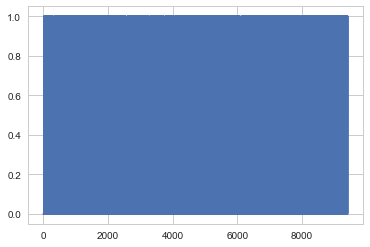

In [124]:
df_multilabel['have_emoji_01'] = df_multilabel['have_emoji'].replace({True: 1, False: 0})
df_multilabel['have_emoji_01'].plot();
df_multilabel

## 所有评论
### 词云
所有评论内容生成的词云图

In [47]:
import warnings
warnings.filterwarnings("ignore")
import jieba
import numpy as np
import codecs
import pandas as pd  
import matplotlib.pyplot as plt
%matplotlib inline

all_content = df.comment.values.tolist()
print(len(all_content), '\n', all_content[-1])

9490 
 [圈]


In [48]:
segment = []
for line in all_content:
    try:
        segs = jieba.lcut(line)
        for seg in segs:
            if len(seg)>1 and seg != '\r\n':
                segment.append(seg)
    except:
        print(line)
        continue
# 去停用词
words_df = pd.DataFrame({"segment": segment})
stopwords_df = pd.read_csv('Chinese_Stopwords.txt',index_col=False, quoting=3,sep="\t",names=['stopwords'], encoding='utf-8') #quoting=3全不引用
words_df = words_df[~words_df.segment.isin(stopwords_df.stopwords)]
words_df.head(20)

segment
1       我会
2      千百万
3       方式
4      救回来
6       成熟
7       阿姨
8       唱歌
9       歌手
10      居然
11     大胡子
12      叔叔
13      死死
14      一起
15     整首歌
16      有种
17      压抑
18      感觉
19      八月
20      生活
21      网易

统计词频

In [49]:
words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数": np.size})
words_stat = words_stat.reset_index().sort_values(by=["计数"], ascending=False)
words_stat.head(20)

segment    计数
1875      八月  4320
2964      喜欢   680
609       一个   485
4016      希望   460
2270      加油   450
6091      没有   418
9144      首歌   388
6686      现在   319
1298      九月   303
4001      已经   296
5576      最后   283
7063      知道   268
832       七月   242
1487      今天   239
2811      听到   228
795       一起   222
6565      爱心   219
1653      你好   217
8437      过去   212
701       一年   209

[超级课程表APP爬虫，大学生都这么玩](https://www.jianshu.com/p/c42d787e7280)

In [50]:
from pyecharts import WordCloud
wordcloud = WordCloud(width=800, height=520)
wordcloud.add("9400余条评论生成的词云", words_stat['segment'], words_stat['计数'], word_size_range=[20, 100])
wordcloud

### 提取关键词

In [51]:
import jieba.analyse
extract_tags = "  ".join(jieba.analyse.extract_tags(' '.join(all_content), topK=200, withWeight=False, allowPOS=('ns', 'n')))
print(extract_tags)

首歌  爱心  评论  青峰  时候  开学  感觉  流泪  网易  声音  旅人  日子  旋律  我会  学校  男朋友  晚安  尾巴  时间  大学  故事  苏打  歌手  歌词  亲亲  朋友  有点  大家  人生  毕业  心情  好运  开口  音乐  事情  吐舌  歌单  声线  大叔  听的歌  混蛋  名字  异地  日本  长安  月份  女朋友  狮子座  时光  梦想  世界  日文  单曲  皱眉  回家  歌曲  距离  见面  程度  感情  前奏  同学  红心  地方  爱情  歌名  结果  民谣  伤感  朋友圈  男声  长大  妹子  消失  单身  热评  样子  经历  女生  城市  青春  钟情  头像  口罩  谎言  理想  耳机  伤心  纪念  作业  吉他  眼泪  记忆  目标  早安  九尾  男生  内心  天气  季节  当兵  好事  唱歌  陌生人  哭腔  缘分  电影  大雨  卧槽  嗓音  思念  上学  勇气  专辑  学会  想象  机会  东西  男孩子  心仪  男孩  学生  老师  意义  次郎  妈妈  副歌  陌生  台风  小朋友  暑假作业  姑娘  小时  女孩子  歌唱  未央  钢琴  意思  兄弟  陪伴  情绪  情人节  蛋糕  军训  味道  室友  应景  对方  无法  西瓜  地步  鬼脸  兔子  曲子  宿舍  中考  有缘  联系  研究生  调子  倒数  心酸  心动  习惯  小时候  理由  征程  床上  手机  浪费  压力  父母  哥哥  末尾  歌声  电话  天空  外公  恋人  生病  笨蛋  太阳  女孩  封面  男友  小心  女声  动漫  眼睛  泪目  成绩  办法  大人  曲调  流火  爱人  现实  尾声  好消息  小伙伴


In [52]:
textrank = jieba.analyse.textrank(' '.join(all_content), topK=200, withWeight=False, allowPOS=('ns', 'n'))
print(textrank)

['首歌', '爱心', '时候', '感觉', '声音', '流泪', '评论', '大学', '网易', '青峰', '有点', '旅人', '音乐', '学校', '毕业', '时间', '朋友', '旋律', '故事', '日本', '歌手', '日子', '开学', '大家', '人生', '地方', '世界', '苏打', '歌词', '亲亲', '距离', '开口', '我会', '心情', '回家', '大叔', '歌曲', '同学', '耳机', '月份', '爱情', '皱眉', '上学', '长安', '老师', '晚安', '名字', '理想', '男朋友', '内心', '声线', '西瓜', '经历', '城市', '日文', '尾巴', '青春', '伤感', '吐舌', '消失', '前奏', '问题', '全部', '想象', '空调', '宿舍', '结果', '感情', '学生', '无法', '游戏', '台风', '室友', '事情', '东西', '电影', '小时候', '吉他', '天空', '湖南', '歌名', '唱歌', '电话', '对方', '太阳', '梦想', '单身', '思念', '身体', '好运', '手机', '九尾', '红心', '动漫', '天气', '心仪', '女朋友', '机会', '兔子', '妹子', '头像', '嗓音', '勇气', '狮子座', '空气', '长大', '时代', '大雨', '意义', '情绪', '压力', '封面', '当兵', '男声', '部分', '听的歌', '生病', '混蛋', '研究生', '放学', '次郎', '森林', '过程', '头发', '纪念', '学会', '家人', '单曲', '天涯', '图灵', '程度', '口罩', '记忆', '男人', '陌生人', '爸妈', '副歌', '流火', '灵魂', '作业', '问候', '眼睛', '歌单', '恋人', '民谣', '编程', '旅途', '电脑', '情人节', '校园', '泪目', '新生', '爸爸', '背景', '习惯', '广州', '心灵', '成绩', '万事', '上海', '眼泪', '节奏', '日式', '家乡', '树叶', '

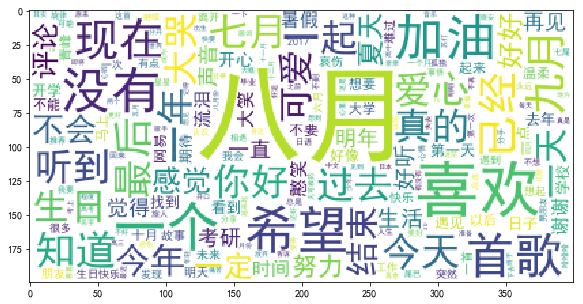

In [53]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
from wordcloud import WordCloud
wordcloud = WordCloud(font_path='simhei.ttf', background_color='white',max_font_size=80)
word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud = wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud);

## 头像爬虫

In [33]:
import pandas as pd
df = pd.read_csv('August_ID_27759600_1_2_all.csv',encoding='utf-8')
df.tail()

No  page    userID   nickname                     comment  \
9324  9353   468  15338047       故里天清                           ~   
9325  9354   468   5714730  wayne_hhh  前几天坐在海边听到时，变得很平静，我需要这样的时刻。   
9326  9355   468   3037295        张士豪        @乌拉尔山乌拉尔河 这个声音应该会喜欢，   
9327  9356   468   3037295        张士豪                         [强]   
9328  9357   468  11825095       染井千绘                         [圈]   

        commentTime               stamp  likedCount  userType  vipType  \
9324  1428052262936   2015/4/3 17:11:02           1         0        0   
9325  1426380470685   2015/3/15 8:47:50           3         0        0   
9326  1419472198759  2014/12/25 9:49:58           0         0        0   
9327  1419439062928  2014/12/25 0:37:42           0         0        0   
9328  1419008023910  2014/12/20 0:53:43           2         0        0   

              expertTags  experts  \
9324  ['古风', '华语', '古典']      NaN   
9325                 NaN      NaN   
9326                 NaN      NaN   
9327                 NaN      NaN   
9328                 NaN      NaN   

                                              avatarUrl  
9324  http://p1.music.126.net/dVf2Bh0Pp0kQ1oyHbzu7bg...  
9325  http://p1.music.126.net/5akEZFTFaXBHKnAlQy841g...  
9326  http://p1.music.126.net/ARgrswyyvJijwyWnkxEWyA...  
9327  http://p1.music.126.net/ARgrswyyvJijwyWnkxEWyA...  
9328  http://p1.music.126.net/Tuc7fLYANPM9_Hb58iw8NQ...

In [45]:
images = df.avatarUrl.values.tolist()
print(len(images))
images = set(images)
print(len(images))
for i,url in enumerate(images):
    print(url)
    if i == 5:break

9329
7236
http://p1.music.126.net/JidyBKgjDdhQv5ABdpL8YQ==/109951162872637867.jpg
http://p1.music.126.net/PEMQP5QXGELD4doElD2zNg==/109951163252584058.jpg
http://p1.music.126.net/YHMFAfPuU3Aw9ZnkCb6n6w==/18645518185509594.jpg
http://p1.music.126.net/qRY7b825phgZekiPfgOHMg==/109951163038886332.jpg
http://p1.music.126.net/3il0ouTP4r7MqPjRcf6pTQ==/19057835044271177.jpg
http://p1.music.126.net/o0ApTZKlEwTMRlryYv28RA==/109951163383421241.jpg


图片爬虫：[0_JianShuJiaoYou_3_Images.ipynb](http://localhost:8888/notebooks/1-DS_DM_ML_DL/0_ML_DM/1_Projects/0-JianShuJiaoYou/0_JianShuJiaoYou_3_Images.ipynb)  
http://localhost:8888/tree/1-DS_DM_ML_DL/0_ML_DM/1_Projects/0-JianShuJiaoYou

In [48]:
list(set([1,2,1,2,3]))[:1]

[1]

In [ ]:
import time
import urllib.request
import random

filename = "Avatar_Images" # 先创建一个保存图片的文件夹 
num = 0
start = 4187
for i,url in enumerate(list(images)[start:]):
    image_name = url.split('/')[-1] # 19190875951315499.jpg 
    print(i+start,image_name,url)
    path = filename + "/" + "{}-{}".format(i+start, image_name)
    urllib.request.urlretrieve(url,path)
    if i/20:
        time.sleep(random.randint(0,1)) # 放缓爬取速度